# Titanic Competition - Modeling

## 5. Modeling

**Data preparation**:
* Split train dataset into training (80%) and test (validation) (20%) sets using `train_test_split`
* Define predictive variables (X) and the target variable (y = is_canceled)
* Apply `random_state=42` to ensure reproducibility

**Classification models**:
* Naive Bayes (`GaussianNB`): no hyperparameters
* K-Nearest Neighbors (`KNeighborsClassifier`): optimize `n_neighbors`
* Logistic Regression (`LogisticRegression`): optimize `C` and `max_iter`
* Linear Discriminant Analysis (`LinearDiscriminantAnalysis`): no hyperparameters
* Quadratic Discriminant Analysis (`QuadraticDiscriminantAnalysis`): no hyperparameters
* Decision Tree (`DecisionTreeClassifier`): optimize `max_depth`, `min_samples_split`, `min_samples_leaf`
* Random Forest (`RandomForestClassifier`): optimize `n_estimators`, `max_depth`, `min_samples_split`, `min_samples_leaf`
* Suppor Vector Classifier (`SVC`): optimize `C`, `degree`

**Optimization techniques**:
* Grid Search with 5-fold cross-validation (`cv=5`)
* Optimization based on F1-score (`scoring='f1'`)
* Feature selection using Forward Selection

**Evaluation metrics**:
* Accuracy – overall correctness of classification
* Precision – quality of positive predictions
* Recall – coverage of actual positive cases
* F1-score – harmonic mean of precision and recall
* ROC-AUC – class separability
* Training time and prediction time – computational efficiency

**Process automation**:
* Systematic testing of all models across all feature combinations
* Automatic saving of results to a CSV file
* Detailed logging of progress and results for each model
* Error handling and process continuation in case of failures

### 5.1 Prepare helper functions

In [1]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [2]:
from itertools import chain, combinations
from typing import List

def powerset(columns: List[str]) -> List[List[str]]:
    all_subsets = chain.from_iterable(
        combinations(columns, r) for r in range(1, len(columns) + 1)
    )
    
    valid_subsets = []
    for subset in all_subsets:
        subset = set(subset)
        
        # To make the process faster we will include all dummy variables if on of them appers
        if "EmbarkedA" in subset and not {"EmbarkedB", "EmbarkedC"}.issubset(subset):
            continue
        
        # To make the process faster we will include all dummy variables if on of them appers
        if "Pclass1" in subset and not {"Pclass2", "Pclass3"}.issubset(subset):
            continue
        
        valid_subsets.append(list(subset))
    
    return valid_subsets

In [3]:
models_and_params = {
    "GaussianNB": {
        "model": GaussianNB(),
        "params": {},
    },
    "KNeighborsClassifier": {
        "model": KNeighborsClassifier(),
        "params": {
            "n_neighbors": [3, 5, 7, 9],
        },
    },
    "LogisticRegression": {
        "model": LogisticRegression(),
        "params": {
            "C": [0.001, 0.01, 0.1, 1, 10, 100],
            "max_iter": [100, 200, 500, 1000]
        },
    },
    "LinearDiscriminantAnalysis": {
        "model": LinearDiscriminantAnalysis(),
        "params": {},   
    },
    "QuadraticDiscriminantAnalysis": {
        "model": QuadraticDiscriminantAnalysis(),
        "params": {},
    },
    "DecisionTreeClassifier": {
        "model": DecisionTreeClassifier(),
        "params": {
            "max_depth": [None, 10, 20, 30],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4],
        }
    },
    "RandomForestClassifier": {
        "model": RandomForestClassifier(),
        "params": {
            "n_estimators": [100, 200, 300],
            "max_depth": [None, 10, 20, 30],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4],
        },
    },
    "SVC": {
        "model": SVC(),
        "params": {
            "C": [0.1, 1, 10],
            "degree": [2, 3, 4],
        }
    }
}

In [4]:
from typing import Dict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import time

def evaluate_model(grid_search, X_test: pd.DataFrame, y_test: pd.DataFrame) -> Dict:
    print(f"\nEvaluating model: {grid_search.best_estimator_.__class__.__name__}")
    
    fit_times = grid_search.cv_results_['mean_fit_time']
    mean_fit_time = np.mean(fit_times)
    
    start_time = time.time()
    y_pred = grid_search.predict(X_test)
    predict_time = time.time() - start_time
    
    y_pred_proba = grid_search.predict_proba(X_test)[:, 1] if hasattr(grid_search, "predict_proba") else None

    metrics = {
        'accuracy': np.round(
            accuracy_score(y_test, y_pred), 4
        ),
        'precision': np.round(
            precision_score(y_test, y_pred, zero_division=0), 4
        ),
        'recall': np.round(
            recall_score(y_test, y_pred, zero_division=0), 3
        ),
        'f1': np.round(
            f1_score(y_test, y_pred, zero_division=0), 3
        ),
        'roc_auc': np.round(
            roc_auc_score(y_test, y_pred_proba), 3
        ) if y_pred_proba is not None else None,
        'mean_fit_time': np.round(
            mean_fit_time, 3
        ),
        'predict_time': np.round(
            predict_time, 3
        ),
    }
    
    print("Metrics obtained:")
    for metric, value in metrics.items():
        print(f"- {metric}: {value}")
    
    return metrics

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from sklearn.model_selection import GridSearchCV

def evaluate_models(models_and_params: Dict, X_train: pd.DataFrame, y_train: pd.DataFrame, X_val: pd.DataFrame, y_val: pd.DataFrame) -> List:
    print(f"\nStarting evaluation of {len(models_and_params)} models")
    print(f"Training data shape: {X_train.shape}")
    print(f"Validation data shape: {X_val.shape}")
    
    results = []
    for name, info in models_and_params.items():
        print(f"\n{'='*50}")
        print(f"Training model: {name}")
        print(f"Parameter grid: {info['params']}")
        
        model = info["model"]
        params = info["params"]
        
        try:
            start_time = time.time()
            
            grid_search = GridSearchCV(
                estimator=model, 
                param_grid=params,
                cv=5,
                scoring='f1',
                n_jobs=-1,
                verbose=1,
                return_train_score=True
            )
            
            grid_search.fit(X_train, y_train)
            
            metrics = evaluate_model(grid_search, X_val, y_val)
            training_time = time.time() - start_time
            
            print(f"Best parameters found: {grid_search.best_params_}")
            print(f"Training time: {training_time:.2f} seconds")
            
            result = {
                'model': name,
                'columns': X_train.columns.tolist(),
                'best_params': str(grid_search.best_params_),
                'training_time': training_time,
                **metrics
            }
            results.append(result)
            
            
        except Exception as e:
            print(f"Error training {name}: {str(e)}")
    
    return results

In [6]:
def prepare_evalution(models_and_params: Dict, columns: List[str], X_train: pd.DataFrame, y_train: pd.DataFrame, X_val: pd.DataFrame, y_val: pd.DataFrame) -> pd.DataFrame:
    results = []
    total_combinations = len(list(powerset(columns)))
    
    print(f"Starting evaluation with {len(columns)} features")
    print(f"Total feature combinations to evaluate: {total_combinations}")
    
    for i, cols in enumerate(tqdm(powerset(columns)), 1):
        
        print(f"\nEvaluating combination {i}/{total_combinations}")
        print(f"Selected features: {cols}")
        
        X_train_sub = X_train[list(cols)]
        X_val_sub = X_val[list(cols)]
        
        results.append(
            evaluate_models(models_and_params, X_train_sub, y_train, X_val_sub, y_val)
        )
        
        print(f"Completed combination {i}/{total_combinations}")
    
    print("\nCreating results DataFrame...")
    results_list = [pd.DataFrame(result) for result in results]
    results_df = pd.concat(results_list, ignore_index=True).reset_index(drop=True)
    
    print("Saving results to CSV...")
    results_df.to_csv("data/train_results.csv")
    
    print("Evaluation complete!")
    
    return results_df


### 5.2 Prepare data

In [7]:
train_clean = pd.read_csv("data/train_clean.csv")
train_clean.head()

,Survived,Sex,Age,Fare,EmbarkedC,EmbarkedQ,EmbarkedS,Pclass1,Pclass2,Pclass3
0,0,1,-0.532730,-0.500240,0,0,1,0,0,1
1,1,0,0.673661,0.788947,1,0,0,1,0,0
2,1,0,-0.231132,-0.486650,0,0,1,0,0,1
3,1,0,0.447463,0.422861,0,0,1,1,0,0
4,0,1,0.447463,-0.484133,0,0,1,0,0,1


In [8]:
from sklearn.model_selection import train_test_split

X = train_clean.drop(columns=["Survived"])
y = train_clean["Survived"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
columns = X.columns.to_list()
columns

['Sex',
 'Age',
 'Fare',
 'EmbarkedC',
 'EmbarkedQ',
 'EmbarkedS',
 'Pclass1',
 'Pclass2',
 'Pclass3']

### 5.3 Modeling

In [10]:
results = prepare_evalution(
    models_and_params, 
    columns, 
    X_train, 
    y_train, 
    X_val, 
    y_val
)

Starting evaluation with 9 features
Total feature combinations to evaluate: 319


  0%|          | 0/319 [00:00<?, ?it/s]


Evaluating combination 1/319
Selected features: ['Sex']

Starting evaluation of 8 models
Training data shape: (711, 1)
Validation data shape: (178, 1)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Evaluating model: GaussianNB
Metrics obtained:
- accuracy: 0.7978
- precision: 0.726
- recall: 0.768
- f1: 0.746
- roc_auc: 0.792
- mean_fit_time: 0.003
- predict_time: 0.001
Best parameters found: {}
Training time: 1.44 seconds

Training model: KNeighborsClassifier
Parameter grid: {'n_neighbors': [3, 5, 7, 9]}
Fitting 5 folds for each of 4 candidates, totalling 20 fits

Evaluating model: KNeighborsClassifier
Metrics obtained:
- accuracy: 0.7978
- precision: 0.726
- recall: 0.768
- f1: 0.746
- roc_auc: 0.792
- mean_fit_time: 0.004
- predict_time: 0.003
Best parameters found: {'n_neighbors': 9}
Training time: 3.18 seconds

Training model: LogisticRegression
Parameter grid: {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'max_iter': [100, 200,

  0%|          | 1/319 [00:21<1:52:32, 21.24s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7978
- precision: 0.726
- recall: 0.768
- f1: 0.746
- roc_auc: 0.792
- mean_fit_time: 0.508
- predict_time: 0.005
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 15.75 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7978
- precision: 0.726
- recall: 0.768
- f1: 0.746
- roc_auc: None
- mean_fit_time: 0.017
- predict_time: 0.003
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.17 seconds
Completed combination 1/319

Evaluating combination 2/319
Selected features: ['Age']

Starting evaluation of 8 models
Training data shape: (711, 1)
Validation data shape: (178, 1)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Eval

  1%|          | 2/319 [00:39<1:43:42, 19.63s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6292
- precision: 0.5263
- recall: 0.435
- f1: 0.476
- roc_auc: 0.641
- mean_fit_time: 0.566
- predict_time: 0.006
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Training time: 17.68 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6404
- precision: 0.7778
- recall: 0.101
- f1: 0.179
- roc_auc: None
- mean_fit_time: 0.016
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.13 seconds
Completed combination 2/319

Evaluating combination 3/319
Selected features: ['Fare']

Starting evaluation of 8 models
Training data shape: (711, 1)
Validation data shape: (178, 1)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Evalu

  1%|          | 3/319 [00:48<1:18:23, 14.89s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.736
- precision: 0.7037
- recall: 0.551
- f1: 0.618
- roc_auc: 0.749
- mean_fit_time: 0.278
- predict_time: 0.006
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Training time: 8.81 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6742
- precision: 0.6897
- recall: 0.29
- f1: 0.408
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 3/319

Evaluating combination 4/319
Selected features: ['EmbarkedC']

Starting evaluation of 8 models
Training data shape: (711, 1)
Validation data shape: (178, 1)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fits



  1%|▏         | 4/319 [00:56<1:02:37, 11.93s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6236
- precision: 0.5278
- recall: 0.275
- f1: 0.362
- roc_auc: 0.56
- mean_fit_time: 0.225
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 6.99 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6236
- precision: 0.5278
- recall: 0.275
- f1: 0.362
- roc_auc: None
- mean_fit_time: 0.007
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 4/319

Evaluating combination 5/319
Selected features: ['EmbarkedQ']

Starting evaluation of 8 models
Training data shape: (711, 1)
Validation data shape: (178, 1)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fits

  2%|▏         | 5/319 [01:03<54:04, 10.33s/it]  


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6124
- precision: 0.0
- recall: 0.0
- f1: 0.0
- roc_auc: 0.504
- mean_fit_time: 0.229
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 7.11 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6124
- precision: 0.0
- recall: 0.0
- f1: 0.0
- roc_auc: None
- mean_fit_time: 0.007
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 5/319

Evaluating combination 6/319
Selected features: ['EmbarkedS']

Starting evaluation of 8 models
Training data shape: (711, 1)
Validation data shape: (178, 1)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Evaluating 

  2%|▏         | 6/319 [01:11<48:53,  9.37s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6124
- precision: 0.5
- recall: 0.348
- f1: 0.41
- roc_auc: 0.564
- mean_fit_time: 0.224
- predict_time: 0.006
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Training time: 7.06 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6124
- precision: 0.5
- recall: 0.348
- f1: 0.41
- roc_auc: None
- mean_fit_time: 0.008
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 6/319

Evaluating combination 7/319
Selected features: ['Pclass2']

Starting evaluation of 8 models
Training data shape: (711, 1)
Validation data shape: (178, 1)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Evaluati

  2%|▏         | 7/319 [01:18<44:56,  8.64s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6124
- precision: 0.0
- recall: 0.0
- f1: 0.0
- roc_auc: 0.52
- mean_fit_time: 0.218
- predict_time: 0.002
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 6.74 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6124
- precision: 0.0
- recall: 0.0
- f1: 0.0
- roc_auc: None
- mean_fit_time: 0.007
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 7/319

Evaluating combination 8/319
Selected features: ['Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 1)
Validation data shape: (178, 1)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Evaluating model:

  3%|▎         | 8/319 [01:25<42:24,  8.18s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6573
- precision: 0.5465
- recall: 0.681
- f1: 0.606
- roc_auc: 0.662
- mean_fit_time: 0.218
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 6.79 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6573
- precision: 0.5465
- recall: 0.681
- f1: 0.606
- roc_auc: None
- mean_fit_time: 0.007
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 8/319

Evaluating combination 9/319
Selected features: ['Sex', 'Age']

Starting evaluation of 8 models
Training data shape: (711, 2)
Validation data shape: (178, 2)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fi

  3%|▎         | 9/319 [01:34<42:53,  8.30s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8146
- precision: 0.7432
- recall: 0.797
- f1: 0.769
- roc_auc: 0.845
- mean_fit_time: 0.256
- predict_time: 0.003
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 8.09 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8146
- precision: 0.7368
- recall: 0.812
- f1: 0.772
- roc_auc: None
- mean_fit_time: 0.024
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.14 seconds
Completed combination 9/319

Evaluating combination 10/319
Selected features: ['Fare', 'Sex']

Starting evaluation of 8 models
Training data shape: (711, 2)
Validation data shape: (178, 2)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fit

  3%|▎         | 10/319 [01:42<43:23,  8.43s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7753
- precision: 0.6933
- recall: 0.754
- f1: 0.722
- roc_auc: 0.832
- mean_fit_time: 0.263
- predict_time: 0.003
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 8.27 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8034
- precision: 0.7297
- recall: 0.783
- f1: 0.755
- roc_auc: None
- mean_fit_time: 0.013
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 10/319

Evaluating combination 11/319
Selected features: ['Sex', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (711, 2)
Validation data shape: (178, 2)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling

  3%|▎         | 11/319 [01:50<41:24,  8.07s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7978
- precision: 0.726
- recall: 0.768
- f1: 0.746
- roc_auc: 0.808
- mean_fit_time: 0.221
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 6.84 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7978
- precision: 0.726
- recall: 0.768
- f1: 0.746
- roc_auc: None
- mean_fit_time: 0.005
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.07 seconds
Completed combination 11/319

Evaluating combination 12/319
Selected features: ['EmbarkedQ', 'Sex']

Starting evaluation of 8 models
Training data shape: (711, 2)
Validation data shape: (178, 2)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totallin

  4%|▍         | 12/319 [01:57<40:03,  7.83s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7978
- precision: 0.726
- recall: 0.768
- f1: 0.746
- roc_auc: 0.797
- mean_fit_time: 0.22
- predict_time: 0.002
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 6.85 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7978
- precision: 0.726
- recall: 0.768
- f1: 0.746
- roc_auc: None
- mean_fit_time: 0.005
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.08 seconds
Completed combination 12/319

Evaluating combination 13/319
Selected features: ['EmbarkedS', 'Sex']

Starting evaluation of 8 models
Training data shape: (711, 2)
Validation data shape: (178, 2)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling

  4%|▍         | 13/319 [02:04<39:00,  7.65s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7978
- precision: 0.726
- recall: 0.768
- f1: 0.746
- roc_auc: 0.802
- mean_fit_time: 0.22
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 6.83 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7978
- precision: 0.726
- recall: 0.768
- f1: 0.746
- roc_auc: None
- mean_fit_time: 0.005
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.08 seconds
Completed combination 13/319

Evaluating combination 14/319
Selected features: ['Pclass2', 'Sex']

Starting evaluation of 8 models
Training data shape: (711, 2)
Validation data shape: (178, 2)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 5

  4%|▍         | 14/319 [02:12<38:17,  7.53s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7978
- precision: 0.726
- recall: 0.768
- f1: 0.746
- roc_auc: 0.811
- mean_fit_time: 0.221
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 6.86 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7978
- precision: 0.726
- recall: 0.768
- f1: 0.746
- roc_auc: None
- mean_fit_time: 0.005
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.08 seconds
Completed combination 14/319

Evaluating combination 15/319
Selected features: ['Pclass3', 'Sex']

Starting evaluation of 8 models
Training data shape: (711, 2)
Validation data shape: (178, 2)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 

  5%|▍         | 15/319 [02:19<37:56,  7.49s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7978
- precision: 0.726
- recall: 0.768
- f1: 0.746
- roc_auc: 0.845
- mean_fit_time: 0.223
- predict_time: 0.004
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Training time: 6.97 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8034
- precision: 0.9048
- recall: 0.551
- f1: 0.685
- roc_auc: None
- mean_fit_time: 0.005
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.08 seconds
Completed combination 15/319

Evaluating combination 16/319
Selected features: ['Fare', 'Age']

Starting evaluation of 8 models
Training data shape: (711, 2)
Validation data shape: (178, 2)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 5

  5%|▌         | 16/319 [02:28<40:27,  8.01s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7135
- precision: 0.6452
- recall: 0.58
- f1: 0.611
- roc_auc: 0.772
- mean_fit_time: 0.276
- predict_time: 0.009
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Training time: 8.80 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7135
- precision: 0.7368
- recall: 0.406
- f1: 0.523
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 16/319

Evaluating combination 17/319
Selected features: ['Age', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (711, 2)
Validation data shape: (178, 2)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totallin

  5%|▌         | 17/319 [02:37<41:12,  8.19s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6629
- precision: 0.5849
- recall: 0.449
- f1: 0.508
- roc_auc: 0.665
- mean_fit_time: 0.255
- predict_time: 0.006
Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Training time: 8.13 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6348
- precision: 0.5833
- recall: 0.203
- f1: 0.301
- roc_auc: None
- mean_fit_time: 0.016
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.12 seconds
Completed combination 17/319

Evaluating combination 18/319
Selected features: ['EmbarkedQ', 'Age']

Starting evaluation of 8 models
Training data shape: (711, 2)
Validation data shape: (178, 2)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalli

  6%|▌         | 18/319 [02:45<41:37,  8.30s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6742
- precision: 0.6038
- recall: 0.464
- f1: 0.525
- roc_auc: 0.658
- mean_fit_time: 0.254
- predict_time: 0.006
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Training time: 8.09 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6517
- precision: 0.7692
- recall: 0.145
- f1: 0.244
- roc_auc: None
- mean_fit_time: 0.014
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.12 seconds
Completed combination 18/319

Evaluating combination 19/319
Selected features: ['EmbarkedS', 'Age']

Starting evaluation of 8 models
Training data shape: (711, 2)
Validation data shape: (178, 2)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalli

  6%|▌         | 19/319 [02:54<41:49,  8.37s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6798
- precision: 0.62
- recall: 0.449
- f1: 0.521
- roc_auc: 0.674
- mean_fit_time: 0.255
- predict_time: 0.003
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 8.07 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6236
- precision: 0.5357
- recall: 0.217
- f1: 0.309
- roc_auc: None
- mean_fit_time: 0.014
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.12 seconds
Completed combination 19/319

Evaluating combination 20/319
Selected features: ['Pclass2', 'Age']

Starting evaluation of 8 models
Training data shape: (711, 2)
Validation data shape: (178, 2)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 5 f

  6%|▋         | 20/319 [03:03<42:12,  8.47s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6742
- precision: 0.6038
- recall: 0.464
- f1: 0.525
- roc_auc: 0.651
- mean_fit_time: 0.257
- predict_time: 0.006
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Training time: 8.23 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6292
- precision: 0.7143
- recall: 0.072
- f1: 0.132
- roc_auc: None
- mean_fit_time: 0.017
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.15 seconds
Completed combination 20/319

Evaluating combination 21/319
Selected features: ['Pclass3', 'Age']

Starting evaluation of 8 models
Training data shape: (711, 2)
Validation data shape: (178, 2)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 5

  7%|▋         | 21/319 [03:11<42:04,  8.47s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6798
- precision: 0.6034
- recall: 0.507
- f1: 0.551
- roc_auc: 0.729
- mean_fit_time: 0.255
- predict_time: 0.003
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 8.06 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6742
- precision: 0.5696
- recall: 0.652
- f1: 0.608
- roc_auc: None
- mean_fit_time: 0.013
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 21/319

Evaluating combination 22/319
Selected features: ['Fare', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (711, 2)
Validation data shape: (178, 2)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling

  7%|▋         | 22/319 [03:20<42:31,  8.59s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7079
- precision: 0.6491
- recall: 0.536
- f1: 0.587
- roc_auc: 0.733
- mean_fit_time: 0.265
- predict_time: 0.006
Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200}
Training time: 8.43 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6685
- precision: 0.6923
- recall: 0.261
- f1: 0.379
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 22/319

Evaluating combination 23/319
Selected features: ['EmbarkedQ', 'Fare']

Starting evaluation of 8 models
Training data shape: (711, 2)
Validation data shape: (178, 2)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, total

  7%|▋         | 23/319 [03:29<42:44,  8.67s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7247
- precision: 0.6724
- recall: 0.565
- f1: 0.614
- roc_auc: 0.747
- mean_fit_time: 0.266
- predict_time: 0.004
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 8.36 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6798
- precision: 0.7143
- recall: 0.29
- f1: 0.412
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 23/319

Evaluating combination 24/319
Selected features: ['EmbarkedS', 'Fare']

Starting evaluation of 8 models
Training data shape: (711, 2)
Validation data shape: (178, 2)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling

  8%|▊         | 24/319 [03:38<42:55,  8.73s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6966
- precision: 0.6415
- recall: 0.493
- f1: 0.557
- roc_auc: 0.744
- mean_fit_time: 0.265
- predict_time: 0.006
Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Training time: 8.44 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6798
- precision: 0.75
- recall: 0.261
- f1: 0.387
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 24/319

Evaluating combination 25/319
Selected features: ['Pclass2', 'Fare']

Starting evaluation of 8 models
Training data shape: (711, 2)
Validation data shape: (178, 2)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 

  8%|▊         | 25/319 [03:46<42:57,  8.77s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6854
- precision: 0.6327
- recall: 0.449
- f1: 0.525
- roc_auc: 0.732
- mean_fit_time: 0.266
- predict_time: 0.006
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Training time: 8.45 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7135
- precision: 0.725
- recall: 0.42
- f1: 0.532
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 25/319

Evaluating combination 26/319
Selected features: ['Fare', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 2)
Validation data shape: (178, 2)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 5

  8%|▊         | 26/319 [03:55<43:07,  8.83s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7135
- precision: 0.65
- recall: 0.565
- f1: 0.605
- roc_auc: 0.73
- mean_fit_time: 0.265
- predict_time: 0.008
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Training time: 8.53 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7079
- precision: 0.6393
- recall: 0.565
- f1: 0.6
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 26/319

Evaluating combination 27/319
Selected features: ['EmbarkedQ', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (711, 2)
Validation data shape: (178, 2)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling

  8%|▊         | 27/319 [04:03<40:45,  8.38s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6236
- precision: 0.5278
- recall: 0.275
- f1: 0.362
- roc_auc: 0.567
- mean_fit_time: 0.221
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 6.88 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6236
- precision: 0.5278
- recall: 0.275
- f1: 0.362
- roc_auc: None
- mean_fit_time: 0.008
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 27/319

Evaluating combination 28/319
Selected features: ['EmbarkedS', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (711, 2)
Validation data shape: (178, 2)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, 

  9%|▉         | 28/319 [04:10<39:05,  8.06s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6236
- precision: 0.5278
- recall: 0.275
- f1: 0.362
- roc_auc: 0.567
- mean_fit_time: 0.223
- predict_time: 0.002
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 6.91 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6236
- precision: 0.5278
- recall: 0.275
- f1: 0.362
- roc_auc: None
- mean_fit_time: 0.007
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 28/319

Evaluating combination 29/319
Selected features: ['Pclass2', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (711, 2)
Validation data shape: (178, 2)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, to

  9%|▉         | 29/319 [04:17<37:54,  7.84s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6236
- precision: 0.5278
- recall: 0.275
- f1: 0.362
- roc_auc: 0.594
- mean_fit_time: 0.224
- predict_time: 0.003
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 6.93 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6236
- precision: 0.5278
- recall: 0.275
- f1: 0.362
- roc_auc: None
- mean_fit_time: 0.008
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 29/319

Evaluating combination 30/319
Selected features: ['Pclass3', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (711, 2)
Validation data shape: (178, 2)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totall

  9%|▉         | 30/319 [04:25<37:03,  7.69s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6573
- precision: 0.5465
- recall: 0.681
- f1: 0.606
- roc_auc: 0.681
- mean_fit_time: 0.224
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 6.94 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6573
- precision: 0.5465
- recall: 0.681
- f1: 0.606
- roc_auc: None
- mean_fit_time: 0.008
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 30/319

Evaluating combination 31/319
Selected features: ['EmbarkedQ', 'EmbarkedS']

Starting evaluation of 8 models
Training data shape: (711, 2)
Validation data shape: (178, 2)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, 

 10%|▉         | 31/319 [04:32<36:25,  7.59s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6236
- precision: 0.5278
- recall: 0.275
- f1: 0.362
- roc_auc: 0.567
- mean_fit_time: 0.224
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 6.94 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6236
- precision: 0.5278
- recall: 0.275
- f1: 0.362
- roc_auc: None
- mean_fit_time: 0.007
- predict_time: 0.003
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 31/319

Evaluating combination 32/319
Selected features: ['EmbarkedQ', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (711, 2)
Validation data shape: (178, 2)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, to

 10%|█         | 32/319 [04:39<35:56,  7.51s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6124
- precision: 0.5
- recall: 0.014
- f1: 0.028
- roc_auc: 0.523
- mean_fit_time: 0.223
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 6.94 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6124
- precision: 0.0
- recall: 0.0
- f1: 0.0
- roc_auc: None
- mean_fit_time: 0.008
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 32/319

Evaluating combination 33/319
Selected features: ['EmbarkedQ', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 2)
Validation data shape: (178, 2)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 5 

 10%|█         | 33/319 [04:47<35:35,  7.47s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6517
- precision: 0.5422
- recall: 0.652
- f1: 0.592
- roc_auc: 0.665
- mean_fit_time: 0.223
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 6.93 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6517
- precision: 0.5422
- recall: 0.652
- f1: 0.592
- roc_auc: None
- mean_fit_time: 0.008
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 33/319

Evaluating combination 34/319
Selected features: ['EmbarkedS', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (711, 2)
Validation data shape: (178, 2)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, to

 11%|█         | 34/319 [04:54<35:18,  7.43s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6011
- precision: 0.25
- recall: 0.014
- f1: 0.027
- roc_auc: 0.594
- mean_fit_time: 0.224
- predict_time: 0.003
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 6.95 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6011
- precision: 0.25
- recall: 0.014
- f1: 0.027
- roc_auc: None
- mean_fit_time: 0.008
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 34/319

Evaluating combination 35/319
Selected features: ['EmbarkedS', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 2)
Validation data shape: (178, 2)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 

 11%|█         | 35/319 [05:02<35:05,  7.41s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6573
- precision: 0.5465
- recall: 0.681
- f1: 0.606
- roc_auc: 0.688
- mean_fit_time: 0.223
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 6.93 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6573
- precision: 0.5465
- recall: 0.681
- f1: 0.606
- roc_auc: None
- mean_fit_time: 0.008
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 35/319

Evaluating combination 36/319
Selected features: ['Pclass2', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 2)
Validation data shape: (178, 2)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, tota

 11%|█▏        | 36/319 [05:09<34:55,  7.40s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.691
- precision: 0.6591
- recall: 0.42
- f1: 0.513
- roc_auc: 0.69
- mean_fit_time: 0.224
- predict_time: 0.002
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 6.95 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.691
- precision: 0.6591
- recall: 0.42
- f1: 0.513
- roc_auc: None
- mean_fit_time: 0.007
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 36/319

Evaluating combination 37/319
Selected features: ['Fare', 'Sex', 'Age']

Starting evaluation of 8 models
Training data shape: (711, 3)
Validation data shape: (178, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling

 12%|█▏        | 37/319 [05:18<36:59,  7.87s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8371
- precision: 0.7778
- recall: 0.812
- f1: 0.794
- roc_auc: 0.867
- mean_fit_time: 0.271
- predict_time: 0.003
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 8.50 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8202
- precision: 0.7403
- recall: 0.826
- f1: 0.781
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 37/319

Evaluating combination 38/319
Selected features: ['Sex', 'EmbarkedC', 'Age']

Starting evaluation of 8 models
Training data shape: (711, 3)
Validation data shape: (178, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, tot

 12%|█▏        | 38/319 [05:27<38:02,  8.12s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7978
- precision: 0.7324
- recall: 0.754
- f1: 0.743
- roc_auc: 0.852
- mean_fit_time: 0.259
- predict_time: 0.006
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Training time: 8.25 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8146
- precision: 0.7368
- recall: 0.812
- f1: 0.772
- roc_auc: None
- mean_fit_time: 0.016
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.12 seconds
Completed combination 38/319

Evaluating combination 39/319
Selected features: ['EmbarkedQ', 'Sex', 'Age']

Starting evaluation of 8 models
Training data shape: (711, 3)
Validation data shape: (178, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, to

 12%|█▏        | 39/319 [05:35<38:40,  8.29s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8146
- precision: 0.7368
- recall: 0.812
- f1: 0.772
- roc_auc: 0.839
- mean_fit_time: 0.257
- predict_time: 0.006
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Training time: 8.19 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8146
- precision: 0.7368
- recall: 0.812
- f1: 0.772
- roc_auc: None
- mean_fit_time: 0.021
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.13 seconds
Completed combination 39/319

Evaluating combination 40/319
Selected features: ['EmbarkedS', 'Sex', 'Age']

Starting evaluation of 8 models
Training data shape: (711, 3)
Validation data shape: (178, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, tot

 13%|█▎        | 40/319 [05:44<39:02,  8.39s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7978
- precision: 0.726
- recall: 0.768
- f1: 0.746
- roc_auc: 0.83
- mean_fit_time: 0.259
- predict_time: 0.003
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 8.17 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8146
- precision: 0.7368
- recall: 0.812
- f1: 0.772
- roc_auc: None
- mean_fit_time: 0.016
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 40/319

Evaluating combination 41/319
Selected features: ['Pclass2', 'Sex', 'Age']

Starting evaluation of 8 models
Training data shape: (711, 3)
Validation data shape: (178, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalli

 13%|█▎        | 41/319 [05:52<39:11,  8.46s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7809
- precision: 0.7206
- recall: 0.71
- f1: 0.715
- roc_auc: 0.851
- mean_fit_time: 0.258
- predict_time: 0.003
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 8.14 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.809
- precision: 0.7333
- recall: 0.797
- f1: 0.764
- roc_auc: None
- mean_fit_time: 0.015
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 41/319

Evaluating combination 42/319
Selected features: ['Pclass3', 'Sex', 'Age']

Starting evaluation of 8 models
Training data shape: (711, 3)
Validation data shape: (178, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalli

 13%|█▎        | 42/319 [06:01<39:11,  8.49s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8034
- precision: 0.7576
- recall: 0.725
- f1: 0.741
- roc_auc: 0.859
- mean_fit_time: 0.256
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 8.09 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.809
- precision: 0.7692
- recall: 0.725
- f1: 0.746
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.12 seconds
Completed combination 42/319

Evaluating combination 43/319
Selected features: ['Fare', 'Sex', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (711, 3)
Validation data shape: (178, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, 

 13%|█▎        | 43/319 [06:10<39:31,  8.59s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7697
- precision: 0.6892
- recall: 0.739
- f1: 0.713
- roc_auc: 0.825
- mean_fit_time: 0.263
- predict_time: 0.006
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Training time: 8.36 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8034
- precision: 0.7297
- recall: 0.783
- f1: 0.755
- roc_auc: None
- mean_fit_time: 0.013
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 43/319

Evaluating combination 44/319
Selected features: ['EmbarkedQ', 'Fare', 'Sex']

Starting evaluation of 8 models
Training data shape: (711, 3)
Validation data shape: (178, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, t

 14%|█▍        | 44/319 [06:19<39:41,  8.66s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.764
- precision: 0.6849
- recall: 0.725
- f1: 0.704
- roc_auc: 0.828
- mean_fit_time: 0.264
- predict_time: 0.006
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Training time: 8.37 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8034
- precision: 0.7297
- recall: 0.783
- f1: 0.755
- roc_auc: None
- mean_fit_time: 0.013
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 44/319

Evaluating combination 45/319
Selected features: ['EmbarkedS', 'Fare', 'Sex']

Starting evaluation of 8 models
Training data shape: (711, 3)
Validation data shape: (178, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, tot

 14%|█▍        | 45/319 [06:27<39:43,  8.70s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7584
- precision: 0.6857
- recall: 0.696
- f1: 0.691
- roc_auc: 0.824
- mean_fit_time: 0.263
- predict_time: 0.003
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 8.31 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8034
- precision: 0.7297
- recall: 0.783
- f1: 0.755
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 45/319

Evaluating combination 46/319
Selected features: ['Pclass2', 'Fare', 'Sex']

Starting evaluation of 8 models
Training data shape: (711, 3)
Validation data shape: (178, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, tot

 14%|█▍        | 46/319 [06:36<39:43,  8.73s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7865
- precision: 0.7246
- recall: 0.725
- f1: 0.725
- roc_auc: 0.833
- mean_fit_time: 0.263
- predict_time: 0.006
Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Training time: 8.36 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8034
- precision: 0.7297
- recall: 0.783
- f1: 0.755
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 46/319

Evaluating combination 47/319
Selected features: ['Fare', 'Sex', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 3)
Validation data shape: (178, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, tot

 15%|█▍        | 47/319 [06:45<39:43,  8.76s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7921
- precision: 0.7222
- recall: 0.754
- f1: 0.738
- roc_auc: 0.853
- mean_fit_time: 0.261
- predict_time: 0.008
Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Training time: 8.38 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8146
- precision: 0.7571
- recall: 0.768
- f1: 0.763
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 47/319

Evaluating combination 48/319
Selected features: ['EmbarkedQ', 'Sex', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (711, 3)
Validation data shape: (178, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candid

 15%|█▌        | 48/319 [06:53<37:50,  8.38s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7978
- precision: 0.726
- recall: 0.768
- f1: 0.746
- roc_auc: 0.812
- mean_fit_time: 0.226
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 7.05 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7978
- precision: 0.726
- recall: 0.768
- f1: 0.746
- roc_auc: None
- mean_fit_time: 0.006
- predict_time: 0.003
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.08 seconds
Completed combination 48/319

Evaluating combination 49/319
Selected features: ['EmbarkedS', 'Sex', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (711, 3)
Validation data shape: (178, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candida

 15%|█▌        | 49/319 [07:00<36:27,  8.10s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7978
- precision: 0.726
- recall: 0.768
- f1: 0.746
- roc_auc: 0.812
- mean_fit_time: 0.226
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 7.03 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7978
- precision: 0.726
- recall: 0.768
- f1: 0.746
- roc_auc: None
- mean_fit_time: 0.006
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.08 seconds
Completed combination 49/319

Evaluating combination 50/319
Selected features: ['Pclass2', 'Sex', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (711, 3)
Validation data shape: (178, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidate

 16%|█▌        | 50/319 [07:08<35:30,  7.92s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7978
- precision: 0.726
- recall: 0.768
- f1: 0.746
- roc_auc: 0.824
- mean_fit_time: 0.227
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 7.08 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7978
- precision: 0.726
- recall: 0.768
- f1: 0.746
- roc_auc: None
- mean_fit_time: 0.006
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.08 seconds
Completed combination 50/319

Evaluating combination 51/319
Selected features: ['Pclass3', 'Sex', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (711, 3)
Validation data shape: (178, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidate

 16%|█▌        | 51/319 [07:15<34:47,  7.79s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7978
- precision: 0.8367
- recall: 0.594
- f1: 0.695
- roc_auc: 0.851
- mean_fit_time: 0.226
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 7.07 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7978
- precision: 0.8367
- recall: 0.594
- f1: 0.695
- roc_auc: None
- mean_fit_time: 0.005
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.08 seconds
Completed combination 51/319

Evaluating combination 52/319
Selected features: ['EmbarkedQ', 'Sex', 'EmbarkedS']

Starting evaluation of 8 models
Training data shape: (711, 3)
Validation data shape: (178, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candi

 16%|█▋        | 52/319 [07:23<34:18,  7.71s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7978
- precision: 0.726
- recall: 0.768
- f1: 0.746
- roc_auc: 0.812
- mean_fit_time: 0.226
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 7.05 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7978
- precision: 0.726
- recall: 0.768
- f1: 0.746
- roc_auc: None
- mean_fit_time: 0.006
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.08 seconds
Completed combination 52/319

Evaluating combination 53/319
Selected features: ['EmbarkedQ', 'Sex', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (711, 3)
Validation data shape: (178, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidate

 17%|█▋        | 53/319 [07:30<33:49,  7.63s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7978
- precision: 0.726
- recall: 0.768
- f1: 0.746
- roc_auc: 0.814
- mean_fit_time: 0.225
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 7.02 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7978
- precision: 0.726
- recall: 0.768
- f1: 0.746
- roc_auc: None
- mean_fit_time: 0.006
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.08 seconds
Completed combination 53/319

Evaluating combination 54/319
Selected features: ['EmbarkedQ', 'Pclass3', 'Sex']

Starting evaluation of 8 models
Training data shape: (711, 3)
Validation data shape: (178, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidate

 17%|█▋        | 54/319 [07:37<33:29,  7.58s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.809
- precision: 0.8723
- recall: 0.594
- f1: 0.707
- roc_auc: 0.848
- mean_fit_time: 0.225
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 7.05 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.809
- precision: 0.8723
- recall: 0.594
- f1: 0.707
- roc_auc: None
- mean_fit_time: 0.005
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.07 seconds
Completed combination 54/319

Evaluating combination 55/319
Selected features: ['EmbarkedS', 'Sex', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (711, 3)
Validation data shape: (178, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidate

 17%|█▋        | 55/319 [07:45<33:17,  7.57s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7978
- precision: 0.726
- recall: 0.768
- f1: 0.746
- roc_auc: 0.819
- mean_fit_time: 0.227
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 7.10 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7978
- precision: 0.726
- recall: 0.768
- f1: 0.746
- roc_auc: None
- mean_fit_time: 0.006
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.08 seconds
Completed combination 55/319

Evaluating combination 56/319
Selected features: ['EmbarkedS', 'Pclass3', 'Sex']

Starting evaluation of 8 models
Training data shape: (711, 3)
Validation data shape: (178, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidate

 18%|█▊        | 56/319 [07:53<33:04,  7.55s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8034
- precision: 0.8148
- recall: 0.638
- f1: 0.715
- roc_auc: 0.843
- mean_fit_time: 0.227
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 7.09 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8034
- precision: 0.8148
- recall: 0.638
- f1: 0.715
- roc_auc: None
- mean_fit_time: 0.005
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.08 seconds
Completed combination 56/319

Evaluating combination 57/319
Selected features: ['Pclass2', 'Pclass3', 'Sex']

Starting evaluation of 8 models
Training data shape: (711, 3)
Validation data shape: (178, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidate

 18%|█▊        | 57/319 [08:00<33:04,  7.57s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7978
- precision: 0.726
- recall: 0.768
- f1: 0.746
- roc_auc: 0.852
- mean_fit_time: 0.227
- predict_time: 0.006
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Training time: 7.19 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7978
- precision: 0.726
- recall: 0.768
- f1: 0.746
- roc_auc: None
- mean_fit_time: 0.006
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.08 seconds
Completed combination 57/319

Evaluating combination 58/319
Selected features: ['Fare', 'Age', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (711, 3)
Validation data shape: (178, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, to

 18%|█▊        | 58/319 [08:09<35:04,  8.06s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6854
- precision: 0.6
- recall: 0.565
- f1: 0.582
- roc_auc: 0.738
- mean_fit_time: 0.275
- predict_time: 0.007
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Training time: 8.75 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7022
- precision: 0.75
- recall: 0.348
- f1: 0.475
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 58/319

Evaluating combination 59/319
Selected features: ['EmbarkedQ', 'Fare', 'Age']

Starting evaluation of 8 models
Training data shape: (711, 3)
Validation data shape: (178, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totall

 18%|█▊        | 59/319 [08:19<36:33,  8.44s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7247
- precision: 0.6786
- recall: 0.551
- f1: 0.608
- roc_auc: 0.768
- mean_fit_time: 0.276
- predict_time: 0.008
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Training time: 8.85 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7191
- precision: 0.7209
- recall: 0.449
- f1: 0.554
- roc_auc: None
- mean_fit_time: 0.008
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 59/319

Evaluating combination 60/319
Selected features: ['EmbarkedS', 'Fare', 'Age']

Starting evaluation of 8 models
Training data shape: (711, 3)
Validation data shape: (178, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, 

 19%|█▉        | 60/319 [08:28<37:22,  8.66s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7247
- precision: 0.6667
- recall: 0.58
- f1: 0.62
- roc_auc: 0.771
- mean_fit_time: 0.274
- predict_time: 0.006
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Training time: 8.70 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6966
- precision: 0.6829
- recall: 0.406
- f1: 0.509
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 60/319

Evaluating combination 61/319
Selected features: ['Pclass2', 'Fare', 'Age']

Starting evaluation of 8 models
Training data shape: (711, 3)
Validation data shape: (178, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, tota

 19%|█▉        | 61/319 [08:37<37:45,  8.78s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6854
- precision: 0.6032
- recall: 0.551
- f1: 0.576
- roc_auc: 0.746
- mean_fit_time: 0.274
- predict_time: 0.004
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 8.59 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7191
- precision: 0.7209
- recall: 0.449
- f1: 0.554
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 61/319

Evaluating combination 62/319
Selected features: ['Fare', 'Age', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 3)
Validation data shape: (178, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, tot

 19%|█▉        | 62/319 [08:46<38:13,  8.92s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7247
- precision: 0.6667
- recall: 0.58
- f1: 0.62
- roc_auc: 0.78
- mean_fit_time: 0.274
- predict_time: 0.009
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Training time: 8.80 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.736
- precision: 0.6833
- recall: 0.594
- f1: 0.636
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 62/319

Evaluating combination 63/319
Selected features: ['EmbarkedQ', 'Age', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (711, 3)
Validation data shape: (178, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates,

 20%|█▉        | 63/319 [08:55<37:43,  8.84s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.691
- precision: 0.6522
- recall: 0.435
- f1: 0.522
- roc_auc: 0.677
- mean_fit_time: 0.259
- predict_time: 0.003
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 8.17 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6517
- precision: 0.6
- recall: 0.304
- f1: 0.404
- roc_auc: None
- mean_fit_time: 0.014
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.13 seconds
Completed combination 63/319

Evaluating combination 64/319
Selected features: ['EmbarkedS', 'Age', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (711, 3)
Validation data shape: (178, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, 

 20%|██        | 64/319 [09:04<37:36,  8.85s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6854
- precision: 0.6327
- recall: 0.449
- f1: 0.525
- roc_auc: 0.682
- mean_fit_time: 0.261
- predict_time: 0.009
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Training time: 8.36 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6292
- precision: 0.5484
- recall: 0.246
- f1: 0.34
- roc_auc: None
- mean_fit_time: 0.016
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.14 seconds
Completed combination 64/319

Evaluating combination 65/319
Selected features: ['Pclass2', 'Age', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (711, 3)
Validation data shape: (178, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidate

 20%|██        | 65/319 [09:13<37:26,  8.84s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6966
- precision: 0.6596
- recall: 0.449
- f1: 0.534
- roc_auc: 0.706
- mean_fit_time: 0.262
- predict_time: 0.006
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Training time: 8.34 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6517
- precision: 0.6296
- recall: 0.246
- f1: 0.354
- roc_auc: None
- mean_fit_time: 0.014
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.13 seconds
Completed combination 65/319

Evaluating combination 66/319
Selected features: ['Pclass3', 'Age', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (711, 3)
Validation data shape: (178, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates

 21%|██        | 66/319 [09:21<37:11,  8.82s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6685
- precision: 0.5926
- recall: 0.464
- f1: 0.52
- roc_auc: 0.738
- mean_fit_time: 0.258
- predict_time: 0.009
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Training time: 8.31 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6966
- precision: 0.5949
- recall: 0.681
- f1: 0.635
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 66/319

Evaluating combination 67/319
Selected features: ['EmbarkedQ', 'Age', 'EmbarkedS']

Starting evaluation of 8 models
Training data shape: (711, 3)
Validation data shape: (178, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates

 21%|██        | 67/319 [09:30<37:02,  8.82s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.691
- precision: 0.6458
- recall: 0.449
- f1: 0.53
- roc_auc: 0.682
- mean_fit_time: 0.259
- predict_time: 0.009
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Training time: 8.34 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6292
- precision: 0.5484
- recall: 0.246
- f1: 0.34
- roc_auc: None
- mean_fit_time: 0.016
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.15 seconds
Completed combination 67/319

Evaluating combination 68/319
Selected features: ['EmbarkedQ', 'Age', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (711, 3)
Validation data shape: (178, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, t

 21%|██▏       | 68/319 [09:39<36:54,  8.82s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6966
- precision: 0.6596
- recall: 0.449
- f1: 0.534
- roc_auc: 0.654
- mean_fit_time: 0.26
- predict_time: 0.009
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Training time: 8.35 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6573
- precision: 0.7857
- recall: 0.159
- f1: 0.265
- roc_auc: None
- mean_fit_time: 0.015
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.14 seconds
Completed combination 68/319

Evaluating combination 69/319
Selected features: ['EmbarkedQ', 'Pclass3', 'Age']

Starting evaluation of 8 models
Training data shape: (711, 3)
Validation data shape: (178, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidate

 22%|██▏       | 69/319 [09:48<36:28,  8.76s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6854
- precision: 0.614
- recall: 0.507
- f1: 0.556
- roc_auc: 0.754
- mean_fit_time: 0.257
- predict_time: 0.003
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 8.13 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.691
- precision: 0.5814
- recall: 0.725
- f1: 0.645
- roc_auc: None
- mean_fit_time: 0.013
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.12 seconds
Completed combination 69/319

Evaluating combination 70/319
Selected features: ['EmbarkedS', 'Age', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (711, 3)
Validation data shape: (178, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, 

 22%|██▏       | 70/319 [09:56<36:19,  8.75s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6798
- precision: 0.6154
- recall: 0.464
- f1: 0.529
- roc_auc: 0.669
- mean_fit_time: 0.262
- predict_time: 0.004
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 8.29 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6404
- precision: 0.6087
- recall: 0.203
- f1: 0.304
- roc_auc: None
- mean_fit_time: 0.013
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.12 seconds
Completed combination 70/319

Evaluating combination 71/319
Selected features: ['EmbarkedS', 'Pclass3', 'Age']

Starting evaluation of 8 models
Training data shape: (711, 3)
Validation data shape: (178, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidat

 22%|██▏       | 71/319 [10:05<36:06,  8.74s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7247
- precision: 0.6613
- recall: 0.594
- f1: 0.626
- roc_auc: 0.764
- mean_fit_time: 0.261
- predict_time: 0.003
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 8.24 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.691
- precision: 0.5814
- recall: 0.725
- f1: 0.645
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 71/319

Evaluating combination 72/319
Selected features: ['Pclass2', 'Pclass3', 'Age']

Starting evaluation of 8 models
Training data shape: (711, 3)
Validation data shape: (178, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, 

 23%|██▎       | 72/319 [10:14<35:55,  8.73s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7191
- precision: 0.6792
- recall: 0.522
- f1: 0.59
- roc_auc: 0.79
- mean_fit_time: 0.26
- predict_time: 0.003
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 8.23 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7303
- precision: 0.7333
- recall: 0.478
- f1: 0.579
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.12 seconds
Completed combination 72/319

Evaluating combination 73/319
Selected features: ['EmbarkedQ', 'Fare', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (711, 3)
Validation data shape: (178, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates

 23%|██▎       | 73/319 [10:22<35:53,  8.75s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.691
- precision: 0.6296
- recall: 0.493
- f1: 0.553
- roc_auc: 0.733
- mean_fit_time: 0.265
- predict_time: 0.003
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 8.34 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6742
- precision: 0.72
- recall: 0.261
- f1: 0.383
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 73/319

Evaluating combination 74/319
Selected features: ['EmbarkedS', 'Fare', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (711, 3)
Validation data shape: (178, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidate

 23%|██▎       | 74/319 [10:31<35:52,  8.78s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6966
- precision: 0.6364
- recall: 0.507
- f1: 0.565
- roc_auc: 0.735
- mean_fit_time: 0.267
- predict_time: 0.003
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 8.41 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6685
- precision: 0.6786
- recall: 0.275
- f1: 0.392
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 74/319

Evaluating combination 75/319
Selected features: ['Pclass2', 'Fare', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (711, 3)
Validation data shape: (178, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidat

 24%|██▎       | 75/319 [10:40<35:52,  8.82s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.691
- precision: 0.6167
- recall: 0.536
- f1: 0.574
- roc_auc: 0.717
- mean_fit_time: 0.268
- predict_time: 0.006
Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Training time: 8.48 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7022
- precision: 0.6739
- recall: 0.449
- f1: 0.539
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 75/319

Evaluating combination 76/319
Selected features: ['Fare', 'EmbarkedC', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 3)
Validation data shape: (178, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidat

 24%|██▍       | 76/319 [10:49<35:46,  8.83s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7079
- precision: 0.6604
- recall: 0.507
- f1: 0.574
- roc_auc: 0.733
- mean_fit_time: 0.265
- predict_time: 0.004
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 8.40 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7022
- precision: 0.6212
- recall: 0.594
- f1: 0.607
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 76/319

Evaluating combination 77/319
Selected features: ['EmbarkedQ', 'Fare', 'EmbarkedS']

Starting evaluation of 8 models
Training data shape: (711, 3)
Validation data shape: (178, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidat

 24%|██▍       | 77/319 [10:58<35:39,  8.84s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.691
- precision: 0.625
- recall: 0.507
- f1: 0.56
- roc_auc: 0.717
- mean_fit_time: 0.267
- predict_time: 0.003
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 8.42 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6629
- precision: 0.6552
- recall: 0.275
- f1: 0.388
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 77/319

Evaluating combination 78/319
Selected features: ['EmbarkedQ', 'Fare', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (711, 3)
Validation data shape: (178, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates,

 24%|██▍       | 78/319 [11:07<35:33,  8.85s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6517
- precision: 0.5636
- recall: 0.449
- f1: 0.5
- roc_auc: 0.701
- mean_fit_time: 0.266
- predict_time: 0.006
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Training time: 8.45 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6966
- precision: 0.6923
- recall: 0.391
- f1: 0.5
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 78/319

Evaluating combination 79/319
Selected features: ['EmbarkedQ', 'Fare', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 3)
Validation data shape: (178, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, t

 25%|██▍       | 79/319 [11:16<35:27,  8.86s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6966
- precision: 0.6119
- recall: 0.594
- f1: 0.603
- roc_auc: 0.741
- mean_fit_time: 0.264
- predict_time: 0.006
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Training time: 8.42 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7022
- precision: 0.629
- recall: 0.565
- f1: 0.595
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 79/319

Evaluating combination 80/319
Selected features: ['EmbarkedS', 'Fare', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (711, 3)
Validation data shape: (178, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates

 25%|██▌       | 80/319 [11:25<35:26,  8.90s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7191
- precision: 0.6667
- recall: 0.551
- f1: 0.603
- roc_auc: 0.717
- mean_fit_time: 0.265
- predict_time: 0.008
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Training time: 8.50 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7135
- precision: 0.6957
- recall: 0.464
- f1: 0.557
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 80/319

Evaluating combination 81/319
Selected features: ['EmbarkedS', 'Fare', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 3)
Validation data shape: (178, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidat

 25%|██▌       | 81/319 [11:34<35:13,  8.88s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7135
- precision: 0.6607
- recall: 0.536
- f1: 0.592
- roc_auc: 0.735
- mean_fit_time: 0.265
- predict_time: 0.003
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 8.37 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7022
- precision: 0.629
- recall: 0.565
- f1: 0.595
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.12 seconds
Completed combination 81/319

Evaluating combination 82/319
Selected features: ['Pclass2', 'Fare', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 3)
Validation data shape: (178, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, 

 26%|██▌       | 82/319 [11:42<35:02,  8.87s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6798
- precision: 0.6
- recall: 0.522
- f1: 0.558
- roc_auc: 0.709
- mean_fit_time: 0.266
- predict_time: 0.004
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 8.39 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7135
- precision: 0.6452
- recall: 0.58
- f1: 0.611
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 82/319

Evaluating combination 83/319
Selected features: ['EmbarkedQ', 'EmbarkedS', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (711, 3)
Validation data shape: (178, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidat

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: LogisticRegression
Metrics obtained:
- accuracy: 0.6236
- precision: 0.5278
- recall: 0.275
- f1: 0.362
- roc_auc: 0.567
- mean_fit_time: 0.003
- predict_time: 0.0
Best parameters found: {'C': 0.1, 'max_iter': 100}
Training time: 0.10 seconds

Training model: LinearDiscriminantAnalysis
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Evaluating model: LinearDiscriminantAnalysis
Metrics obtained:
- accuracy: 0.6236
- precision: 0.5278
- recall: 0.275
- f1: 0.362
- roc_auc: 0.567
- mean_fit_time: 0.002
- predict_time: 0.0
Best parameters found: {}
Training time: 0.02 seconds

Training model: QuadraticDiscriminantAnalysis
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Evaluating model: QuadraticDiscriminantAnalysis
Metrics obtained:
- accuracy: 0.6236
- precision: 0.5278
- recall: 0.275
- f1: 0.362
- roc_auc: 0.552
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {}
Training time: 0.02 seco

 26%|██▌       | 83/319 [11:50<33:12,  8.44s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6236
- precision: 0.5278
- recall: 0.275
- f1: 0.362
- roc_auc: 0.567
- mean_fit_time: 0.225
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 7.01 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6236
- precision: 0.5278
- recall: 0.275
- f1: 0.362
- roc_auc: None
- mean_fit_time: 0.008
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 83/319

Evaluating combination 84/319
Selected features: ['EmbarkedQ', 'Pclass2', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (711, 3)
Validation data shape: (178, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 c

 26%|██▋       | 84/319 [11:57<31:56,  8.16s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6236
- precision: 0.5278
- recall: 0.275
- f1: 0.362
- roc_auc: 0.6
- mean_fit_time: 0.226
- predict_time: 0.003
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 7.03 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6236
- precision: 0.5263
- recall: 0.29
- f1: 0.374
- roc_auc: None
- mean_fit_time: 0.008
- predict_time: 0.004
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 84/319

Evaluating combination 85/319
Selected features: ['EmbarkedQ', 'Pclass3', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (711, 3)
Validation data shape: (178, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidat

 27%|██▋       | 85/319 [12:05<31:10,  7.99s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6517
- precision: 0.5422
- recall: 0.652
- f1: 0.592
- roc_auc: 0.684
- mean_fit_time: 0.227
- predict_time: 0.006
Best parameters found: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Training time: 7.17 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6517
- precision: 0.5422
- recall: 0.652
- f1: 0.592
- roc_auc: None
- mean_fit_time: 0.008
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 85/319

Evaluating combination 86/319
Selected features: ['EmbarkedS', 'Pclass2', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (711, 3)
Validation data shape: (178, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 c

 27%|██▋       | 86/319 [12:12<30:30,  7.85s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6236
- precision: 0.5263
- recall: 0.29
- f1: 0.374
- roc_auc: 0.6
- mean_fit_time: 0.225
- predict_time: 0.006
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Training time: 7.09 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6236
- precision: 0.5263
- recall: 0.29
- f1: 0.374
- roc_auc: None
- mean_fit_time: 0.008
- predict_time: 0.003
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 86/319

Evaluating combination 87/319
Selected features: ['EmbarkedS', 'Pclass3', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (711, 3)
Validation data shape: (178, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candida

 27%|██▋       | 87/319 [12:20<29:59,  7.76s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6573
- precision: 0.5465
- recall: 0.681
- f1: 0.606
- roc_auc: 0.684
- mean_fit_time: 0.228
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 7.09 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6573
- precision: 0.5465
- recall: 0.681
- f1: 0.606
- roc_auc: None
- mean_fit_time: 0.008
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 87/319

Evaluating combination 88/319
Selected features: ['Pclass2', 'Pclass3', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (711, 3)
Validation data shape: (178, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 can

 28%|██▊       | 88/319 [12:28<29:39,  7.70s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6798
- precision: 0.6304
- recall: 0.42
- f1: 0.504
- roc_auc: 0.693
- mean_fit_time: 0.227
- predict_time: 0.004
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Training time: 7.12 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6798
- precision: 0.6304
- recall: 0.42
- f1: 0.504
- roc_auc: None
- mean_fit_time: 0.007
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 88/319

Evaluating combination 89/319
Selected features: ['EmbarkedQ', 'EmbarkedS', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (711, 3)
Validation data shape: (178, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 can

 28%|██▊       | 89/319 [12:35<29:17,  7.64s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6236
- precision: 0.5263
- recall: 0.29
- f1: 0.374
- roc_auc: 0.6
- mean_fit_time: 0.226
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 7.05 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6236
- precision: 0.5263
- recall: 0.29
- f1: 0.374
- roc_auc: None
- mean_fit_time: 0.008
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 89/319

Evaluating combination 90/319
Selected features: ['EmbarkedQ', 'Pclass3', 'EmbarkedS']

Starting evaluation of 8 models
Training data shape: (711, 3)
Validation data shape: (178, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candida

 28%|██▊       | 90/319 [12:43<29:06,  7.63s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6573
- precision: 0.5465
- recall: 0.681
- f1: 0.606
- roc_auc: 0.684
- mean_fit_time: 0.226
- predict_time: 0.006
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Training time: 7.14 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6517
- precision: 0.5422
- recall: 0.652
- f1: 0.592
- roc_auc: None
- mean_fit_time: 0.007
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 90/319

Evaluating combination 91/319
Selected features: ['EmbarkedQ', 'Pclass3', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (711, 3)
Validation data shape: (178, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candi

 29%|██▊       | 91/319 [12:50<28:54,  7.61s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.691
- precision: 0.6591
- recall: 0.42
- f1: 0.513
- roc_auc: 0.694
- mean_fit_time: 0.225
- predict_time: 0.004
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Training time: 7.11 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6854
- precision: 0.6512
- recall: 0.406
- f1: 0.5
- roc_auc: None
- mean_fit_time: 0.007
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 91/319

Evaluating combination 92/319
Selected features: ['EmbarkedS', 'Pclass3', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (711, 3)
Validation data shape: (178, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidate

 29%|██▉       | 92/319 [12:58<28:45,  7.60s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6798
- precision: 0.625
- recall: 0.435
- f1: 0.513
- roc_auc: 0.699
- mean_fit_time: 0.228
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 7.14 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6798
- precision: 0.625
- recall: 0.435
- f1: 0.513
- roc_auc: None
- mean_fit_time: 0.008
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 92/319

Evaluating combination 93/319
Selected features: ['Pclass1', 'Pclass3', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (711, 3)
Validation data shape: (178, 3)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candida

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: LogisticRegression
Metrics obtained:
- accuracy: 0.691
- precision: 0.6591
- recall: 0.42
- f1: 0.513
- roc_auc: 0.69
- mean_fit_time: 0.003
- predict_time: 0.001
Best parameters found: {'C': 1, 'max_iter': 100}
Training time: 0.10 seconds

Training model: LinearDiscriminantAnalysis
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Evaluating model: LinearDiscriminantAnalysis
Metrics obtained:
- accuracy: 0.691
- precision: 0.6591
- recall: 0.42
- f1: 0.513
- roc_auc: 0.69
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {}
Training time: 0.02 seconds

Training model: QuadraticDiscriminantAnalysis
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Evaluating model: QuadraticDiscriminantAnalysis
Metrics obtained:
- accuracy: 0.5787
- precision: 0.4286
- recall: 0.261
- f1: 0.324
- roc_auc: 0.633
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {}
Training time: 0.03 seconds


/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
 29%|██▉       | 93/319 [13:05<28:25,  7.55s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.691
- precision: 0.6591
- recall: 0.42
- f1: 0.513
- roc_auc: 0.69
- mean_fit_time: 0.223
- predict_time: 0.004
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Training time: 6.98 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.691
- precision: 0.6591
- recall: 0.42
- f1: 0.513
- roc_auc: None
- mean_fit_time: 0.007
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 93/319

Evaluating combination 94/319
Selected features: ['Fare', 'Sex', 'EmbarkedC', 'Age']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidat

 29%|██▉       | 94/319 [13:15<30:23,  8.10s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8034
- precision: 0.7297
- recall: 0.783
- f1: 0.755
- roc_auc: 0.871
- mean_fit_time: 0.283
- predict_time: 0.006
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Training time: 8.92 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8146
- precision: 0.7308
- recall: 0.826
- f1: 0.776
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 94/319

Evaluating combination 95/319
Selected features: ['EmbarkedQ', 'Fare', 'Sex', 'Age']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 cand

 30%|██▉       | 95/319 [13:24<31:45,  8.51s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8146
- precision: 0.7432
- recall: 0.797
- f1: 0.769
- roc_auc: 0.873
- mean_fit_time: 0.283
- predict_time: 0.009
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Training time: 9.01 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8258
- precision: 0.75
- recall: 0.826
- f1: 0.786
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.09 seconds
Completed combination 95/319

Evaluating combination 96/319
Selected features: ['EmbarkedS', 'Fare', 'Sex', 'Age']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidat

 30%|███       | 96/319 [13:33<32:31,  8.75s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7921
- precision: 0.7162
- recall: 0.768
- f1: 0.741
- roc_auc: 0.862
- mean_fit_time: 0.28
- predict_time: 0.006
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Training time: 8.85 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8202
- precision: 0.7403
- recall: 0.826
- f1: 0.781
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.09 seconds
Completed combination 96/319

Evaluating combination 97/319
Selected features: ['Pclass2', 'Fare', 'Sex', 'Age']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidat

 30%|███       | 97/319 [13:43<32:56,  8.90s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8034
- precision: 0.7656
- recall: 0.71
- f1: 0.737
- roc_auc: 0.85
- mean_fit_time: 0.281
- predict_time: 0.003
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 8.82 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7826
- recall: 0.783
- f1: 0.783
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.09 seconds
Completed combination 97/319

Evaluating combination 98/319
Selected features: ['Fare', 'Sex', 'Pclass3', 'Age']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candidates

 31%|███       | 98/319 [13:52<33:17,  9.04s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8315
- precision: 0.8095
- recall: 0.739
- f1: 0.773
- roc_auc: 0.866
- mean_fit_time: 0.278
- predict_time: 0.009
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Training time: 8.89 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8202
- precision: 0.7681
- recall: 0.768
- f1: 0.768
- roc_auc: None
- mean_fit_time: 0.008
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 98/319

Evaluating combination 99/319
Selected features: ['EmbarkedQ', 'Sex', 'EmbarkedC', 'Age']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 ca

 31%|███       | 99/319 [14:01<32:51,  8.96s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8034
- precision: 0.7361
- recall: 0.768
- f1: 0.752
- roc_auc: 0.855
- mean_fit_time: 0.263
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 8.29 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8146
- precision: 0.7368
- recall: 0.812
- f1: 0.772
- roc_auc: None
- mean_fit_time: 0.015
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 99/319

Evaluating combination 100/319
Selected features: ['EmbarkedS', 'Sex', 'EmbarkedC', 'Age']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 

 31%|███▏      | 100/319 [14:10<32:38,  8.94s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7978
- precision: 0.726
- recall: 0.768
- f1: 0.746
- roc_auc: 0.844
- mean_fit_time: 0.263
- predict_time: 0.008
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Training time: 8.41 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8146
- precision: 0.7368
- recall: 0.812
- f1: 0.772
- roc_auc: None
- mean_fit_time: 0.014
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 100/319

Evaluating combination 101/319
Selected features: ['Pclass2', 'Sex', 'EmbarkedC', 'Age']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 can

 32%|███▏      | 101/319 [14:19<32:22,  8.91s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8146
- precision: 0.7812
- recall: 0.725
- f1: 0.752
- roc_auc: 0.867
- mean_fit_time: 0.262
- predict_time: 0.006
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Training time: 8.36 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8146
- precision: 0.75
- recall: 0.783
- f1: 0.766
- roc_auc: None
- mean_fit_time: 0.015
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 101/319

Evaluating combination 102/319
Selected features: ['Pclass3', 'Sex', 'EmbarkedC', 'Age']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 cand

 32%|███▏      | 102/319 [14:27<32:03,  8.86s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8146
- precision: 0.7812
- recall: 0.725
- f1: 0.752
- roc_auc: 0.886
- mean_fit_time: 0.263
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 8.30 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8146
- precision: 0.7432
- recall: 0.797
- f1: 0.769
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 102/319

Evaluating combination 103/319
Selected features: ['EmbarkedQ', 'Sex', 'EmbarkedS', 'Age']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of

 32%|███▏      | 103/319 [14:36<32:11,  8.94s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7978
- precision: 0.7324
- recall: 0.754
- f1: 0.743
- roc_auc: 0.847
- mean_fit_time: 0.274
- predict_time: 0.004
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 8.65 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8146
- precision: 0.7368
- recall: 0.812
- f1: 0.772
- roc_auc: None
- mean_fit_time: 0.015
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 103/319

Evaluating combination 104/319
Selected features: ['EmbarkedQ', 'Sex', 'Pclass2', 'Age']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 ca

 33%|███▎      | 104/319 [14:46<32:20,  9.02s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8202
- precision: 0.7534
- recall: 0.797
- f1: 0.775
- roc_auc: 0.86
- mean_fit_time: 0.275
- predict_time: 0.006
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Training time: 8.72 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.809
- precision: 0.7333
- recall: 0.797
- f1: 0.764
- roc_auc: None
- mean_fit_time: 0.015
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 104/319

Evaluating combination 105/319
Selected features: ['EmbarkedQ', 'Pclass3', 'Sex', 'Age']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 ca

 33%|███▎      | 105/319 [14:55<32:24,  9.08s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.809
- precision: 0.7778
- recall: 0.71
- f1: 0.742
- roc_auc: 0.863
- mean_fit_time: 0.278
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 8.75 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8146
- precision: 0.7571
- recall: 0.768
- f1: 0.763
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 105/319

Evaluating combination 106/319
Selected features: ['EmbarkedS', 'Sex', 'Pclass2', 'Age']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 

 33%|███▎      | 106/319 [15:04<32:30,  9.16s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8034
- precision: 0.7576
- recall: 0.725
- f1: 0.741
- roc_auc: 0.852
- mean_fit_time: 0.278
- predict_time: 0.006
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Training time: 8.83 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8202
- precision: 0.7606
- recall: 0.783
- f1: 0.771
- roc_auc: None
- mean_fit_time: 0.014
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 106/319

Evaluating combination 107/319
Selected features: ['EmbarkedS', 'Pclass3', 'Sex', 'Age']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 c

 34%|███▎      | 107/319 [15:13<32:25,  9.18s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8034
- precision: 0.7742
- recall: 0.696
- f1: 0.733
- roc_auc: 0.854
- mean_fit_time: 0.273
- predict_time: 0.008
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Training time: 8.74 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8258
- precision: 0.8519
- recall: 0.667
- f1: 0.748
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 107/319

Evaluating combination 108/319
Selected features: ['Pclass2', 'Pclass3', 'Sex', 'Age']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 cand

 34%|███▍      | 108/319 [15:22<32:09,  9.14s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8539
- precision: 0.8525
- recall: 0.754
- f1: 0.8
- roc_auc: 0.867
- mean_fit_time: 0.273
- predict_time: 0.004
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 8.61 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.809
- precision: 0.7692
- recall: 0.725
- f1: 0.746
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.09 seconds
Completed combination 108/319

Evaluating combination 109/319
Selected features: ['EmbarkedQ', 'Fare', 'Sex', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 ca

 34%|███▍      | 109/319 [15:32<32:18,  9.23s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.764
- precision: 0.6957
- recall: 0.696
- f1: 0.696
- roc_auc: 0.83
- mean_fit_time: 0.28
- predict_time: 0.008
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Training time: 8.94 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8034
- precision: 0.7297
- recall: 0.783
- f1: 0.755
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 109/319

Evaluating combination 110/319
Selected features: ['EmbarkedS', 'Fare', 'Sex', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 c

 34%|███▍      | 110/319 [15:41<32:22,  9.30s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7697
- precision: 0.7059
- recall: 0.696
- f1: 0.701
- roc_auc: 0.832
- mean_fit_time: 0.28
- predict_time: 0.009
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Training time: 8.96 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8034
- precision: 0.7297
- recall: 0.783
- f1: 0.755
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 110/319

Evaluating combination 111/319
Selected features: ['Pclass2', 'Fare', 'Sex', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 c

 35%|███▍      | 111/319 [15:51<32:12,  9.29s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7753
- precision: 0.7042
- recall: 0.725
- f1: 0.714
- roc_auc: 0.834
- mean_fit_time: 0.279
- predict_time: 0.004
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 8.79 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8034
- precision: 0.7297
- recall: 0.783
- f1: 0.755
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 111/319

Evaluating combination 112/319
Selected features: ['Fare', 'Sex', 'EmbarkedC', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 c

 35%|███▌      | 112/319 [16:00<32:06,  9.31s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8146
- precision: 0.7571
- recall: 0.768
- f1: 0.763
- roc_auc: 0.859
- mean_fit_time: 0.277
- predict_time: 0.009
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Training time: 8.88 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8202
- precision: 0.7681
- recall: 0.768
- f1: 0.768
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.09 seconds
Completed combination 112/319

Evaluating combination 113/319
Selected features: ['EmbarkedQ', 'Fare', 'Sex', 'EmbarkedS']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 

 35%|███▌      | 113/319 [16:09<32:03,  9.34s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7697
- precision: 0.7059
- recall: 0.696
- f1: 0.701
- roc_auc: 0.83
- mean_fit_time: 0.28
- predict_time: 0.006
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Training time: 8.90 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8034
- precision: 0.7297
- recall: 0.783
- f1: 0.755
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.12 seconds
Completed combination 113/319

Evaluating combination 114/319
Selected features: ['EmbarkedQ', 'Fare', 'Sex', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 ca

 36%|███▌      | 114/319 [16:19<31:51,  9.33s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7978
- precision: 0.726
- recall: 0.768
- f1: 0.746
- roc_auc: 0.817
- mean_fit_time: 0.277
- predict_time: 0.007
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Training time: 8.82 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8034
- precision: 0.7297
- recall: 0.783
- f1: 0.755
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 114/319

Evaluating combination 115/319
Selected features: ['EmbarkedQ', 'Fare', 'Sex', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 ca

 36%|███▌      | 115/319 [16:28<31:44,  9.34s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8034
- precision: 0.7361
- recall: 0.768
- f1: 0.752
- roc_auc: 0.847
- mean_fit_time: 0.276
- predict_time: 0.009
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Training time: 8.86 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.809
- precision: 0.7536
- recall: 0.754
- f1: 0.754
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 115/319

Evaluating combination 116/319
Selected features: ['EmbarkedS', 'Fare', 'Sex', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 

 36%|███▋      | 116/319 [16:37<31:31,  9.32s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7865
- precision: 0.7313
- recall: 0.71
- f1: 0.721
- roc_auc: 0.828
- mean_fit_time: 0.277
- predict_time: 0.006
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Training time: 8.80 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7978
- precision: 0.72
- recall: 0.783
- f1: 0.75
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 116/319

Evaluating combination 117/319
Selected features: ['EmbarkedS', 'Fare', 'Sex', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 cand

 37%|███▋      | 117/319 [16:47<31:22,  9.32s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7809
- precision: 0.7143
- recall: 0.725
- f1: 0.719
- roc_auc: 0.848
- mean_fit_time: 0.276
- predict_time: 0.009
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Training time: 8.85 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.809
- precision: 0.8182
- recall: 0.652
- f1: 0.726
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.09 seconds
Completed combination 117/319

Evaluating combination 118/319
Selected features: ['Pclass2', 'Fare', 'Sex', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 can

 37%|███▋      | 118/319 [16:56<31:10,  9.30s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7978
- precision: 0.7463
- recall: 0.725
- f1: 0.735
- roc_auc: 0.847
- mean_fit_time: 0.279
- predict_time: 0.004
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 8.78 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8146
- precision: 0.7571
- recall: 0.768
- f1: 0.763
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 118/319

Evaluating combination 119/319
Selected features: ['EmbarkedQ', 'Sex', 'EmbarkedC', 'EmbarkedS']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each 

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Metrics obtained:
- accuracy: 0.7978
- precision: 0.726
- recall: 0.768
- f1: 0.746
- roc_auc: 0.812
- mean_fit_time: 0.002
- predict_time: 0.0
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Training time: 0.14 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 37%|███▋      | 119/319 [17:04<29:37,  8.89s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7978
- precision: 0.726
- recall: 0.768
- f1: 0.746
- roc_auc: 0.812
- mean_fit_time: 0.239
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 7.46 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7978
- precision: 0.726
- recall: 0.768
- f1: 0.746
- roc_auc: None
- mean_fit_time: 0.006
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.08 seconds
Completed combination 119/319

Evaluating combination 120/319
Selected features: ['EmbarkedQ', 'Pclass2', 'Sex', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each

 38%|███▊      | 120/319 [17:12<28:35,  8.62s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7978
- precision: 0.726
- recall: 0.768
- f1: 0.746
- roc_auc: 0.829
- mean_fit_time: 0.241
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 7.54 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7978
- precision: 0.726
- recall: 0.768
- f1: 0.746
- roc_auc: None
- mean_fit_time: 0.006
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 120/319

Evaluating combination 121/319
Selected features: ['EmbarkedQ', 'Pclass3', 'Sex', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each

 38%|███▊      | 121/319 [17:20<27:51,  8.44s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8034
- precision: 0.8148
- recall: 0.638
- f1: 0.715
- roc_auc: 0.848
- mean_fit_time: 0.243
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 7.60 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8034
- precision: 0.8148
- recall: 0.638
- f1: 0.715
- roc_auc: None
- mean_fit_time: 0.006
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.08 seconds
Completed combination 121/319

Evaluating combination 122/319
Selected features: ['EmbarkedS', 'Pclass2', 'Sex', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for ea

 38%|███▊      | 122/319 [17:28<27:17,  8.31s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7978
- precision: 0.726
- recall: 0.768
- f1: 0.746
- roc_auc: 0.828
- mean_fit_time: 0.243
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 7.58 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7978
- precision: 0.726
- recall: 0.768
- f1: 0.746
- roc_auc: None
- mean_fit_time: 0.007
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.08 seconds
Completed combination 122/319

Evaluating combination 123/319
Selected features: ['EmbarkedS', 'Pclass3', 'Sex', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each

 39%|███▊      | 123/319 [17:36<26:56,  8.25s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8034
- precision: 0.8148
- recall: 0.638
- f1: 0.715
- roc_auc: 0.848
- mean_fit_time: 0.243
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 7.64 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8034
- precision: 0.8148
- recall: 0.638
- f1: 0.715
- roc_auc: None
- mean_fit_time: 0.006
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.08 seconds
Completed combination 123/319

Evaluating combination 124/319
Selected features: ['Pclass2', 'Pclass3', 'Sex', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each

 39%|███▉      | 124/319 [17:44<26:33,  8.17s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7978
- precision: 0.8367
- recall: 0.594
- f1: 0.695
- roc_auc: 0.851
- mean_fit_time: 0.241
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 7.56 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7978
- precision: 0.8367
- recall: 0.594
- f1: 0.695
- roc_auc: None
- mean_fit_time: 0.006
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.08 seconds
Completed combination 124/319

Evaluating combination 125/319
Selected features: ['EmbarkedQ', 'Sex', 'Pclass2', 'EmbarkedS']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for ea

 39%|███▉      | 125/319 [17:52<26:16,  8.13s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7978
- precision: 0.726
- recall: 0.768
- f1: 0.746
- roc_auc: 0.828
- mean_fit_time: 0.241
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 7.55 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7978
- precision: 0.726
- recall: 0.768
- f1: 0.746
- roc_auc: None
- mean_fit_time: 0.006
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.08 seconds
Completed combination 125/319

Evaluating combination 126/319
Selected features: ['EmbarkedQ', 'Pclass3', 'Sex', 'EmbarkedS']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each

 39%|███▉      | 126/319 [18:00<26:00,  8.09s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8034
- precision: 0.8148
- recall: 0.638
- f1: 0.715
- roc_auc: 0.848
- mean_fit_time: 0.242
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 7.55 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8034
- precision: 0.8148
- recall: 0.638
- f1: 0.715
- roc_auc: None
- mean_fit_time: 0.006
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.08 seconds
Completed combination 126/319

Evaluating combination 127/319
Selected features: ['EmbarkedQ', 'Pclass3', 'Sex', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each

 40%|███▉      | 127/319 [18:08<25:48,  8.07s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.809
- precision: 0.8723
- recall: 0.594
- f1: 0.707
- roc_auc: 0.855
- mean_fit_time: 0.241
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 7.58 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.809
- precision: 0.8723
- recall: 0.594
- f1: 0.707
- roc_auc: None
- mean_fit_time: 0.006
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 127/319

Evaluating combination 128/319
Selected features: ['EmbarkedS', 'Pclass3', 'Sex', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each o

 40%|████      | 128/319 [18:16<25:40,  8.07s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8034
- precision: 0.8148
- recall: 0.638
- f1: 0.715
- roc_auc: 0.841
- mean_fit_time: 0.242
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 7.61 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8034
- precision: 0.8148
- recall: 0.638
- f1: 0.715
- roc_auc: None
- mean_fit_time: 0.006
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.08 seconds
Completed combination 128/319

Evaluating combination 129/319
Selected features: ['Pclass1', 'Pclass3', 'Sex', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each o

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: LogisticRegression
Metrics obtained:
- accuracy: 0.7978
- precision: 0.726
- recall: 0.768
- f1: 0.746
- roc_auc: 0.852
- mean_fit_time: 0.003
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'max_iter': 100}
Training time: 0.10 seconds

Training model: LinearDiscriminantAnalysis
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Evaluating model: LinearDiscriminantAnalysis
Metrics obtained:
- accuracy: 0.7978
- precision: 0.726
- recall: 0.768
- f1: 0.746
- roc_auc: 0.852
- mean_fit_time: 0.002
- predict_time: 0.0
Best parameters found: {}
Training time: 0.03 seconds

Training model: QuadraticDiscriminantAnalysis
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Evaluating model: QuadraticDiscriminantAnalysis
Metrics obtained:
- accuracy: 0.6573
- precision: 0.5465
- recall: 0.681
- f1: 0.606
- roc_auc: 0.787
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {}
Training time: 0.03 seco

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(



Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.7978
- precision: 0.726
- recall: 0.768
- f1: 0.746
- roc_auc: 0.852
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Training time: 0.14 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 40%|████      | 129/319 [18:24<25:28,  8.04s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7978
- precision: 0.726
- recall: 0.768
- f1: 0.746
- roc_auc: 0.852
- mean_fit_time: 0.24
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 7.53 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8034
- precision: 0.9048
- recall: 0.551
- f1: 0.685
- roc_auc: None
- mean_fit_time: 0.006
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 129/319

Evaluating combination 130/319
Selected features: ['EmbarkedQ', 'Fare', 'Age', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each o

 41%|████      | 130/319 [18:34<27:05,  8.60s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7135
- precision: 0.65
- recall: 0.565
- f1: 0.605
- roc_auc: 0.758
- mean_fit_time: 0.301
- predict_time: 0.004
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 9.41 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.691
- precision: 0.6591
- recall: 0.42
- f1: 0.513
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 130/319

Evaluating combination 131/319
Selected features: ['EmbarkedS', 'Fare', 'Age', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 ca

 41%|████      | 131/319 [18:44<28:12,  9.00s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7022
- precision: 0.6379
- recall: 0.536
- f1: 0.583
- roc_auc: 0.76
- mean_fit_time: 0.3
- predict_time: 0.007
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Training time: 9.44 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6966
- precision: 0.6744
- recall: 0.42
- f1: 0.518
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 131/319

Evaluating combination 132/319
Selected features: ['Pclass2', 'Fare', 'Age', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 cand

 41%|████▏     | 132/319 [18:54<28:52,  9.27s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7079
- precision: 0.6308
- recall: 0.594
- f1: 0.612
- roc_auc: 0.764
- mean_fit_time: 0.3
- predict_time: 0.004
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 9.39 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6966
- precision: 0.6923
- recall: 0.391
- f1: 0.5
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 132/319

Evaluating combination 133/319
Selected features: ['Fare', 'Age', 'EmbarkedC', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 cand

 42%|████▏     | 133/319 [19:04<29:18,  9.46s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7191
- precision: 0.6462
- recall: 0.609
- f1: 0.627
- roc_auc: 0.772
- mean_fit_time: 0.298
- predict_time: 0.006
Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Training time: 9.41 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7416
- precision: 0.7255
- recall: 0.536
- f1: 0.617
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 133/319

Evaluating combination 134/319
Selected features: ['EmbarkedQ', 'Fare', 'Age', 'EmbarkedS']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 

 42%|████▏     | 134/319 [19:14<29:39,  9.62s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7079
- precision: 0.6441
- recall: 0.551
- f1: 0.594
- roc_auc: 0.758
- mean_fit_time: 0.3
- predict_time: 0.006
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Training time: 9.50 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6966
- precision: 0.6829
- recall: 0.406
- f1: 0.509
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 134/319

Evaluating combination 135/319
Selected features: ['EmbarkedQ', 'Fare', 'Age', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 

 42%|████▏     | 135/319 [19:24<29:48,  9.72s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7079
- precision: 0.6441
- recall: 0.551
- f1: 0.594
- roc_auc: 0.757
- mean_fit_time: 0.301
- predict_time: 0.006
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Training time: 9.47 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.736
- precision: 0.7391
- recall: 0.493
- f1: 0.591
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 135/319

Evaluating combination 136/319
Selected features: ['EmbarkedQ', 'Fare', 'Age', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 

 43%|████▎     | 136/319 [19:33<29:39,  9.72s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7191
- precision: 0.6338
- recall: 0.652
- f1: 0.643
- roc_auc: 0.786
- mean_fit_time: 0.295
- predict_time: 0.003
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 9.24 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7472
- precision: 0.6875
- recall: 0.638
- f1: 0.662
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 136/319

Evaluating combination 137/319
Selected features: ['EmbarkedS', 'Fare', 'Age', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 

 43%|████▎     | 137/319 [19:43<29:44,  9.80s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7247
- precision: 0.6667
- recall: 0.58
- f1: 0.62
- roc_auc: 0.769
- mean_fit_time: 0.299
- predict_time: 0.012
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Training time: 9.50 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7135
- precision: 0.7143
- recall: 0.435
- f1: 0.541
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 137/319

Evaluating combination 138/319
Selected features: ['EmbarkedS', 'Fare', 'Age', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 c

 43%|████▎     | 138/319 [19:53<29:38,  9.83s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.736
- precision: 0.6667
- recall: 0.638
- f1: 0.652
- roc_auc: 0.783
- mean_fit_time: 0.299
- predict_time: 0.006
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Training time: 9.41 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.736
- precision: 0.72
- recall: 0.522
- f1: 0.605
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 138/319

Evaluating combination 139/319
Selected features: ['Pclass2', 'Fare', 'Age', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1 candid

 44%|████▎     | 139/319 [20:03<29:32,  9.85s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6685
- precision: 0.5735
- recall: 0.565
- f1: 0.569
- roc_auc: 0.76
- mean_fit_time: 0.3
- predict_time: 0.004
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 9.39 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7303
- precision: 0.6981
- recall: 0.536
- f1: 0.607
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 139/319

Evaluating combination 140/319
Selected features: ['EmbarkedQ', 'Age', 'EmbarkedC', 'EmbarkedS']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.6854
- precision: 0.6444
- recall: 0.42
- f1: 0.509
- roc_auc: 0.671
- mean_fit_time: 0.002
- predict_time: 0.0
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Training time: 0.14 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 44%|████▍     | 140/319 [20:12<28:57,  9.71s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.691
- precision: 0.6522
- recall: 0.435
- f1: 0.522
- roc_auc: 0.676
- mean_fit_time: 0.275
- predict_time: 0.009
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Training time: 8.85 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6292
- precision: 0.5484
- recall: 0.246
- f1: 0.34
- roc_auc: None
- mean_fit_time: 0.016
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.14 seconds
Completed combination 140/319

Evaluating combination 141/319
Selected features: ['EmbarkedQ', 'Pclass2', 'Age', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of

 44%|████▍     | 141/319 [20:22<28:27,  9.59s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6966
- precision: 0.6471
- recall: 0.478
- f1: 0.55
- roc_auc: 0.673
- mean_fit_time: 0.277
- predict_time: 0.006
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Training time: 8.82 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6685
- precision: 0.6562
- recall: 0.304
- f1: 0.416
- roc_auc: None
- mean_fit_time: 0.014
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.12 seconds
Completed combination 141/319

Evaluating combination 142/319
Selected features: ['EmbarkedQ', 'Pclass3', 'Age', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each o

 45%|████▍     | 142/319 [20:31<28:01,  9.50s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.691
- precision: 0.6094
- recall: 0.565
- f1: 0.586
- roc_auc: 0.757
- mean_fit_time: 0.277
- predict_time: 0.006
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Training time: 8.77 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7022
- precision: 0.5952
- recall: 0.725
- f1: 0.654
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.004
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.12 seconds
Completed combination 142/319

Evaluating combination 143/319
Selected features: ['EmbarkedS', 'Pclass2', 'Age', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each 

 45%|████▍     | 143/319 [20:40<27:45,  9.46s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6966
- precision: 0.6596
- recall: 0.449
- f1: 0.534
- roc_auc: 0.682
- mean_fit_time: 0.28
- predict_time: 0.004
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 8.87 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6461
- precision: 0.6071
- recall: 0.246
- f1: 0.351
- roc_auc: None
- mean_fit_time: 0.014
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.12 seconds
Completed combination 143/319

Evaluating combination 144/319
Selected features: ['EmbarkedS', 'Pclass3', 'Age', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each o

 45%|████▌     | 144/319 [20:50<27:23,  9.39s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.691
- precision: 0.6129
- recall: 0.551
- f1: 0.58
- roc_auc: 0.759
- mean_fit_time: 0.276
- predict_time: 0.003
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 8.70 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7022
- precision: 0.5952
- recall: 0.725
- f1: 0.654
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.12 seconds
Completed combination 144/319

Evaluating combination 145/319
Selected features: ['Pclass2', 'Pclass3', 'Age', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 

 45%|████▌     | 145/319 [20:59<27:04,  9.34s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7079
- precision: 0.6491
- recall: 0.536
- f1: 0.587
- roc_auc: 0.764
- mean_fit_time: 0.277
- predict_time: 0.004
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 8.72 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7247
- precision: 0.7083
- recall: 0.493
- f1: 0.581
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 145/319

Evaluating combination 146/319
Selected features: ['EmbarkedQ', 'Age', 'Pclass2', 'EmbarkedS']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each

 46%|████▌     | 146/319 [21:08<27:01,  9.37s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6966
- precision: 0.6364
- recall: 0.507
- f1: 0.565
- roc_auc: 0.678
- mean_fit_time: 0.28
- predict_time: 0.007
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Training time: 8.94 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6461
- precision: 0.6071
- recall: 0.246
- f1: 0.351
- roc_auc: None
- mean_fit_time: 0.015
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.12 seconds
Completed combination 146/319

Evaluating combination 147/319
Selected features: ['EmbarkedQ', 'Pclass3', 'Age', 'EmbarkedS']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each o

 46%|████▌     | 147/319 [21:18<26:45,  9.34s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.691
- precision: 0.6129
- recall: 0.551
- f1: 0.58
- roc_auc: 0.756
- mean_fit_time: 0.275
- predict_time: 0.006
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Training time: 8.75 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7022
- precision: 0.5952
- recall: 0.725
- f1: 0.654
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 147/319

Evaluating combination 148/319
Selected features: ['EmbarkedQ', 'Pclass3', 'Age', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 

 46%|████▋     | 148/319 [21:27<26:33,  9.32s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7697
- precision: 0.75
- recall: 0.609
- f1: 0.672
- roc_auc: 0.773
- mean_fit_time: 0.274
- predict_time: 0.009
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Training time: 8.77 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7472
- precision: 0.7308
- recall: 0.551
- f1: 0.628
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.12 seconds
Completed combination 148/319

Evaluating combination 149/319
Selected features: ['EmbarkedS', 'Pclass3', 'Age', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 1

 47%|████▋     | 149/319 [21:36<26:21,  9.30s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7247
- precision: 0.6562
- recall: 0.609
- f1: 0.632
- roc_auc: 0.786
- mean_fit_time: 0.278
- predict_time: 0.004
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 8.77 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7303
- precision: 0.6981
- recall: 0.536
- f1: 0.607
- roc_auc: None
- mean_fit_time: 0.013
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.12 seconds
Completed combination 149/319

Evaluating combination 150/319
Selected features: ['Pclass1', 'Pclass3', 'Age', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.736
- precision: 0.7292
- recall: 0.507
- f1: 0.598
- roc_auc: 0.762
- mean_fit_time: 0.002
- predict_time: 0.0
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
Training time: 0.15 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 47%|████▋     | 150/319 [21:45<26:08,  9.28s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7247
- precision: 0.7
- recall: 0.507
- f1: 0.588
- roc_auc: 0.759
- mean_fit_time: 0.276
- predict_time: 0.004
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 8.72 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7303
- precision: 0.7333
- recall: 0.478
- f1: 0.579
- roc_auc: None
- mean_fit_time: 0.013
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 150/319

Evaluating combination 151/319
Selected features: ['EmbarkedQ', 'Fare', 'EmbarkedS', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.6461
- precision: 0.5625
- recall: 0.391
- f1: 0.462
- roc_auc: 0.663
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10}
Training time: 0.15 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 47%|████▋     | 151/319 [21:55<26:05,  9.32s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6854
- precision: 0.6182
- recall: 0.493
- f1: 0.548
- roc_auc: 0.722
- mean_fit_time: 0.284
- predict_time: 0.003
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 8.93 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6798
- precision: 0.75
- recall: 0.261
- f1: 0.387
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 151/319

Evaluating combination 152/319
Selected features: ['EmbarkedQ', 'Fare', 'Pclass2', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each

 48%|████▊     | 152/319 [22:04<26:02,  9.36s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.691
- precision: 0.6129
- recall: 0.551
- f1: 0.58
- roc_auc: 0.707
- mean_fit_time: 0.282
- predict_time: 0.006
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Training time: 8.95 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6966
- precision: 0.6596
- recall: 0.449
- f1: 0.534
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.12 seconds
Completed combination 152/319

Evaluating combination 153/319
Selected features: ['EmbarkedQ', 'Fare', 'EmbarkedC', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each o

 48%|████▊     | 153/319 [22:14<25:48,  9.33s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7022
- precision: 0.6379
- recall: 0.536
- f1: 0.583
- roc_auc: 0.736
- mean_fit_time: 0.279
- predict_time: 0.003
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 8.77 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6966
- precision: 0.6154
- recall: 0.58
- f1: 0.597
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 153/319

Evaluating combination 154/319
Selected features: ['EmbarkedS', 'Fare', 'Pclass2', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each

 48%|████▊     | 154/319 [22:23<25:38,  9.33s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.691
- precision: 0.6129
- recall: 0.551
- f1: 0.58
- roc_auc: 0.711
- mean_fit_time: 0.28
- predict_time: 0.004
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 8.85 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.691
- precision: 0.6458
- recall: 0.449
- f1: 0.53
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 154/319

Evaluating combination 155/319
Selected features: ['EmbarkedS', 'Fare', 'EmbarkedC', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 

 49%|████▊     | 155/319 [22:32<25:31,  9.34s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7135
- precision: 0.6552
- recall: 0.551
- f1: 0.598
- roc_auc: 0.745
- mean_fit_time: 0.281
- predict_time: 0.004
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 8.86 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7022
- precision: 0.629
- recall: 0.565
- f1: 0.595
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 155/319

Evaluating combination 156/319
Selected features: ['Pclass2', 'Fare', 'EmbarkedC', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each o

 49%|████▉     | 156/319 [22:42<25:27,  9.37s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6854
- precision: 0.6102
- recall: 0.522
- f1: 0.562
- roc_auc: 0.736
- mean_fit_time: 0.281
- predict_time: 0.006
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Training time: 8.95 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.691
- precision: 0.6207
- recall: 0.522
- f1: 0.567
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 156/319

Evaluating combination 157/319
Selected features: ['EmbarkedQ', 'Fare', 'EmbarkedS', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each o

 49%|████▉     | 157/319 [22:51<25:16,  9.36s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6854
- precision: 0.6
- recall: 0.565
- f1: 0.582
- roc_auc: 0.707
- mean_fit_time: 0.281
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 8.85 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.691
- precision: 0.6458
- recall: 0.449
- f1: 0.53
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 157/319

Evaluating combination 158/319
Selected features: ['EmbarkedQ', 'Fare', 'EmbarkedS', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of

 50%|████▉     | 158/319 [23:00<25:04,  9.35s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7022
- precision: 0.6333
- recall: 0.551
- f1: 0.589
- roc_auc: 0.742
- mean_fit_time: 0.279
- predict_time: 0.006
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Training time: 8.81 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6966
- precision: 0.623
- recall: 0.551
- f1: 0.585
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 158/319

Evaluating combination 159/319
Selected features: ['EmbarkedQ', 'Fare', 'Pclass2', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each o

 50%|████▉     | 159/319 [23:09<24:48,  9.30s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7191
- precision: 0.6557
- recall: 0.58
- f1: 0.615
- roc_auc: 0.729
- mean_fit_time: 0.278
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 8.71 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7022
- precision: 0.629
- recall: 0.565
- f1: 0.595
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 159/319

Evaluating combination 160/319
Selected features: ['EmbarkedS', 'Fare', 'Pclass2', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of

 50%|█████     | 160/319 [23:19<24:44,  9.34s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7191
- precision: 0.6557
- recall: 0.58
- f1: 0.615
- roc_auc: 0.733
- mean_fit_time: 0.281
- predict_time: 0.006
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Training time: 8.93 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7135
- precision: 0.6406
- recall: 0.594
- f1: 0.617
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 160/319

Evaluating combination 161/319
Selected features: ['Pclass1', 'Fare', 'Pclass2', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each of 

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.6854
- precision: 0.597
- recall: 0.58
- f1: 0.588
- roc_auc: 0.708
- mean_fit_time: 0.002
- predict_time: 0.0
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Training time: 0.14 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 50%|█████     | 161/319 [23:28<24:36,  9.34s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6685
- precision: 0.5833
- recall: 0.507
- f1: 0.543
- roc_auc: 0.68
- mean_fit_time: 0.283
- predict_time: 0.004
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 8.87 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7191
- precision: 0.6557
- recall: 0.58
- f1: 0.615
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 161/319

Evaluating combination 162/319
Selected features: ['EmbarkedQ', 'Pclass2', 'EmbarkedS', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for 

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6236
- precision: 0.5263
- recall: 0.29
- f1: 0.374
- roc_auc: 0.6
- mean_fit_time: 0.24
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 7.48 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6236
- precision: 0.5263
- recall: 0.29
- f1: 0.374
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.004
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 162/319

Evaluating combination 163/319
Selected features: ['EmbarkedQ', 'Pclass3', 'EmbarkedS', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for eac

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: LogisticRegression
Metrics obtained:
- accuracy: 0.6573
- precision: 0.5465
- recall: 0.681
- f1: 0.606
- roc_auc: 0.689
- mean_fit_time: 0.004
- predict_time: 0.001
Best parameters found: {'C': 1, 'max_iter': 100}
Training time: 0.10 seconds

Training model: LinearDiscriminantAnalysis
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Evaluating model: LinearDiscriminantAnalysis
Metrics obtained:
- accuracy: 0.6573
- precision: 0.5465
- recall: 0.681
- f1: 0.606
- roc_auc: 0.689
- mean_fit_time: 0.002
- predict_time: 0.0
Best parameters found: {}
Training time: 0.03 seconds

Training model: QuadraticDiscriminantAnalysis
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Evaluating model: QuadraticDiscriminantAnalysis
Metrics obtained:
- accuracy: 0.3933
- precision: 0.2329
- recall: 0.246
- f1: 0.239
- roc_auc: 0.377
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {}
Training time: 0.02 seco

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
 51%|█████     | 163/319 [23:44<22:29,  8.65s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6573
- precision: 0.5465
- recall: 0.681
- f1: 0.606
- roc_auc: 0.688
- mean_fit_time: 0.24
- predict_time: 0.005
Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200}
Training time: 7.56 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6517
- precision: 0.5422
- recall: 0.652
- f1: 0.592
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.003
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 163/319

Evaluating combination 164/319
Selected features: ['EmbarkedQ', 'Pclass3', 'Pclass2', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for

 51%|█████▏    | 164/319 [23:52<21:55,  8.48s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6798
- precision: 0.6304
- recall: 0.42
- f1: 0.504
- roc_auc: 0.697
- mean_fit_time: 0.241
- predict_time: 0.006
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Training time: 7.63 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6742
- precision: 0.6222
- recall: 0.406
- f1: 0.491
- roc_auc: None
- mean_fit_time: 0.008
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 164/319

Evaluating combination 165/319
Selected features: ['EmbarkedS', 'Pclass3', 'Pclass2', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for e

 52%|█████▏    | 165/319 [24:00<21:25,  8.35s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6798
- precision: 0.625
- recall: 0.435
- f1: 0.513
- roc_auc: 0.699
- mean_fit_time: 0.24
- predict_time: 0.003
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 7.50 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6798
- precision: 0.6304
- recall: 0.42
- f1: 0.504
- roc_auc: None
- mean_fit_time: 0.008
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 165/319

Evaluating combination 166/319
Selected features: ['Pclass1', 'Pclass3', 'Pclass2', 'EmbarkedC']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.6798
- precision: 0.6304
- recall: 0.42
- f1: 0.504
- roc_auc: 0.693
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Training time: 0.14 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 52%|█████▏    | 166/319 [24:08<21:01,  8.25s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6798
- precision: 0.6304
- recall: 0.42
- f1: 0.504
- roc_auc: 0.693
- mean_fit_time: 0.24
- predict_time: 0.005
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Training time: 7.55 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6798
- precision: 0.6304
- recall: 0.42
- f1: 0.504
- roc_auc: None
- mean_fit_time: 0.008
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 166/319

Evaluating combination 167/319
Selected features: ['EmbarkedQ', 'Pclass3', 'EmbarkedS', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for eac

 52%|█████▏    | 167/319 [24:16<20:42,  8.17s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6798
- precision: 0.625
- recall: 0.435
- f1: 0.513
- roc_auc: 0.699
- mean_fit_time: 0.241
- predict_time: 0.003
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 7.52 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6742
- precision: 0.6222
- recall: 0.406
- f1: 0.491
- roc_auc: None
- mean_fit_time: 0.008
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 167/319

Evaluating combination 168/319
Selected features: ['EmbarkedQ', 'Pclass1', 'Pclass2', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for eac

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: LogisticRegression
Metrics obtained:
- accuracy: 0.691
- precision: 0.6522
- recall: 0.435
- f1: 0.522
- roc_auc: 0.695
- mean_fit_time: 0.003
- predict_time: 0.001
Best parameters found: {'C': 1, 'max_iter': 100}
Training time: 0.10 seconds

Training model: LinearDiscriminantAnalysis
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Evaluating model: LinearDiscriminantAnalysis
Metrics obtained:
- accuracy: 0.691
- precision: 0.6522
- recall: 0.435
- f1: 0.522
- roc_auc: 0.695
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {}
Training time: 0.03 seconds

Training model: QuadraticDiscriminantAnalysis
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Evaluating model: QuadraticDiscriminantAnalysis
Metrics obtained:
- accuracy: 0.6011
- precision: 0.4
- recall: 0.058
- f1: 0.101
- roc_auc: 0.381
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {}
Training time: 0.03 seconds

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
 53%|█████▎    | 168/319 [24:24<20:27,  8.13s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.691
- precision: 0.6591
- recall: 0.42
- f1: 0.513
- roc_auc: 0.694
- mean_fit_time: 0.24
- predict_time: 0.007
Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Training time: 7.58 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6854
- precision: 0.6444
- recall: 0.42
- f1: 0.509
- roc_auc: None
- mean_fit_time: 0.008
- predict_time: 0.003
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 168/319

Evaluating combination 169/319
Selected features: ['EmbarkedS', 'Pclass1', 'Pclass2', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 4)
Validation data shape: (178, 4)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each o

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.6798
- precision: 0.625
- recall: 0.435
- f1: 0.513
- roc_auc: 0.699
- mean_fit_time: 0.002
- predict_time: 0.0
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Training time: 0.14 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 53%|█████▎    | 169/319 [24:32<20:10,  8.07s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6798
- precision: 0.625
- recall: 0.435
- f1: 0.513
- roc_auc: 0.699
- mean_fit_time: 0.24
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 7.47 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6798
- precision: 0.625
- recall: 0.435
- f1: 0.513
- roc_auc: None
- mean_fit_time: 0.008
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 169/319

Evaluating combination 170/319
Selected features: ['Age', 'Sex', 'EmbarkedC', 'EmbarkedQ', 'Fare']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for eac

 53%|█████▎    | 170/319 [24:42<21:11,  8.54s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8146
- precision: 0.7368
- recall: 0.812
- f1: 0.772
- roc_auc: 0.871
- mean_fit_time: 0.29
- predict_time: 0.004
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 9.14 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8146
- precision: 0.7368
- recall: 0.812
- f1: 0.772
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 170/319

Evaluating combination 171/319
Selected features: ['Age', 'Sex', 'EmbarkedC', 'Fare', 'EmbarkedS']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for eac

 54%|█████▎    | 171/319 [24:52<21:51,  8.86s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7921
- precision: 0.7162
- recall: 0.768
- f1: 0.741
- roc_auc: 0.872
- mean_fit_time: 0.291
- predict_time: 0.004
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 9.13 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8202
- precision: 0.7403
- recall: 0.826
- f1: 0.781
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 171/319

Evaluating combination 172/319
Selected features: ['Age', 'Sex', 'EmbarkedC', 'Pclass2', 'Fare']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for eac

 54%|█████▍    | 172/319 [25:01<22:13,  9.07s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8034
- precision: 0.7361
- recall: 0.768
- f1: 0.752
- roc_auc: 0.868
- mean_fit_time: 0.289
- predict_time: 0.004
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 9.08 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8146
- precision: 0.7368
- recall: 0.812
- f1: 0.772
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 172/319

Evaluating combination 173/319
Selected features: ['Age', 'Sex', 'EmbarkedC', 'Fare', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for ea

 54%|█████▍    | 173/319 [25:11<22:24,  9.21s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8146
- precision: 0.7571
- recall: 0.768
- f1: 0.763
- roc_auc: 0.87
- mean_fit_time: 0.29
- predict_time: 0.004
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 9.06 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8202
- precision: 0.7681
- recall: 0.768
- f1: 0.768
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 173/319

Evaluating combination 174/319
Selected features: ['Age', 'Sex', 'EmbarkedQ', 'Fare', 'EmbarkedS']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each 

 55%|█████▍    | 174/319 [25:20<22:38,  9.37s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7978
- precision: 0.72
- recall: 0.783
- f1: 0.75
- roc_auc: 0.862
- mean_fit_time: 0.292
- predict_time: 0.006
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Training time: 9.24 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8146
- precision: 0.7368
- recall: 0.812
- f1: 0.772
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 174/319

Evaluating combination 175/319
Selected features: ['Age', 'Sex', 'EmbarkedQ', 'Fare', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each 

 55%|█████▍    | 175/319 [25:30<22:39,  9.44s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8202
- precision: 0.7846
- recall: 0.739
- f1: 0.761
- roc_auc: 0.873
- mean_fit_time: 0.291
- predict_time: 0.004
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 9.13 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8146
- precision: 0.7368
- recall: 0.812
- f1: 0.772
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 175/319

Evaluating combination 176/319
Selected features: ['Age', 'Sex', 'EmbarkedQ', 'Fare', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each

 55%|█████▌    | 176/319 [25:39<22:31,  9.45s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8427
- precision: 0.8254
- recall: 0.754
- f1: 0.788
- roc_auc: 0.869
- mean_fit_time: 0.286
- predict_time: 0.003
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 8.97 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8371
- precision: 0.8704
- recall: 0.681
- f1: 0.764
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 176/319

Evaluating combination 177/319
Selected features: ['Age', 'Sex', 'Pclass2', 'Fare', 'EmbarkedS']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each

 55%|█████▌    | 177/319 [25:49<22:27,  9.49s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8202
- precision: 0.7606
- recall: 0.783
- f1: 0.771
- roc_auc: 0.877
- mean_fit_time: 0.29
- predict_time: 0.004
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 9.10 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.809
- precision: 0.7273
- recall: 0.812
- f1: 0.767
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 177/319

Evaluating combination 178/319
Selected features: ['Age', 'Sex', 'Fare', 'EmbarkedS', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for eac

 56%|█████▌    | 178/319 [25:59<22:21,  9.51s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8202
- precision: 0.7937
- recall: 0.725
- f1: 0.758
- roc_auc: 0.868
- mean_fit_time: 0.288
- predict_time: 0.004
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 9.06 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8315
- precision: 0.8545
- recall: 0.681
- f1: 0.758
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 178/319

Evaluating combination 179/319
Selected features: ['Age', 'Sex', 'Pclass2', 'Fare', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for each o

 56%|█████▌    | 179/319 [26:08<22:15,  9.54s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8202
- precision: 0.7761
- recall: 0.754
- f1: 0.765
- roc_auc: 0.87
- mean_fit_time: 0.289
- predict_time: 0.006
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Training time: 9.13 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8146
- precision: 0.7647
- recall: 0.754
- f1: 0.759
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 179/319

Evaluating combination 180/319
Selected features: ['Age', 'Sex', 'EmbarkedC', 'EmbarkedQ', 'EmbarkedS']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds fo

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.7921
- precision: 0.7424
- recall: 0.71
- f1: 0.726
- roc_auc: 0.818
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2}
Training time: 0.14 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 56%|█████▋    | 180/319 [26:18<21:56,  9.47s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7978
- precision: 0.726
- recall: 0.768
- f1: 0.746
- roc_auc: 0.848
- mean_fit_time: 0.277
- predict_time: 0.006
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200}
Training time: 8.81 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8146
- precision: 0.7368
- recall: 0.812
- f1: 0.772
- roc_auc: None
- mean_fit_time: 0.013
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 180/319

Evaluating combination 181/319
Selected features: ['Age', 'Sex', 'EmbarkedC', 'EmbarkedQ', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for 

 57%|█████▋    | 181/319 [26:27<21:40,  9.42s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8034
- precision: 0.75
- recall: 0.739
- f1: 0.745
- roc_auc: 0.863
- mean_fit_time: 0.278
- predict_time: 0.004
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 8.80 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.809
- precision: 0.7333
- recall: 0.797
- f1: 0.764
- roc_auc: None
- mean_fit_time: 0.014
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 181/319

Evaluating combination 182/319
Selected features: ['Age', 'Sex', 'EmbarkedC', 'EmbarkedQ', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for 

 57%|█████▋    | 182/319 [26:36<21:18,  9.33s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8258
- precision: 0.8065
- recall: 0.725
- f1: 0.763
- roc_auc: 0.886
- mean_fit_time: 0.273
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 8.65 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8202
- precision: 0.7534
- recall: 0.797
- f1: 0.775
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 182/319

Evaluating combination 183/319
Selected features: ['Age', 'Sex', 'EmbarkedC', 'Pclass2', 'EmbarkedS']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds

 57%|█████▋    | 183/319 [26:45<21:09,  9.33s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.809
- precision: 0.7612
- recall: 0.739
- f1: 0.75
- roc_auc: 0.865
- mean_fit_time: 0.277
- predict_time: 0.006
Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Training time: 8.85 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8202
- precision: 0.7606
- recall: 0.783
- f1: 0.771
- roc_auc: None
- mean_fit_time: 0.013
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 183/319

Evaluating combination 184/319
Selected features: ['Age', 'Sex', 'EmbarkedC', 'EmbarkedS', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for

 58%|█████▊    | 184/319 [26:54<20:53,  9.28s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8146
- precision: 0.7647
- recall: 0.754
- f1: 0.759
- roc_auc: 0.886
- mean_fit_time: 0.274
- predict_time: 0.003
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 8.66 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8202
- precision: 0.8364
- recall: 0.667
- f1: 0.742
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 184/319

Evaluating combination 185/319
Selected features: ['Age', 'Sex', 'EmbarkedC', 'Pclass2', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for e

 58%|█████▊    | 185/319 [27:04<20:45,  9.29s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8034
- precision: 0.7576
- recall: 0.725
- f1: 0.741
- roc_auc: 0.866
- mean_fit_time: 0.275
- predict_time: 0.009
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Training time: 8.81 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8146
- precision: 0.7432
- recall: 0.797
- f1: 0.769
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 185/319

Evaluating combination 186/319
Selected features: ['Age', 'Sex', 'EmbarkedQ', 'Pclass2', 'EmbarkedS']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds f

 58%|█████▊    | 186/319 [27:13<20:35,  9.29s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.809
- precision: 0.7612
- recall: 0.739
- f1: 0.75
- roc_auc: 0.865
- mean_fit_time: 0.276
- predict_time: 0.006
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Training time: 8.77 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.809
- precision: 0.7333
- recall: 0.797
- f1: 0.764
- roc_auc: None
- mean_fit_time: 0.013
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 186/319

Evaluating combination 187/319
Selected features: ['Age', 'Sex', 'EmbarkedQ', 'EmbarkedS', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for

 59%|█████▊    | 187/319 [27:22<20:25,  9.28s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8146
- precision: 0.7727
- recall: 0.739
- f1: 0.756
- roc_auc: 0.887
- mean_fit_time: 0.274
- predict_time: 0.008
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Training time: 8.80 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8258
- precision: 0.8519
- recall: 0.667
- f1: 0.748
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 187/319

Evaluating combination 188/319
Selected features: ['Age', 'Sex', 'EmbarkedQ', 'Pclass2', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for 

 59%|█████▉    | 188/319 [27:31<20:09,  9.24s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8371
- precision: 0.8226
- recall: 0.739
- f1: 0.779
- roc_auc: 0.883
- mean_fit_time: 0.272
- predict_time: 0.006
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Training time: 8.64 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8258
- precision: 0.7639
- recall: 0.797
- f1: 0.78
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 188/319

Evaluating combination 189/319
Selected features: ['Age', 'Sex', 'Pclass2', 'EmbarkedS', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for e

 59%|█████▉    | 189/319 [27:41<20:00,  9.24s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8034
- precision: 0.7576
- recall: 0.725
- f1: 0.741
- roc_auc: 0.856
- mean_fit_time: 0.272
- predict_time: 0.009
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Training time: 8.75 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8258
- precision: 0.8519
- recall: 0.667
- f1: 0.748
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 189/319

Evaluating combination 190/319
Selected features: ['Age', 'Sex', 'Pclass2', 'Pclass1', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for eac

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.8315
- precision: 0.8421
- recall: 0.696
- f1: 0.762
- roc_auc: 0.849
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2}
Training time: 0.15 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 60%|█████▉    | 190/319 [27:50<19:45,  9.19s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8315
- precision: 0.8
- recall: 0.754
- f1: 0.776
- roc_auc: 0.884
- mean_fit_time: 0.274
- predict_time: 0.003
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 8.63 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8146
- precision: 0.7571
- recall: 0.768
- f1: 0.763
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 190/319

Evaluating combination 191/319
Selected features: ['Sex', 'EmbarkedC', 'EmbarkedQ', 'Fare', 'EmbarkedS']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds fo

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.7528
- precision: 0.7049
- recall: 0.623
- f1: 0.662
- roc_auc: 0.798
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2}
Training time: 0.14 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 60%|█████▉    | 191/319 [27:59<19:42,  9.24s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7697
- precision: 0.7059
- recall: 0.696
- f1: 0.701
- roc_auc: 0.833
- mean_fit_time: 0.28
- predict_time: 0.004
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 8.84 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8034
- precision: 0.7297
- recall: 0.783
- f1: 0.755
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 191/319

Evaluating combination 192/319
Selected features: ['Sex', 'EmbarkedC', 'EmbarkedQ', 'Fare', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds fo

 60%|██████    | 192/319 [28:08<19:36,  9.27s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7865
- precision: 0.7313
- recall: 0.71
- f1: 0.721
- roc_auc: 0.837
- mean_fit_time: 0.278
- predict_time: 0.006
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Training time: 8.84 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7978
- precision: 0.72
- recall: 0.783
- f1: 0.75
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 192/319

Evaluating combination 193/319
Selected features: ['Sex', 'EmbarkedC', 'EmbarkedQ', 'Fare', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for 

 61%|██████    | 193/319 [28:18<19:25,  9.25s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7978
- precision: 0.7463
- recall: 0.725
- f1: 0.735
- roc_auc: 0.853
- mean_fit_time: 0.276
- predict_time: 0.004
Best parameters found: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 8.73 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.809
- precision: 0.8182
- recall: 0.652
- f1: 0.726
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.09 seconds
Completed combination 193/319

Evaluating combination 194/319
Selected features: ['Sex', 'EmbarkedC', 'Pclass2', 'Fare', 'EmbarkedS']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds f

 61%|██████    | 194/319 [28:27<19:19,  9.28s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8034
- precision: 0.7656
- recall: 0.71
- f1: 0.737
- roc_auc: 0.825
- mean_fit_time: 0.277
- predict_time: 0.009
Best parameters found: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Training time: 8.85 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7978
- precision: 0.72
- recall: 0.783
- f1: 0.75
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.003
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 194/319

Evaluating combination 195/319
Selected features: ['Sex', 'EmbarkedC', 'Fare', 'EmbarkedS', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds fo

 61%|██████    | 195/319 [28:36<19:10,  9.28s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.809
- precision: 0.7612
- recall: 0.739
- f1: 0.75
- roc_auc: 0.856
- mean_fit_time: 0.275
- predict_time: 0.009
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Training time: 8.80 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.809
- precision: 0.8182
- recall: 0.652
- f1: 0.726
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.09 seconds
Completed combination 195/319

Evaluating combination 196/319
Selected features: ['Sex', 'EmbarkedC', 'Pclass2', 'Fare', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for ea

 61%|██████▏   | 196/319 [28:46<19:04,  9.31s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7865
- precision: 0.7183
- recall: 0.739
- f1: 0.729
- roc_auc: 0.851
- mean_fit_time: 0.278
- predict_time: 0.009
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Training time: 8.89 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8202
- precision: 0.7681
- recall: 0.768
- f1: 0.768
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.09 seconds
Completed combination 196/319

Evaluating combination 197/319
Selected features: ['Sex', 'EmbarkedQ', 'Fare', 'Pclass2', 'EmbarkedS']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds 

 62%|██████▏   | 197/319 [28:55<18:53,  9.29s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7921
- precision: 0.7424
- recall: 0.71
- f1: 0.726
- roc_auc: 0.826
- mean_fit_time: 0.276
- predict_time: 0.006
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Training time: 8.79 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7978
- precision: 0.72
- recall: 0.783
- f1: 0.75
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 197/319

Evaluating combination 198/319
Selected features: ['Sex', 'EmbarkedQ', 'Fare', 'EmbarkedS', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for 

 62%|██████▏   | 198/319 [29:04<18:43,  9.29s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.809
- precision: 0.7612
- recall: 0.739
- f1: 0.75
- roc_auc: 0.859
- mean_fit_time: 0.274
- predict_time: 0.009
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Training time: 8.80 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.809
- precision: 0.8182
- recall: 0.652
- f1: 0.726
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.09 seconds
Completed combination 198/319

Evaluating combination 199/319
Selected features: ['Sex', 'EmbarkedQ', 'Fare', 'Pclass2', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for ea

 62%|██████▏   | 199/319 [29:14<18:35,  9.30s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.809
- precision: 0.7273
- recall: 0.812
- f1: 0.767
- roc_auc: 0.837
- mean_fit_time: 0.275
- predict_time: 0.009
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Training time: 8.83 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8034
- precision: 0.7297
- recall: 0.783
- f1: 0.755
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 199/319

Evaluating combination 200/319
Selected features: ['Sex', 'Pclass2', 'Fare', 'EmbarkedS', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for 

 63%|██████▎   | 200/319 [29:23<18:25,  9.29s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7865
- precision: 0.7246
- recall: 0.725
- f1: 0.725
- roc_auc: 0.842
- mean_fit_time: 0.277
- predict_time: 0.006
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Training time: 8.80 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.809
- precision: 0.8182
- recall: 0.652
- f1: 0.726
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.09 seconds
Completed combination 200/319

Evaluating combination 201/319
Selected features: ['Sex', 'Pclass2', 'Fare', 'Pclass1', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for e

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.7921
- precision: 0.7222
- recall: 0.754
- f1: 0.738
- roc_auc: 0.834
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5}
Training time: 0.15 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 63%|██████▎   | 201/319 [29:32<18:18,  9.31s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.809
- precision: 0.7397
- recall: 0.783
- f1: 0.761
- roc_auc: 0.844
- mean_fit_time: 0.279
- predict_time: 0.006
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Training time: 8.84 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8146
- precision: 0.7571
- recall: 0.768
- f1: 0.763
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 201/319

Evaluating combination 202/319
Selected features: ['Sex', 'EmbarkedC', 'EmbarkedQ', 'Pclass2', 'EmbarkedS']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 fol

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.7978
- precision: 0.726
- recall: 0.768
- f1: 0.746
- roc_auc: 0.829
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Training time: 0.14 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 63%|██████▎   | 202/319 [29:40<17:25,  8.93s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7978
- precision: 0.726
- recall: 0.768
- f1: 0.746
- roc_auc: 0.828
- mean_fit_time: 0.242
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 7.59 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7978
- precision: 0.726
- recall: 0.768
- f1: 0.746
- roc_auc: None
- mean_fit_time: 0.006
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 202/319

Evaluating combination 203/319
Selected features: ['Sex', 'EmbarkedC', 'EmbarkedQ', 'EmbarkedS', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 f

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: LogisticRegression
Metrics obtained:
- accuracy: 0.7978
- precision: 0.726
- recall: 0.768
- f1: 0.746
- roc_auc: 0.85
- mean_fit_time: 0.003
- predict_time: 0.001
Best parameters found: {'C': 1, 'max_iter': 100}
Training time: 0.11 seconds

Training model: LinearDiscriminantAnalysis
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Evaluating model: LinearDiscriminantAnalysis
Metrics obtained:
- accuracy: 0.7978
- precision: 0.726
- recall: 0.768
- f1: 0.746
- roc_auc: 0.85
- mean_fit_time: 0.002
- predict_time: 0.0
Best parameters found: {}
Training time: 0.02 seconds

Training model: QuadraticDiscriminantAnalysis
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Evaluating model: QuadraticDiscriminantAnalysis
Metrics obtained:
- accuracy: 0.764
- precision: 0.6709
- recall: 0.768
- f1: 0.716
- roc_auc: 0.773
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {}
Training time: 0.04 seconds



/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


Metrics obtained:
- accuracy: 0.8034
- precision: 0.8148
- recall: 0.638
- f1: 0.715
- roc_auc: 0.85
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Training time: 0.15 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 64%|██████▎   | 203/319 [29:48<16:47,  8.69s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8034
- precision: 0.8148
- recall: 0.638
- f1: 0.715
- roc_auc: 0.848
- mean_fit_time: 0.244
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 7.64 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8034
- precision: 0.8148
- recall: 0.638
- f1: 0.715
- roc_auc: None
- mean_fit_time: 0.006
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 203/319

Evaluating combination 204/319
Selected features: ['Sex', 'EmbarkedC', 'EmbarkedQ', 'Pclass2', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 f

 64%|██████▍   | 204/319 [29:56<16:21,  8.53s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8034
- precision: 0.8148
- recall: 0.638
- f1: 0.715
- roc_auc: 0.846
- mean_fit_time: 0.245
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 7.72 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8034
- precision: 0.8148
- recall: 0.638
- f1: 0.715
- roc_auc: None
- mean_fit_time: 0.006
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.08 seconds
Completed combination 204/319

Evaluating combination 205/319
Selected features: ['Sex', 'EmbarkedC', 'Pclass2', 'EmbarkedS', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 f

 64%|██████▍   | 205/319 [30:05<15:58,  8.41s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8034
- precision: 0.8148
- recall: 0.638
- f1: 0.715
- roc_auc: 0.846
- mean_fit_time: 0.244
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 7.67 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8034
- precision: 0.8148
- recall: 0.638
- f1: 0.715
- roc_auc: None
- mean_fit_time: 0.006
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.08 seconds
Completed combination 205/319

Evaluating combination 206/319
Selected features: ['Sex', 'EmbarkedC', 'Pclass2', 'Pclass1', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 fol

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Metrics obtained:
- accuracy: 0.7978
- precision: 0.8367
- recall: 0.594
- f1: 0.695
- roc_auc: 0.851
- mean_fit_time: 0.002
- predict_time: 0.0
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Training time: 0.14 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 65%|██████▍   | 206/319 [30:13<15:39,  8.31s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7978
- precision: 0.8367
- recall: 0.594
- f1: 0.695
- roc_auc: 0.852
- mean_fit_time: 0.243
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 7.63 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7978
- precision: 0.8367
- recall: 0.594
- f1: 0.695
- roc_auc: None
- mean_fit_time: 0.006
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 206/319

Evaluating combination 207/319
Selected features: ['Sex', 'EmbarkedQ', 'Pclass2', 'EmbarkedS', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 f

 65%|██████▍   | 207/319 [30:21<15:25,  8.26s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8034
- precision: 0.8148
- recall: 0.638
- f1: 0.715
- roc_auc: 0.846
- mean_fit_time: 0.244
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 7.67 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8034
- precision: 0.8148
- recall: 0.638
- f1: 0.715
- roc_auc: None
- mean_fit_time: 0.006
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 207/319

Evaluating combination 208/319
Selected features: ['Sex', 'EmbarkedQ', 'Pclass2', 'Pclass1', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 fol

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Metrics obtained:
- accuracy: 0.809
- precision: 0.8723
- recall: 0.594
- f1: 0.707
- roc_auc: 0.857
- mean_fit_time: 0.002
- predict_time: 0.0
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Training time: 0.14 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 65%|██████▌   | 208/319 [30:29<15:16,  8.26s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.809
- precision: 0.8723
- recall: 0.594
- f1: 0.707
- roc_auc: 0.855
- mean_fit_time: 0.246
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 7.74 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.809
- precision: 0.8723
- recall: 0.594
- f1: 0.707
- roc_auc: None
- mean_fit_time: 0.006
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 208/319

Evaluating combination 209/319
Selected features: ['Sex', 'Pclass2', 'Pclass3', 'EmbarkedS', 'Pclass1']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Metrics obtained:
- accuracy: 0.8034
- precision: 0.8148
- recall: 0.638
- f1: 0.715
- roc_auc: 0.841
- mean_fit_time: 0.002
- predict_time: 0.0
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Training time: 0.14 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 66%|██████▌   | 209/319 [30:37<15:10,  8.28s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8034
- precision: 0.8148
- recall: 0.638
- f1: 0.715
- roc_auc: 0.841
- mean_fit_time: 0.251
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 7.87 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8034
- precision: 0.8148
- recall: 0.638
- f1: 0.715
- roc_auc: None
- mean_fit_time: 0.006
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.08 seconds
Completed combination 209/319

Evaluating combination 210/319
Selected features: ['Age', 'EmbarkedC', 'EmbarkedQ', 'Fare', 'EmbarkedS']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 fo

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.6573
- precision: 0.5625
- recall: 0.522
- f1: 0.541
- roc_auc: 0.668
- mean_fit_time: 0.003
- predict_time: 0.001
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10}
Training time: 0.16 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 66%|██████▌   | 210/319 [30:48<16:03,  8.84s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7191
- precision: 0.6508
- recall: 0.594
- f1: 0.621
- roc_auc: 0.761
- mean_fit_time: 0.305
- predict_time: 0.006
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Training time: 9.64 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6854
- precision: 0.6444
- recall: 0.42
- f1: 0.509
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 210/319

Evaluating combination 211/319
Selected features: ['Age', 'EmbarkedC', 'EmbarkedQ', 'Fare', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds fo

 66%|██████▌   | 211/319 [30:57<16:21,  9.09s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7022
- precision: 0.6212
- recall: 0.594
- f1: 0.607
- roc_auc: 0.766
- mean_fit_time: 0.291
- predict_time: 0.004
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 9.16 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7135
- precision: 0.7045
- recall: 0.449
- f1: 0.549
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 211/319

Evaluating combination 212/319
Selected features: ['Age', 'EmbarkedC', 'EmbarkedQ', 'Fare', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds 

 66%|██████▋   | 212/319 [31:07<16:19,  9.16s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.736
- precision: 0.6618
- recall: 0.652
- f1: 0.657
- roc_auc: 0.787
- mean_fit_time: 0.281
- predict_time: 0.003
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 8.83 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.736
- precision: 0.7115
- recall: 0.536
- f1: 0.612
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 212/319

Evaluating combination 213/319
Selected features: ['Age', 'EmbarkedC', 'Pclass2', 'Fare', 'EmbarkedS']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for

 67%|██████▋   | 213/319 [31:16<16:23,  9.28s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7079
- precision: 0.6269
- recall: 0.609
- f1: 0.618
- roc_auc: 0.767
- mean_fit_time: 0.284
- predict_time: 0.009
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Training time: 9.08 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7022
- precision: 0.6818
- recall: 0.435
- f1: 0.531
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 213/319

Evaluating combination 214/319
Selected features: ['Age', 'EmbarkedC', 'Fare', 'EmbarkedS', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds 

 67%|██████▋   | 214/319 [31:26<16:17,  9.31s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7191
- precision: 0.6462
- recall: 0.609
- f1: 0.627
- roc_auc: 0.785
- mean_fit_time: 0.281
- predict_time: 0.006
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Training time: 8.89 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7303
- precision: 0.6981
- recall: 0.536
- f1: 0.607
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 214/319

Evaluating combination 215/319
Selected features: ['Age', 'EmbarkedC', 'Pclass2', 'Fare', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for 

 67%|██████▋   | 215/319 [31:35<16:13,  9.36s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7416
- precision: 0.6769
- recall: 0.638
- f1: 0.657
- roc_auc: 0.784
- mean_fit_time: 0.281
- predict_time: 0.009
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Training time: 9.00 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.736
- precision: 0.7391
- recall: 0.493
- f1: 0.591
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 215/319

Evaluating combination 216/319
Selected features: ['Age', 'EmbarkedQ', 'Fare', 'Pclass2', 'EmbarkedS']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds fo

 68%|██████▊   | 216/319 [31:44<16:04,  9.37s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7135
- precision: 0.65
- recall: 0.565
- f1: 0.605
- roc_auc: 0.769
- mean_fit_time: 0.283
- predict_time: 0.004
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 8.90 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7247
- precision: 0.7273
- recall: 0.464
- f1: 0.566
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 216/319

Evaluating combination 217/319
Selected features: ['Age', 'EmbarkedQ', 'Fare', 'EmbarkedS', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for

 68%|██████▊   | 217/319 [31:54<16:00,  9.42s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.736
- precision: 0.6719
- recall: 0.623
- f1: 0.647
- roc_auc: 0.784
- mean_fit_time: 0.282
- predict_time: 0.009
Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 300}
Training time: 9.04 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.736
- precision: 0.6719
- recall: 0.623
- f1: 0.647
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 217/319

Evaluating combination 218/319
Selected features: ['Age', 'EmbarkedQ', 'Fare', 'Pclass2', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for

 68%|██████▊   | 218/319 [32:03<15:48,  9.39s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7079
- precision: 0.6269
- recall: 0.609
- f1: 0.618
- roc_auc: 0.79
- mean_fit_time: 0.277
- predict_time: 0.009
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Training time: 8.84 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7416
- precision: 0.7018
- recall: 0.58
- f1: 0.635
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 218/319

Evaluating combination 219/319
Selected features: ['Age', 'Pclass2', 'Fare', 'EmbarkedS', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for 

 69%|██████▊   | 219/319 [32:13<15:39,  9.40s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7472
- precision: 0.6818
- recall: 0.652
- f1: 0.667
- roc_auc: 0.788
- mean_fit_time: 0.281
- predict_time: 0.009
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Training time: 8.95 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7528
- precision: 0.7778
- recall: 0.507
- f1: 0.614
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 219/319

Evaluating combination 220/319
Selected features: ['Age', 'Pclass2', 'Fare', 'Pclass1', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7135
- precision: 0.6406
- recall: 0.594
- f1: 0.617
- roc_auc: 0.769
- mean_fit_time: 0.282
- predict_time: 0.006
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200}
Training time: 8.93 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7303
- precision: 0.6981
- recall: 0.536
- f1: 0.607
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 220/319

Evaluating combination 221/319
Selected features: ['Age', 'EmbarkedC', 'EmbarkedQ', 'Pclass2', 'EmbarkedS']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 fol

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: LogisticRegression
Metrics obtained:
- accuracy: 0.6573
- precision: 0.6053
- recall: 0.333
- f1: 0.43
- roc_auc: 0.607
- mean_fit_time: 0.003
- predict_time: 0.001
Best parameters found: {'C': 10, 'max_iter': 100}
Training time: 0.11 seconds

Training model: LinearDiscriminantAnalysis
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Evaluating model: LinearDiscriminantAnalysis
Metrics obtained:
- accuracy: 0.6573
- precision: 0.6
- recall: 0.348
- f1: 0.44
- roc_auc: 0.607
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {}
Training time: 0.03 seconds

Training model: QuadraticDiscriminantAnalysis
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Evaluating model: QuadraticDiscriminantAnalysis
Metrics obtained:
- accuracy: 0.6348
- precision: 0.5556
- recall: 0.29
- f1: 0.381
- roc_auc: 0.55
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {}
Training time: 0.04 seconds


/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(



Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.6798
- precision: 0.6304
- recall: 0.42
- f1: 0.504
- roc_auc: 0.664
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Training time: 0.15 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 69%|██████▉   | 221/319 [32:31<15:13,  9.32s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.691
- precision: 0.6346
- recall: 0.478
- f1: 0.545
- roc_auc: 0.676
- mean_fit_time: 0.269
- predict_time: 0.009
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Training time: 8.63 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6461
- precision: 0.6071
- recall: 0.246
- f1: 0.351
- roc_auc: None
- mean_fit_time: 0.013
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 221/319

Evaluating combination 222/319
Selected features: ['Age', 'EmbarkedC', 'EmbarkedQ', 'EmbarkedS', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 f

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.7191
- precision: 0.7111
- recall: 0.464
- f1: 0.561
- roc_auc: 0.733
- mean_fit_time: 0.002
- predict_time: 0.0
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10}
Training time: 0.14 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 70%|██████▉   | 222/319 [32:40<14:52,  9.20s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6798
- precision: 0.5938
- recall: 0.551
- f1: 0.571
- roc_auc: 0.754
- mean_fit_time: 0.264
- predict_time: 0.008
Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 300}
Training time: 8.44 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7022
- precision: 0.5952
- recall: 0.725
- f1: 0.654
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 222/319

Evaluating combination 223/319
Selected features: ['Age', 'EmbarkedC', 'EmbarkedQ', 'Pclass2', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 fo

 70%|██████▉   | 223/319 [32:49<14:34,  9.11s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7247
- precision: 0.6724
- recall: 0.565
- f1: 0.614
- roc_auc: 0.785
- mean_fit_time: 0.263
- predict_time: 0.008
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 300}
Training time: 8.44 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.736
- precision: 0.7115
- recall: 0.536
- f1: 0.612
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.12 seconds
Completed combination 223/319

Evaluating combination 224/319
Selected features: ['Age', 'EmbarkedC', 'Pclass2', 'EmbarkedS', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds

 70%|███████   | 224/319 [32:58<14:18,  9.03s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7079
- precision: 0.6393
- recall: 0.565
- f1: 0.6
- roc_auc: 0.783
- mean_fit_time: 0.263
- predict_time: 0.006
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Training time: 8.38 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7416
- precision: 0.717
- recall: 0.551
- f1: 0.623
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 224/319

Evaluating combination 225/319
Selected features: ['Age', 'EmbarkedC', 'Pclass2', 'Pclass1', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds fo

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: LogisticRegression
Metrics obtained:
- accuracy: 0.6966
- precision: 0.623
- recall: 0.551
- f1: 0.585
- roc_auc: 0.728
- mean_fit_time: 0.003
- predict_time: 0.001
Best parameters found: {'C': 1, 'max_iter': 100}
Training time: 0.10 seconds

Training model: LinearDiscriminantAnalysis
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Evaluating model: LinearDiscriminantAnalysis
Metrics obtained:
- accuracy: 0.6966
- precision: 0.619
- recall: 0.565
- f1: 0.591
- roc_auc: 0.729
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {}
Training time: 0.03 seconds

Training model: QuadraticDiscriminantAnalysis
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Evaluating model: QuadraticDiscriminantAnalysis
Metrics obtained:
- accuracy: 0.6348
- precision: 0.5588
- recall: 0.275
- f1: 0.369
- roc_auc: 0.59
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {}
Training time: 0.03 secon

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(



Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.7303
- precision: 0.678
- recall: 0.58
- f1: 0.625
- roc_auc: 0.732
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Training time: 0.14 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 71%|███████   | 225/319 [33:07<14:04,  8.98s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7079
- precision: 0.6491
- recall: 0.536
- f1: 0.587
- roc_auc: 0.778
- mean_fit_time: 0.265
- predict_time: 0.003
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 8.40 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.736
- precision: 0.7292
- recall: 0.507
- f1: 0.598
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 225/319

Evaluating combination 226/319
Selected features: ['Age', 'EmbarkedQ', 'Pclass2', 'EmbarkedS', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds

 71%|███████   | 226/319 [33:16<13:54,  8.97s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7135
- precision: 0.6406
- recall: 0.594
- f1: 0.617
- roc_auc: 0.785
- mean_fit_time: 0.264
- predict_time: 0.008
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 300}
Training time: 8.49 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.736
- precision: 0.7115
- recall: 0.536
- f1: 0.612
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 226/319

Evaluating combination 227/319
Selected features: ['Age', 'EmbarkedQ', 'Pclass2', 'Pclass1', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds f

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: LogisticRegression
Metrics obtained:
- accuracy: 0.7135
- precision: 0.6452
- recall: 0.58
- f1: 0.611
- roc_auc: 0.733
- mean_fit_time: 0.003
- predict_time: 0.001
Best parameters found: {'C': 10, 'max_iter': 100}
Training time: 0.11 seconds

Training model: LinearDiscriminantAnalysis
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Evaluating model: LinearDiscriminantAnalysis
Metrics obtained:
- accuracy: 0.7135
- precision: 0.6452
- recall: 0.58
- f1: 0.611
- roc_auc: 0.731
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {}
Training time: 0.03 seconds

Training model: QuadraticDiscriminantAnalysis
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Evaluating model: QuadraticDiscriminantAnalysis
Metrics obtained:
- accuracy: 0.3876
- precision: 0.3864
- recall: 0.986
- f1: 0.555
- roc_auc: 0.41
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {}
Training time: 0.03 seco

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(



Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.7584
- precision: 0.7708
- recall: 0.536
- f1: 0.632
- roc_auc: 0.789
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
Training time: 0.14 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 71%|███████   | 227/319 [33:25<13:43,  8.95s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7697
- precision: 0.7333
- recall: 0.638
- f1: 0.682
- roc_auc: 0.767
- mean_fit_time: 0.262
- predict_time: 0.009
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Training time: 8.40 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.736
- precision: 0.72
- recall: 0.522
- f1: 0.605
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.12 seconds
Completed combination 227/319

Evaluating combination 228/319
Selected features: ['Age', 'Pclass2', 'Pclass3', 'EmbarkedS', 'Pclass1']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds for

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: LogisticRegression
Metrics obtained:
- accuracy: 0.7079
- precision: 0.6393
- recall: 0.565
- f1: 0.6
- roc_auc: 0.734
- mean_fit_time: 0.003
- predict_time: 0.001
Best parameters found: {'C': 1, 'max_iter': 100}
Training time: 0.10 seconds

Training model: LinearDiscriminantAnalysis
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Evaluating model: LinearDiscriminantAnalysis
Metrics obtained:
- accuracy: 0.7079
- precision: 0.6349
- recall: 0.58
- f1: 0.606
- roc_auc: 0.735
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {}
Training time: 0.03 seconds

Training model: QuadraticDiscriminantAnalysis
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Evaluating model: QuadraticDiscriminantAnalysis
Metrics obtained:
- accuracy: 0.7079
- precision: 0.6308
- recall: 0.594
- f1: 0.612
- roc_auc: 0.719
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {}
Training time: 0.03 secon

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


Metrics obtained:
- accuracy: 0.7416
- precision: 0.717
- recall: 0.551
- f1: 0.623
- roc_auc: 0.741
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Training time: 0.14 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 71%|███████▏  | 228/319 [33:33<13:31,  8.91s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.764
- precision: 0.7455
- recall: 0.594
- f1: 0.661
- roc_auc: 0.792
- mean_fit_time: 0.264
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 8.36 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7303
- precision: 0.6981
- recall: 0.536
- f1: 0.607
- roc_auc: None
- mean_fit_time: 0.013
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.12 seconds
Completed combination 228/319

Evaluating combination 229/319
Selected features: ['EmbarkedC', 'EmbarkedQ', 'Fare', 'Pclass2', 'EmbarkedS']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.6685
- precision: 0.5926
- recall: 0.464
- f1: 0.52
- roc_auc: 0.658
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Training time: 0.15 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 72%|███████▏  | 229/319 [33:42<13:21,  8.90s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.691
- precision: 0.6129
- recall: 0.551
- f1: 0.58
- roc_auc: 0.708
- mean_fit_time: 0.266
- predict_time: 0.004
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 8.40 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.691
- precision: 0.6458
- recall: 0.449
- f1: 0.53
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 229/319

Evaluating combination 230/319
Selected features: ['EmbarkedC', 'EmbarkedQ', 'Fare', 'EmbarkedS', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.6685
- precision: 0.5758
- recall: 0.551
- f1: 0.563
- roc_auc: 0.687
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}
Training time: 0.15 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 72%|███████▏  | 230/319 [33:51<13:13,  8.91s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7022
- precision: 0.629
- recall: 0.565
- f1: 0.595
- roc_auc: 0.735
- mean_fit_time: 0.267
- predict_time: 0.003
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 8.43 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.691
- precision: 0.6167
- recall: 0.536
- f1: 0.574
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 230/319

Evaluating combination 231/319
Selected features: ['EmbarkedC', 'EmbarkedQ', 'Fare', 'Pclass2', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds

 72%|███████▏  | 231/319 [34:00<13:05,  8.92s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6966
- precision: 0.623
- recall: 0.551
- f1: 0.585
- roc_auc: 0.727
- mean_fit_time: 0.265
- predict_time: 0.008
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Training time: 8.47 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7247
- precision: 0.6562
- recall: 0.609
- f1: 0.632
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 231/319

Evaluating combination 232/319
Selected features: ['EmbarkedC', 'Pclass2', 'Fare', 'EmbarkedS', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 fold

 73%|███████▎  | 232/319 [34:09<12:54,  8.90s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7247
- precision: 0.6786
- recall: 0.551
- f1: 0.608
- roc_auc: 0.733
- mean_fit_time: 0.265
- predict_time: 0.003
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 8.38 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7135
- precision: 0.6406
- recall: 0.594
- f1: 0.617
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 232/319

Evaluating combination 233/319
Selected features: ['EmbarkedC', 'Pclass2', 'Fare', 'Pclass1', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 fold

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: LogisticRegression
Metrics obtained:
- accuracy: 0.6798
- precision: 0.6364
- recall: 0.406
- f1: 0.496
- roc_auc: 0.714
- mean_fit_time: 0.003
- predict_time: 0.001
Best parameters found: {'C': 1, 'max_iter': 100}
Training time: 0.11 seconds

Training model: LinearDiscriminantAnalysis
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Evaluating model: LinearDiscriminantAnalysis
Metrics obtained:
- accuracy: 0.6742
- precision: 0.617
- recall: 0.42
- f1: 0.5
- roc_auc: 0.715
- mean_fit_time: 0.002
- predict_time: 0.0
Best parameters found: {}
Training time: 0.03 seconds

Training model: QuadraticDiscriminantAnalysis
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Evaluating model: QuadraticDiscriminantAnalysis
Metrics obtained:
- accuracy: 0.4045
- precision: 0.3931
- recall: 0.986
- f1: 0.562
- roc_auc: 0.601
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {}
Training time: 0.03 seconds


/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


Metrics obtained:
- accuracy: 0.6966
- precision: 0.6119
- recall: 0.594
- f1: 0.603
- roc_auc: 0.714
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Training time: 0.14 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 73%|███████▎  | 233/319 [34:18<12:46,  8.92s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7079
- precision: 0.6441
- recall: 0.551
- f1: 0.594
- roc_auc: 0.73
- mean_fit_time: 0.267
- predict_time: 0.006
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Training time: 8.49 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7135
- precision: 0.6364
- recall: 0.609
- f1: 0.622
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 233/319

Evaluating combination 234/319
Selected features: ['EmbarkedQ', 'Fare', 'Pclass2', 'EmbarkedS', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 fol

 73%|███████▎  | 234/319 [34:27<12:37,  8.91s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6742
- precision: 0.5797
- recall: 0.58
- f1: 0.58
- roc_auc: 0.734
- mean_fit_time: 0.266
- predict_time: 0.003
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 8.43 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7079
- precision: 0.6349
- recall: 0.58
- f1: 0.606
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 234/319

Evaluating combination 235/319
Selected features: ['EmbarkedQ', 'Fare', 'Pclass2', 'Pclass1', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds f

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.6573
- precision: 0.5588
- recall: 0.551
- f1: 0.555
- roc_auc: 0.684
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Training time: 0.14 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 74%|███████▎  | 235/319 [34:36<12:28,  8.91s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7022
- precision: 0.6333
- recall: 0.551
- f1: 0.589
- roc_auc: 0.733
- mean_fit_time: 0.266
- predict_time: 0.006
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Training time: 8.43 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7135
- precision: 0.6452
- recall: 0.58
- f1: 0.611
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 235/319

Evaluating combination 236/319
Selected features: ['Pclass2', 'Fare', 'Pclass3', 'EmbarkedS', 'Pclass1']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds 

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: LogisticRegression
Metrics obtained:
- accuracy: 0.6685
- precision: 0.6136
- recall: 0.391
- f1: 0.478
- roc_auc: 0.722
- mean_fit_time: 0.003
- predict_time: 0.001
Best parameters found: {'C': 1, 'max_iter': 100}
Training time: 0.10 seconds

Training model: LinearDiscriminantAnalysis
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Evaluating model: LinearDiscriminantAnalysis
Metrics obtained:
- accuracy: 0.6742
- precision: 0.6122
- recall: 0.435
- f1: 0.508
- roc_auc: 0.723
- mean_fit_time: 0.002
- predict_time: 0.0
Best parameters found: {}
Training time: 0.03 seconds

Training model: QuadraticDiscriminantAnalysis
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Evaluating model: QuadraticDiscriminantAnalysis
Metrics obtained:
- accuracy: 0.5843
- precision: 0.4074
- recall: 0.159
- f1: 0.229
- roc_auc: 0.518
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {}
Training time: 0.03 seco

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


Metrics obtained:
- accuracy: 0.6798
- precision: 0.5857
- recall: 0.594
- f1: 0.59
- roc_auc: 0.681
- mean_fit_time: 0.002
- predict_time: 0.0
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Training time: 0.14 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 74%|███████▍  | 236/319 [34:45<12:19,  8.91s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7135
- precision: 0.6452
- recall: 0.58
- f1: 0.611
- roc_auc: 0.729
- mean_fit_time: 0.264
- predict_time: 0.006
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Training time: 8.44 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7135
- precision: 0.6406
- recall: 0.594
- f1: 0.617
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 236/319

Evaluating combination 237/319
Selected features: ['EmbarkedC', 'EmbarkedQ', 'Pclass2', 'EmbarkedS', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.6742
- precision: 0.617
- recall: 0.42
- f1: 0.5
- roc_auc: 0.684
- mean_fit_time: 0.002
- predict_time: 0.0
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Training time: 0.14 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 74%|███████▍  | 237/319 [34:52<11:42,  8.57s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6798
- precision: 0.625
- recall: 0.435
- f1: 0.513
- roc_auc: 0.697
- mean_fit_time: 0.23
- predict_time: 0.007
Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 300}
Training time: 7.31 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6742
- precision: 0.617
- recall: 0.42
- f1: 0.5
- roc_auc: None
- mean_fit_time: 0.008
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 237/319

Evaluating combination 238/319
Selected features: ['EmbarkedC', 'EmbarkedQ', 'Pclass2', 'Pclass1', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 folds

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Metrics obtained:
- accuracy: 0.6742
- precision: 0.617
- recall: 0.42
- f1: 0.5
- roc_auc: 0.684
- mean_fit_time: 0.002
- predict_time: 0.0
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Training time: 0.13 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 75%|███████▍  | 238/319 [35:00<11:12,  8.31s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6798
- precision: 0.6304
- recall: 0.42
- f1: 0.504
- roc_auc: 0.697
- mean_fit_time: 0.229
- predict_time: 0.005
Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200}
Training time: 7.23 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6742
- precision: 0.617
- recall: 0.42
- f1: 0.5
- roc_auc: None
- mean_fit_time: 0.008
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 238/319

Evaluating combination 239/319
Selected features: ['EmbarkedC', 'Pclass2', 'Pclass3', 'EmbarkedS', 'Pclass1']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 fold

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: LogisticRegression
Metrics obtained:
- accuracy: 0.6798
- precision: 0.625
- recall: 0.435
- f1: 0.513
- roc_auc: 0.7
- mean_fit_time: 0.003
- predict_time: 0.0
Best parameters found: {'C': 1, 'max_iter': 100}
Training time: 0.10 seconds

Training model: LinearDiscriminantAnalysis
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Evaluating model: LinearDiscriminantAnalysis
Metrics obtained:
- accuracy: 0.6798
- precision: 0.625
- recall: 0.435
- f1: 0.513
- roc_auc: 0.7
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {}
Training time: 0.03 seconds

Training model: QuadraticDiscriminantAnalysis
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Evaluating model: QuadraticDiscriminantAnalysis
Metrics obtained:
- accuracy: 0.6573
- precision: 0.5465
- recall: 0.681
- f1: 0.606
- roc_auc: 0.627
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {}
Training time: 0.03 seconds

T

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Metrics obtained:
- accuracy: 0.6742
- precision: 0.617
- recall: 0.42
- f1: 0.5
- roc_auc: 0.684
- mean_fit_time: 0.002
- predict_time: 0.0
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Training time: 0.13 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 75%|███████▍  | 239/319 [35:08<10:48,  8.11s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6742
- precision: 0.617
- recall: 0.42
- f1: 0.5
- roc_auc: 0.691
- mean_fit_time: 0.229
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 7.19 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6798
- precision: 0.6304
- recall: 0.42
- f1: 0.504
- roc_auc: None
- mean_fit_time: 0.008
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 239/319

Evaluating combination 240/319
Selected features: ['EmbarkedQ', 'Pclass2', 'EmbarkedS', 'Pclass1', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 5)
Validation data shape: (178, 5)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 fo

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: LogisticRegression
Metrics obtained:
- accuracy: 0.6798
- precision: 0.625
- recall: 0.435
- f1: 0.513
- roc_auc: 0.7
- mean_fit_time: 0.003
- predict_time: 0.001
Best parameters found: {'C': 0.1, 'max_iter': 100}
Training time: 0.10 seconds

Training model: LinearDiscriminantAnalysis
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Evaluating model: LinearDiscriminantAnalysis
Metrics obtained:
- accuracy: 0.6798
- precision: 0.625
- recall: 0.435
- f1: 0.513
- roc_auc: 0.7
- mean_fit_time: 0.002
- predict_time: 0.0
Best parameters found: {}
Training time: 0.03 seconds

Training model: QuadraticDiscriminantAnalysis
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Evaluating model: QuadraticDiscriminantAnalysis
Metrics obtained:
- accuracy: 0.5843
- precision: 0.3077
- recall: 0.058
- f1: 0.098
- roc_auc: 0.384
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {}
Training time: 0.03 seconds


/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
 75%|███████▌  | 240/319 [35:15<10:30,  7.98s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6798
- precision: 0.625
- recall: 0.435
- f1: 0.513
- roc_auc: 0.699
- mean_fit_time: 0.23
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 7.22 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6742
- precision: 0.617
- recall: 0.42
- f1: 0.5
- roc_auc: None
- mean_fit_time: 0.008
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 240/319

Evaluating combination 241/319
Selected features: ['Age', 'Sex', 'EmbarkedC', 'EmbarkedQ', 'Fare', 'EmbarkedS']

Starting evaluation of 8 models
Training data shape: (711, 6)
Validation data shape: (178, 6)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 fol

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.809
- precision: 0.7465
- recall: 0.768
- f1: 0.757
- roc_auc: 0.823
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}
Training time: 0.15 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 76%|███████▌  | 241/319 [35:25<10:52,  8.37s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7921
- precision: 0.7222
- recall: 0.754
- f1: 0.738
- roc_auc: 0.87
- mean_fit_time: 0.275
- predict_time: 0.008
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Training time: 8.80 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8258
- precision: 0.75
- recall: 0.826
- f1: 0.786
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 241/319

Evaluating combination 242/319
Selected features: ['Age', 'Sex', 'EmbarkedC', 'EmbarkedQ', 'Fare', 'Pclass2']

Starting evaluation of 8 models
Training data shape: (711, 6)
Validation data shape: (178, 6)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 fo

 76%|███████▌  | 242/319 [35:34<11:04,  8.63s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8202
- precision: 0.7606
- recall: 0.783
- f1: 0.771
- roc_auc: 0.878
- mean_fit_time: 0.273
- predict_time: 0.009
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Training time: 8.73 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8202
- precision: 0.7467
- recall: 0.812
- f1: 0.778
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 242/319

Evaluating combination 243/319
Selected features: ['Age', 'Sex', 'EmbarkedC', 'EmbarkedQ', 'Fare', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 6)
Validation data shape: (178, 6)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 f

 76%|███████▌  | 243/319 [35:43<11:05,  8.75s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8258
- precision: 0.7879
- recall: 0.754
- f1: 0.77
- roc_auc: 0.873
- mean_fit_time: 0.272
- predict_time: 0.003
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 8.57 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.809
- precision: 0.7273
- recall: 0.812
- f1: 0.767
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 243/319

Evaluating combination 244/319
Selected features: ['Age', 'Sex', 'EmbarkedC', 'Pclass2', 'Fare', 'EmbarkedS']

Starting evaluation of 8 models
Training data shape: (711, 6)
Validation data shape: (178, 6)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 f

 76%|███████▋  | 244/319 [35:52<11:04,  8.86s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.809
- precision: 0.7397
- recall: 0.783
- f1: 0.761
- roc_auc: 0.872
- mean_fit_time: 0.275
- predict_time: 0.004
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 8.64 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8034
- precision: 0.7237
- recall: 0.797
- f1: 0.759
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 244/319

Evaluating combination 245/319
Selected features: ['Age', 'Sex', 'EmbarkedC', 'Fare', 'EmbarkedS', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 6)
Validation data shape: (178, 6)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 

 77%|███████▋  | 245/319 [36:01<10:59,  8.91s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8146
- precision: 0.75
- recall: 0.783
- f1: 0.766
- roc_auc: 0.874
- mean_fit_time: 0.271
- predict_time: 0.004
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 8.52 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8315
- precision: 0.8545
- recall: 0.681
- f1: 0.758
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 245/319

Evaluating combination 246/319
Selected features: ['Age', 'Sex', 'EmbarkedC', 'Pclass2', 'Fare', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 6)
Validation data shape: (178, 6)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 fol

 77%|███████▋  | 246/319 [36:10<10:53,  8.96s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7826
- recall: 0.783
- f1: 0.783
- roc_auc: 0.875
- mean_fit_time: 0.273
- predict_time: 0.004
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 8.59 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8202
- precision: 0.7681
- recall: 0.768
- f1: 0.768
- roc_auc: None
- mean_fit_time: 0.008
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 246/319

Evaluating combination 247/319
Selected features: ['Age', 'Sex', 'EmbarkedQ', 'Fare', 'Pclass2', 'EmbarkedS']

Starting evaluation of 8 models
Training data shape: (711, 6)
Validation data shape: (178, 6)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 f

 77%|███████▋  | 247/319 [36:19<10:49,  9.02s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.809
- precision: 0.7397
- recall: 0.783
- f1: 0.761
- roc_auc: 0.875
- mean_fit_time: 0.273
- predict_time: 0.006
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Training time: 8.68 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.809
- precision: 0.7273
- recall: 0.812
- f1: 0.767
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 247/319

Evaluating combination 248/319
Selected features: ['Age', 'Sex', 'EmbarkedQ', 'Fare', 'EmbarkedS', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 6)
Validation data shape: (178, 6)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 f

 78%|███████▊  | 248/319 [36:28<10:40,  9.02s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8258
- precision: 0.7794
- recall: 0.768
- f1: 0.774
- roc_auc: 0.881
- mean_fit_time: 0.272
- predict_time: 0.004
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 8.55 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8315
- precision: 0.8545
- recall: 0.681
- f1: 0.758
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 248/319

Evaluating combination 249/319
Selected features: ['Age', 'Sex', 'EmbarkedQ', 'Fare', 'Pclass2', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 6)
Validation data shape: (178, 6)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 

 78%|███████▊  | 249/319 [36:38<10:33,  9.05s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8258
- precision: 0.7794
- recall: 0.768
- f1: 0.774
- roc_auc: 0.874
- mean_fit_time: 0.272
- predict_time: 0.009
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Training time: 8.66 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8427
- precision: 0.8361
- recall: 0.739
- f1: 0.785
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.09 seconds
Completed combination 249/319

Evaluating combination 250/319
Selected features: ['Age', 'Sex', 'Pclass2', 'Fare', 'EmbarkedS', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 6)
Validation data shape: (178, 6)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 fo

 78%|███████▊  | 250/319 [36:47<10:25,  9.07s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8202
- precision: 0.7761
- recall: 0.754
- f1: 0.765
- roc_auc: 0.882
- mean_fit_time: 0.272
- predict_time: 0.004
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 8.57 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8315
- precision: 0.8545
- recall: 0.681
- f1: 0.758
- roc_auc: None
- mean_fit_time: 0.008
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 250/319

Evaluating combination 251/319
Selected features: ['Age', 'Sex', 'Pclass2', 'Fare', 'Pclass1', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 6)
Validation data shape: (178, 6)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 fo

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.8146
- precision: 0.7727
- recall: 0.739
- f1: 0.756
- roc_auc: 0.835
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10}
Training time: 0.14 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 79%|███████▊  | 251/319 [36:56<10:17,  9.08s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8315
- precision: 0.8
- recall: 0.754
- f1: 0.776
- roc_auc: 0.876
- mean_fit_time: 0.274
- predict_time: 0.004
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 8.63 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8146
- precision: 0.7647
- recall: 0.754
- f1: 0.759
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 251/319

Evaluating combination 252/319
Selected features: ['Age', 'Sex', 'EmbarkedC', 'EmbarkedQ', 'Pclass2', 'EmbarkedS']

Starting evaluation of 8 models
Training data shape: (711, 6)
Validation data shape: (178, 6)

Training model: GaussianNB
Parameter grid: {}
Fitting 5

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.8034
- precision: 0.75
- recall: 0.739
- f1: 0.745
- roc_auc: 0.83
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2}
Training time: 0.15 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 79%|███████▉  | 252/319 [37:05<10:05,  9.04s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8034
- precision: 0.75
- recall: 0.739
- f1: 0.745
- roc_auc: 0.867
- mean_fit_time: 0.263
- predict_time: 0.008
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 300}
Training time: 8.46 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8202
- precision: 0.7606
- recall: 0.783
- f1: 0.771
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 252/319

Evaluating combination 253/319
Selected features: ['Age', 'Sex', 'EmbarkedC', 'EmbarkedQ', 'EmbarkedS', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 6)
Validation data shape: (178, 6)

Training model: GaussianNB
Parameter grid: {}
Fitting 

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.8202
- precision: 0.7606
- recall: 0.783
- f1: 0.771
- roc_auc: 0.86
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5}
Training time: 0.14 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 79%|███████▉  | 253/319 [37:14<09:52,  8.98s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8258
- precision: 0.7969
- recall: 0.739
- f1: 0.767
- roc_auc: 0.887
- mean_fit_time: 0.262
- predict_time: 0.006
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Training time: 8.36 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8202
- precision: 0.8364
- recall: 0.667
- f1: 0.742
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 253/319

Evaluating combination 254/319
Selected features: ['Age', 'Sex', 'EmbarkedC', 'EmbarkedQ', 'Pclass2', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 6)
Validation data shape: (178, 6)

Training model: GaussianNB
Parameter grid: {}
Fitting

 80%|███████▉  | 254/319 [37:22<09:40,  8.93s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8034
- precision: 0.75
- recall: 0.739
- f1: 0.745
- roc_auc: 0.87
- mean_fit_time: 0.259
- predict_time: 0.009
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Training time: 8.34 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8202
- precision: 0.7534
- recall: 0.797
- f1: 0.775
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 254/319

Evaluating combination 255/319
Selected features: ['Age', 'Sex', 'EmbarkedC', 'Pclass2', 'EmbarkedS', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 6)
Validation data shape: (178, 6)

Training model: GaussianNB
Parameter grid: {}
Fitting 5

 80%|███████▉  | 255/319 [37:31<09:27,  8.87s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8034
- precision: 0.75
- recall: 0.739
- f1: 0.745
- roc_auc: 0.868
- mean_fit_time: 0.259
- predict_time: 0.004
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 8.23 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8202
- precision: 0.8364
- recall: 0.667
- f1: 0.742
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 255/319

Evaluating combination 256/319
Selected features: ['Age', 'Sex', 'EmbarkedC', 'Pclass2', 'Pclass1', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 6)
Validation data shape: (178, 6)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 fol

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.8315
- precision: 0.8421
- recall: 0.696
- f1: 0.762
- roc_auc: 0.863
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2}
Training time: 0.14 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 80%|████████  | 256/319 [37:40<09:18,  8.87s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8034
- precision: 0.7576
- recall: 0.725
- f1: 0.741
- roc_auc: 0.866
- mean_fit_time: 0.261
- predict_time: 0.009
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Training time: 8.38 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8146
- precision: 0.7571
- recall: 0.768
- f1: 0.763
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 256/319

Evaluating combination 257/319
Selected features: ['Age', 'Sex', 'EmbarkedQ', 'Pclass2', 'EmbarkedS', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 6)
Validation data shape: (178, 6)

Training model: GaussianNB
Parameter grid: {}
Fitting

 81%|████████  | 257/319 [37:49<09:07,  8.83s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.809
- precision: 0.7692
- recall: 0.725
- f1: 0.746
- roc_auc: 0.868
- mean_fit_time: 0.259
- predict_time: 0.006
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Training time: 8.25 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8258
- precision: 0.8519
- recall: 0.667
- f1: 0.748
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 257/319

Evaluating combination 258/319
Selected features: ['Age', 'Sex', 'EmbarkedQ', 'Pclass2', 'Pclass1', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 6)
Validation data shape: (178, 6)

Training model: GaussianNB
Parameter grid: {}
Fitting 5 

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.8258
- precision: 0.8065
- recall: 0.725
- f1: 0.763
- roc_auc: 0.849
- mean_fit_time: 0.002
- predict_time: 0.0
Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10}
Training time: 0.14 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 81%|████████  | 258/319 [37:57<08:56,  8.80s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8427
- precision: 0.8254
- recall: 0.754
- f1: 0.788
- roc_auc: 0.875
- mean_fit_time: 0.258
- predict_time: 0.006
Best parameters found: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Training time: 8.25 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.809
- precision: 0.7536
- recall: 0.754
- f1: 0.754
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 258/319

Evaluating combination 259/319
Selected features: ['Age', 'Sex', 'Pclass2', 'Pclass3', 'EmbarkedS', 'Pclass1']

Starting evaluation of 8 models
Training data shape: (711, 6)
Validation data shape: (178, 6)

Training model: GaussianNB
Parameter grid: {}
Fitting 

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.8202
- precision: 0.7846
- recall: 0.739
- f1: 0.761
- roc_auc: 0.861
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10}
Training time: 0.15 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 81%|████████  | 259/319 [38:06<08:45,  8.76s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8034
- precision: 0.7656
- recall: 0.71
- f1: 0.737
- roc_auc: 0.852
- mean_fit_time: 0.26
- predict_time: 0.004
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 8.19 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8258
- precision: 0.8519
- recall: 0.667
- f1: 0.748
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 259/319

Evaluating combination 260/319
Selected features: ['Sex', 'EmbarkedC', 'EmbarkedQ', 'Fare', 'Pclass2', 'EmbarkedS']

Starting evaluation of 8 models
Training data shape: (711, 6)
Validation data shape: (178, 6)

Training model: GaussianNB
Parameter grid: {}
Fitting 

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.7978
- precision: 0.7619
- recall: 0.696
- f1: 0.727
- roc_auc: 0.806
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2}
Training time: 0.14 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 82%|████████▏ | 260/319 [38:15<08:39,  8.81s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7865
- precision: 0.7313
- recall: 0.71
- f1: 0.721
- roc_auc: 0.827
- mean_fit_time: 0.263
- predict_time: 0.009
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Training time: 8.43 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7978
- precision: 0.72
- recall: 0.783
- f1: 0.75
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 260/319

Evaluating combination 261/319
Selected features: ['Sex', 'EmbarkedC', 'EmbarkedQ', 'Fare', 'EmbarkedS', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 6)
Validation data shape: (178, 6)

Training model: GaussianNB
Parameter grid: {}
Fitting 

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Metrics obtained:
- accuracy: 0.7978
- precision: 0.7463
- recall: 0.725
- f1: 0.735
- roc_auc: 0.814
- mean_fit_time: 0.002
- predict_time: 0.0
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Training time: 0.15 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 82%|████████▏ | 261/319 [38:24<08:29,  8.79s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7921
- precision: 0.7222
- recall: 0.754
- f1: 0.738
- roc_auc: 0.857
- mean_fit_time: 0.262
- predict_time: 0.004
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 8.27 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.809
- precision: 0.8182
- recall: 0.652
- f1: 0.726
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 261/319

Evaluating combination 262/319
Selected features: ['Sex', 'EmbarkedC', 'EmbarkedQ', 'Fare', 'Pclass2', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 6)
Validation data shape: (178, 6)

Training model: GaussianNB
Parameter grid: {}
Fitting

 82%|████████▏ | 262/319 [38:33<08:20,  8.78s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7697
- precision: 0.6944
- recall: 0.725
- f1: 0.709
- roc_auc: 0.842
- mean_fit_time: 0.262
- predict_time: 0.004
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 8.27 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.809
- precision: 0.8182
- recall: 0.652
- f1: 0.726
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 262/319

Evaluating combination 263/319
Selected features: ['Sex', 'EmbarkedC', 'Pclass2', 'Fare', 'EmbarkedS', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 6)
Validation data shape: (178, 6)

Training model: GaussianNB
Parameter grid: {}
Fittin

 82%|████████▏ | 263/319 [38:41<08:13,  8.81s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7753
- precision: 0.7042
- recall: 0.725
- f1: 0.714
- roc_auc: 0.842
- mean_fit_time: 0.263
- predict_time: 0.009
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Training time: 8.41 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.809
- precision: 0.8182
- recall: 0.652
- f1: 0.726
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 263/319

Evaluating combination 264/319
Selected features: ['Sex', 'EmbarkedC', 'Pclass2', 'Fare', 'Pclass1', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 6)
Validation data shape: (178, 6)

Training model: GaussianNB
Parameter grid: {}
Fitting 

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Metrics obtained:
- accuracy: 0.8034
- precision: 0.7576
- recall: 0.725
- f1: 0.741
- roc_auc: 0.817
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2}
Training time: 0.14 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 83%|████████▎ | 264/319 [38:50<08:05,  8.82s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7865
- precision: 0.7183
- recall: 0.739
- f1: 0.729
- roc_auc: 0.848
- mean_fit_time: 0.264
- predict_time: 0.006
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200}
Training time: 8.37 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8146
- precision: 0.7571
- recall: 0.768
- f1: 0.763
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.09 seconds
Completed combination 264/319

Evaluating combination 265/319
Selected features: ['Sex', 'EmbarkedQ', 'Fare', 'Pclass2', 'EmbarkedS', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 6)
Validation data shape: (178, 6)

Training model: GaussianNB
Parameter grid: {}
Fittin

 83%|████████▎ | 265/319 [38:59<07:56,  8.82s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8034
- precision: 0.7576
- recall: 0.725
- f1: 0.741
- roc_auc: 0.836
- mean_fit_time: 0.262
- predict_time: 0.003
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 8.29 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.809
- precision: 0.8182
- recall: 0.652
- f1: 0.726
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.001
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 265/319

Evaluating combination 266/319
Selected features: ['Sex', 'EmbarkedQ', 'Fare', 'Pclass2', 'Pclass1', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 6)
Validation data shape: (178, 6)

Training model: GaussianNB
Parameter grid: {}
Fitting 5

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Metrics obtained:
- accuracy: 0.7865
- precision: 0.7123
- recall: 0.754
- f1: 0.732
- roc_auc: 0.824
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}
Training time: 0.14 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 83%|████████▎ | 266/319 [39:08<07:47,  8.82s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8034
- precision: 0.7361
- recall: 0.768
- f1: 0.752
- roc_auc: 0.839
- mean_fit_time: 0.262
- predict_time: 0.006
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Training time: 8.34 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8034
- precision: 0.7297
- recall: 0.783
- f1: 0.755
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 266/319

Evaluating combination 267/319
Selected features: ['Sex', 'Pclass2', 'Fare', 'Pclass3', 'EmbarkedS', 'Pclass1']

Starting evaluation of 8 models
Training data shape: (711, 6)
Validation data shape: (178, 6)

Training model: GaussianNB
Parameter grid: {}
Fittin

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.7921
- precision: 0.7353
- recall: 0.725
- f1: 0.73
- roc_auc: 0.808
- mean_fit_time: 0.002
- predict_time: 0.0
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Training time: 0.15 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 84%|████████▎ | 267/319 [39:17<07:39,  8.84s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7865
- precision: 0.7246
- recall: 0.725
- f1: 0.725
- roc_auc: 0.839
- mean_fit_time: 0.263
- predict_time: 0.008
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Training time: 8.40 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.809
- precision: 0.8182
- recall: 0.652
- f1: 0.726
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 267/319

Evaluating combination 268/319
Selected features: ['Sex', 'EmbarkedC', 'EmbarkedQ', 'Pclass2', 'EmbarkedS', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 6)
Validation data shape: (178, 6)

Training model: GaussianNB
Parameter grid: {}
Fi

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy

Metrics obtained:
- accuracy: 0.8034
- precision: 0.8148
- recall: 0.638
- f1: 0.715
- roc_auc: 0.846
- mean_fit_time: 0.002
- predict_time: 0.0
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Training time: 0.13 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 84%|████████▍ | 268/319 [39:25<07:15,  8.54s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8034
- precision: 0.8148
- recall: 0.638
- f1: 0.715
- roc_auc: 0.846
- mean_fit_time: 0.234
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 7.37 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8034
- precision: 0.8148
- recall: 0.638
- f1: 0.715
- roc_auc: None
- mean_fit_time: 0.006
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 268/319

Evaluating combination 269/319
Selected features: ['Sex', 'EmbarkedC', 'EmbarkedQ', 'Pclass2', 'Pclass1', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 6)
Validation data shape: (178, 6)

Training model: GaussianNB
Parameter grid: {}


/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.8034
- precision: 0.8148
- recall: 0.638
- f1: 0.715
- roc_auc: 0.848
- mean_fit_time: 0.002
- predict_time: 0.0
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Training time: 0.14 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 84%|████████▍ | 269/319 [39:32<06:55,  8.31s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8034
- precision: 0.8148
- recall: 0.638
- f1: 0.715
- roc_auc: 0.846
- mean_fit_time: 0.233
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 7.33 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8034
- precision: 0.8148
- recall: 0.638
- f1: 0.715
- roc_auc: None
- mean_fit_time: 0.006
- predict_time: 0.001
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.08 seconds
Completed combination 269/319

Evaluating combination 270/319
Selected features: ['Sex', 'EmbarkedC', 'Pclass2', 'Pclass3', 'EmbarkedS', 'Pclass1']

Starting evaluation of 8 models
Training data shape: (711, 6)
Validation data shape: (178, 6)

Training model: GaussianNB
Parameter grid: {}
Fi

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.8034
- precision: 0.8148
- recall: 0.638
- f1: 0.715
- roc_auc: 0.848
- mean_fit_time: 0.002
- predict_time: 0.0
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Training time: 0.14 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 85%|████████▍ | 270/319 [39:40<06:39,  8.15s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8034
- precision: 0.8148
- recall: 0.638
- f1: 0.715
- roc_auc: 0.846
- mean_fit_time: 0.233
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 7.30 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8034
- precision: 0.8148
- recall: 0.638
- f1: 0.715
- roc_auc: None
- mean_fit_time: 0.006
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 270/319

Evaluating combination 271/319
Selected features: ['Sex', 'EmbarkedQ', 'Pclass2', 'EmbarkedS', 'Pclass1', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 6)
Validation data shape: (178, 6)

Training model: GaussianNB
Parameter grid: {}


/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.8034
- precision: 0.8148
- recall: 0.638
- f1: 0.715
- roc_auc: 0.848
- mean_fit_time: 0.002
- predict_time: 0.0
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Training time: 0.14 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 85%|████████▍ | 271/319 [39:48<06:26,  8.05s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8034
- precision: 0.8148
- recall: 0.638
- f1: 0.715
- roc_auc: 0.846
- mean_fit_time: 0.234
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 7.36 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8034
- precision: 0.8148
- recall: 0.638
- f1: 0.715
- roc_auc: None
- mean_fit_time: 0.006
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.08 seconds
Completed combination 271/319

Evaluating combination 272/319
Selected features: ['Age', 'EmbarkedC', 'EmbarkedQ', 'Fare', 'Pclass2', 'EmbarkedS']

Starting evaluation of 8 models
Training data shape: (711, 6)
Validation data shape: (178, 6)

Training model: GaussianNB
Parameter grid: {}
F

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: LogisticRegression
Metrics obtained:
- accuracy: 0.7135
- precision: 0.75
- recall: 0.391
- f1: 0.514
- roc_auc: 0.698
- mean_fit_time: 0.003
- predict_time: 0.001
Best parameters found: {'C': 10, 'max_iter': 100}
Training time: 0.11 seconds

Training model: LinearDiscriminantAnalysis
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Evaluating model: LinearDiscriminantAnalysis
Metrics obtained:
- accuracy: 0.7022
- precision: 0.75
- recall: 0.348
- f1: 0.475
- roc_auc: 0.69
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {}
Training time: 0.02 seconds

Training model: QuadraticDiscriminantAnalysis
Parameter grid: {}
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Evaluating model: QuadraticDiscriminantAnalysis
Metrics obtained:
- accuracy: 0.6124
- precision: 0.5
- recall: 0.58
- f1: 0.537
- roc_auc: 0.658
- mean_fit_time: 0.001
- predict_time: 0.001
Best parameters found: {}
Training time: 0.03 seconds

T

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


Metrics obtained:
- accuracy: 0.6854
- precision: 0.6
- recall: 0.565
- f1: 0.582
- roc_auc: 0.7
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10}
Training time: 0.15 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 85%|████████▌ | 272/319 [39:57<06:35,  8.40s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7135
- precision: 0.6406
- recall: 0.594
- f1: 0.617
- roc_auc: 0.773
- mean_fit_time: 0.279
- predict_time: 0.004
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 8.76 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7191
- precision: 0.7111
- recall: 0.464
- f1: 0.561
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 272/319

Evaluating combination 273/319
Selected features: ['Age', 'EmbarkedC', 'EmbarkedQ', 'Fare', 'EmbarkedS', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 6)
Validation data shape: (178, 6)

Training model: GaussianNB
Parameter grid: {}
Fitt

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.6629
- precision: 0.5616
- recall: 0.594
- f1: 0.577
- roc_auc: 0.647
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Training time: 0.15 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 86%|████████▌ | 273/319 [40:07<06:39,  8.69s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7303
- precision: 0.6615
- recall: 0.623
- f1: 0.642
- roc_auc: 0.788
- mean_fit_time: 0.277
- predict_time: 0.008
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Training time: 8.86 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7584
- precision: 0.7097
- recall: 0.638
- f1: 0.672
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 273/319

Evaluating combination 274/319
Selected features: ['Age', 'EmbarkedC', 'EmbarkedQ', 'Fare', 'Pclass2', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 6)
Validation data shape: (178, 6)

Training model: GaussianNB
Parameter grid: {}
Fitti

 86%|████████▌ | 274/319 [40:16<06:37,  8.83s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7247
- precision: 0.6471
- recall: 0.638
- f1: 0.642
- roc_auc: 0.787
- mean_fit_time: 0.275
- predict_time: 0.003
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 8.69 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7416
- precision: 0.6949
- recall: 0.594
- f1: 0.641
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 274/319

Evaluating combination 275/319
Selected features: ['Age', 'EmbarkedC', 'Pclass2', 'Fare', 'EmbarkedS', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 6)
Validation data shape: (178, 6)

Training model: GaussianNB
Parameter grid: {}
Fittin

 86%|████████▌ | 275/319 [40:25<06:34,  8.96s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7303
- precision: 0.6479
- recall: 0.667
- f1: 0.657
- roc_auc: 0.784
- mean_fit_time: 0.278
- predict_time: 0.004
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 8.76 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7303
- precision: 0.7234
- recall: 0.493
- f1: 0.586
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 275/319

Evaluating combination 276/319
Selected features: ['Age', 'EmbarkedC', 'Pclass2', 'Fare', 'Pclass1', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 6)
Validation data shape: (178, 6)

Training model: GaussianNB
Parameter grid: {}
Fitting 

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.6685
- precision: 0.5714
- recall: 0.58
- f1: 0.576
- roc_auc: 0.688
- mean_fit_time: 0.003
- predict_time: 0.001
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Training time: 0.14 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 87%|████████▋ | 276/319 [40:34<06:29,  9.07s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7303
- precision: 0.6667
- recall: 0.609
- f1: 0.636
- roc_auc: 0.78
- mean_fit_time: 0.278
- predict_time: 0.006
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200}
Training time: 8.84 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.736
- precision: 0.7391
- recall: 0.493
- f1: 0.591
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 276/319

Evaluating combination 277/319
Selected features: ['Age', 'EmbarkedQ', 'Fare', 'Pclass2', 'EmbarkedS', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 6)
Validation data shape: (178, 6)

Training model: GaussianNB
Parameter grid: {}
Fitting 5

 87%|████████▋ | 277/319 [40:44<06:24,  9.15s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7191
- precision: 0.6301
- recall: 0.667
- f1: 0.648
- roc_auc: 0.783
- mean_fit_time: 0.276
- predict_time: 0.009
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Training time: 8.84 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7472
- precision: 0.7222
- recall: 0.565
- f1: 0.634
- roc_auc: None
- mean_fit_time: 0.008
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 277/319

Evaluating combination 278/319
Selected features: ['Age', 'EmbarkedQ', 'Fare', 'Pclass2', 'Pclass1', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 6)
Validation data shape: (178, 6)

Training model: GaussianNB
Parameter grid: {}
Fitting 

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.6742
- precision: 0.5846
- recall: 0.551
- f1: 0.567
- roc_auc: 0.729
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5}
Training time: 0.15 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 87%|████████▋ | 278/319 [40:53<06:16,  9.18s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7191
- precision: 0.6462
- recall: 0.609
- f1: 0.627
- roc_auc: 0.788
- mean_fit_time: 0.276
- predict_time: 0.006
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Training time: 8.77 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7303
- precision: 0.6909
- recall: 0.551
- f1: 0.613
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 278/319

Evaluating combination 279/319
Selected features: ['Age', 'Pclass2', 'Fare', 'Pclass3', 'EmbarkedS', 'Pclass1']

Starting evaluation of 8 models
Training data shape: (711, 6)
Validation data shape: (178, 6)

Training model: GaussianNB
Parameter grid: {}
Fitting 

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.6573
- precision: 0.5541
- recall: 0.594
- f1: 0.573
- roc_auc: 0.644
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2}
Training time: 0.15 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 87%|████████▋ | 279/319 [41:02<06:09,  9.24s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.736
- precision: 0.6667
- recall: 0.638
- f1: 0.652
- roc_auc: 0.789
- mean_fit_time: 0.277
- predict_time: 0.009
Best parameters found: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Training time: 8.90 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7303
- precision: 0.6909
- recall: 0.551
- f1: 0.613
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 279/319

Evaluating combination 280/319
Selected features: ['Age', 'EmbarkedC', 'EmbarkedQ', 'Pclass2', 'EmbarkedS', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 6)
Validation data shape: (178, 6)

Training model: GaussianNB
Parameter grid: {}

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.7191
- precision: 0.6727
- recall: 0.536
- f1: 0.597
- roc_auc: 0.743
- mean_fit_time: 0.002
- predict_time: 0.0
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}
Training time: 0.14 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 88%|████████▊ | 280/319 [41:11<05:57,  9.17s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7191
- precision: 0.6557
- recall: 0.58
- f1: 0.615
- roc_auc: 0.785
- mean_fit_time: 0.265
- predict_time: 0.008
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Training time: 8.50 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.736
- precision: 0.7115
- recall: 0.536
- f1: 0.612
- roc_auc: None
- mean_fit_time: 0.012
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 280/319

Evaluating combination 281/319
Selected features: ['Age', 'EmbarkedC', 'EmbarkedQ', 'Pclass2', 'Pclass1', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 6)
Validation data shape: (178, 6)

Training model: GaussianNB
Parameter grid: {}
Fitti

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.736
- precision: 0.6897
- recall: 0.58
- f1: 0.63
- roc_auc: 0.748
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Training time: 0.14 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 88%|████████▊ | 281/319 [41:20<05:43,  9.05s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7135
- precision: 0.6552
- recall: 0.551
- f1: 0.598
- roc_auc: 0.784
- mean_fit_time: 0.262
- predict_time: 0.003
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 8.29 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.736
- precision: 0.7115
- recall: 0.536
- f1: 0.612
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.12 seconds
Completed combination 281/319

Evaluating combination 282/319
Selected features: ['Age', 'EmbarkedC', 'Pclass2', 'Pclass3', 'EmbarkedS', 'Pclass1']

Starting evaluation of 8 models
Training data shape: (711, 6)
Validation data shape: (178, 6)

Training model: GaussianNB
Parameter grid: {}
Fitt

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.7303
- precision: 0.6842
- recall: 0.565
- f1: 0.619
- roc_auc: 0.738
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Training time: 0.15 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 88%|████████▊ | 282/319 [41:29<05:32,  9.00s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7247
- precision: 0.6667
- recall: 0.58
- f1: 0.62
- roc_auc: 0.785
- mean_fit_time: 0.263
- predict_time: 0.006
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200}
Training time: 8.38 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7416
- precision: 0.717
- recall: 0.551
- f1: 0.623
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 282/319

Evaluating combination 283/319
Selected features: ['Age', 'EmbarkedQ', 'Pclass2', 'EmbarkedS', 'Pclass1', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 6)
Validation data shape: (178, 6)

Training model: GaussianNB
Parameter grid: {}
Fittin

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.736
- precision: 0.6897
- recall: 0.58
- f1: 0.63
- roc_auc: 0.748
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Training time: 0.14 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 89%|████████▊ | 283/319 [41:38<05:23,  9.00s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7191
- precision: 0.6557
- recall: 0.58
- f1: 0.615
- roc_auc: 0.789
- mean_fit_time: 0.264
- predict_time: 0.008
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Training time: 8.48 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.736
- precision: 0.7115
- recall: 0.536
- f1: 0.612
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.12 seconds
Completed combination 283/319

Evaluating combination 284/319
Selected features: ['EmbarkedC', 'EmbarkedQ', 'Fare', 'Pclass2', 'EmbarkedS', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 6)
Validation data shape: (178, 6)

Training model: GaussianNB
Parameter grid: {}
F

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.6685
- precision: 0.5735
- recall: 0.565
- f1: 0.569
- roc_auc: 0.681
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Training time: 0.15 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 89%|████████▉ | 284/319 [41:47<05:14,  8.99s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6966
- precision: 0.623
- recall: 0.551
- f1: 0.585
- roc_auc: 0.729
- mean_fit_time: 0.265
- predict_time: 0.008
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}
Training time: 8.49 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7135
- precision: 0.6406
- recall: 0.594
- f1: 0.617
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 284/319

Evaluating combination 285/319
Selected features: ['EmbarkedC', 'EmbarkedQ', 'Fare', 'Pclass2', 'Pclass1', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 6)
Validation data shape: (178, 6)

Training model: GaussianNB
Parameter grid: {}
Fit

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.6742
- precision: 0.5821
- recall: 0.565
- f1: 0.574
- roc_auc: 0.693
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Training time: 0.15 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 89%|████████▉ | 285/319 [41:56<05:05,  8.98s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6966
- precision: 0.623
- recall: 0.551
- f1: 0.585
- roc_auc: 0.736
- mean_fit_time: 0.262
- predict_time: 0.009
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Training time: 8.44 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7135
- precision: 0.6406
- recall: 0.594
- f1: 0.617
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 285/319

Evaluating combination 286/319
Selected features: ['EmbarkedC', 'Pclass2', 'Fare', 'Pclass3', 'EmbarkedS', 'Pclass1']

Starting evaluation of 8 models
Training data shape: (711, 6)
Validation data shape: (178, 6)

Training model: GaussianNB
Parameter grid: {}
Fit

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.6798
- precision: 0.5857
- recall: 0.594
- f1: 0.59
- roc_auc: 0.681
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Training time: 0.14 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 90%|████████▉ | 286/319 [42:05<04:55,  8.95s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6966
- precision: 0.623
- recall: 0.551
- f1: 0.585
- roc_auc: 0.733
- mean_fit_time: 0.264
- predict_time: 0.006
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Training time: 8.41 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7135
- precision: 0.6406
- recall: 0.594
- f1: 0.617
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 286/319

Evaluating combination 287/319
Selected features: ['EmbarkedQ', 'Fare', 'Pclass2', 'EmbarkedS', 'Pclass1', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 6)
Validation data shape: (178, 6)

Training model: GaussianNB
Parameter grid: {}
Fit

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.6685
- precision: 0.5735
- recall: 0.565
- f1: 0.569
- roc_auc: 0.681
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Training time: 0.15 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 90%|████████▉ | 287/319 [42:14<04:47,  8.97s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6966
- precision: 0.619
- recall: 0.565
- f1: 0.591
- roc_auc: 0.746
- mean_fit_time: 0.264
- predict_time: 0.008
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Training time: 8.52 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7079
- precision: 0.6349
- recall: 0.58
- f1: 0.606
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 287/319

Evaluating combination 288/319
Selected features: ['EmbarkedC', 'EmbarkedQ', 'Pclass2', 'EmbarkedS', 'Pclass1', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 6)
Validation data shape: (178, 6)

Training model: GaussianNB
Parameter grid: {}

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.6742
- precision: 0.617
- recall: 0.42
- f1: 0.5
- roc_auc: 0.684
- mean_fit_time: 0.002
- predict_time: 0.0
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Training time: 0.14 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 90%|█████████ | 288/319 [42:22<04:27,  8.64s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6798
- precision: 0.625
- recall: 0.435
- f1: 0.513
- roc_auc: 0.697
- mean_fit_time: 0.235
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 7.39 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.6742
- precision: 0.617
- recall: 0.42
- f1: 0.5
- roc_auc: None
- mean_fit_time: 0.008
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 288/319

Evaluating combination 289/319
Selected features: ['Age', 'Sex', 'EmbarkedC', 'EmbarkedQ', 'Fare', 'Pclass2', 'EmbarkedS']

Starting evaluation of 8 models
Training data shape: (711, 7)
Validation data shape: (178, 7)

Training model: GaussianNB
Parameter grid: {}
F

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.7921
- precision: 0.7424
- recall: 0.71
- f1: 0.726
- roc_auc: 0.799
- mean_fit_time: 0.003
- predict_time: 0.001
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}
Training time: 0.16 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 91%|█████████ | 289/319 [42:31<04:28,  8.95s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8146
- precision: 0.75
- recall: 0.783
- f1: 0.766
- roc_auc: 0.883
- mean_fit_time: 0.289
- predict_time: 0.007
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Training time: 9.16 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8034
- precision: 0.7237
- recall: 0.797
- f1: 0.759
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.003
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 289/319

Evaluating combination 290/319
Selected features: ['Age', 'Sex', 'EmbarkedC', 'EmbarkedQ', 'Fare', 'EmbarkedS', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 7)
Validation data shape: (178, 7)

Training model: GaussianNB
Parameter grid: {

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.8034
- precision: 0.7576
- recall: 0.725
- f1: 0.741
- roc_auc: 0.836
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2}
Training time: 0.15 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 91%|█████████ | 290/319 [42:41<04:25,  9.17s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7826
- recall: 0.783
- f1: 0.783
- roc_auc: 0.884
- mean_fit_time: 0.29
- predict_time: 0.004
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 9.16 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8315
- precision: 0.8545
- recall: 0.681
- f1: 0.758
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 290/319

Evaluating combination 291/319
Selected features: ['Age', 'Sex', 'EmbarkedC', 'EmbarkedQ', 'Fare', 'Pclass2', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 7)
Validation data shape: (178, 7)

Training model: GaussianNB
Parameter grid: {}
F

 91%|█████████ | 291/319 [42:51<04:20,  9.31s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8371
- precision: 0.7941
- recall: 0.783
- f1: 0.788
- roc_auc: 0.882
- mean_fit_time: 0.289
- predict_time: 0.006
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Training time: 9.13 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8146
- precision: 0.7368
- recall: 0.812
- f1: 0.772
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.003
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 291/319

Evaluating combination 292/319
Selected features: ['Age', 'Sex', 'EmbarkedC', 'Pclass2', 'Fare', 'EmbarkedS', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 7)
Validation data shape: (178, 7)

Training model: GaussianNB
Parameter grid: {

 92%|█████████▏| 292/319 [43:00<04:14,  9.44s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8371
- precision: 0.7941
- recall: 0.783
- f1: 0.788
- roc_auc: 0.881
- mean_fit_time: 0.29
- predict_time: 0.007
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Training time: 9.23 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8258
- precision: 0.8393
- recall: 0.681
- f1: 0.752
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 292/319

Evaluating combination 293/319
Selected features: ['Age', 'Sex', 'EmbarkedC', 'Pclass2', 'Fare', 'Pclass1', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 7)
Validation data shape: (178, 7)

Training model: GaussianNB
Parameter grid: {}
Fit

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.809
- precision: 0.7692
- recall: 0.725
- f1: 0.746
- roc_auc: 0.813
- mean_fit_time: 0.003
- predict_time: 0.001
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
Training time: 0.15 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 92%|█████████▏| 293/319 [43:10<04:07,  9.52s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8202
- precision: 0.7681
- recall: 0.768
- f1: 0.768
- roc_auc: 0.878
- mean_fit_time: 0.292
- predict_time: 0.004
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 9.18 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8258
- precision: 0.7714
- recall: 0.783
- f1: 0.777
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 293/319

Evaluating combination 294/319
Selected features: ['Age', 'Sex', 'EmbarkedQ', 'Fare', 'Pclass2', 'EmbarkedS', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 7)
Validation data shape: (178, 7)

Training model: GaussianNB
Parameter grid: {}


 92%|█████████▏| 294/319 [43:20<04:00,  9.62s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8258
- precision: 0.7794
- recall: 0.768
- f1: 0.774
- roc_auc: 0.878
- mean_fit_time: 0.297
- predict_time: 0.004
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 9.37 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8315
- precision: 0.8545
- recall: 0.681
- f1: 0.758
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 294/319

Evaluating combination 295/319
Selected features: ['Age', 'Sex', 'EmbarkedQ', 'Fare', 'Pclass2', 'Pclass1', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 7)
Validation data shape: (178, 7)

Training model: GaussianNB
Parameter grid: {}
Fi

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.8146
- precision: 0.7647
- recall: 0.754
- f1: 0.759
- roc_auc: 0.809
- mean_fit_time: 0.003
- predict_time: 0.001
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10}
Training time: 0.17 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 92%|█████████▏| 295/319 [43:30<03:52,  9.69s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8146
- precision: 0.7647
- recall: 0.754
- f1: 0.759
- roc_auc: 0.882
- mean_fit_time: 0.293
- predict_time: 0.007
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Training time: 9.30 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8427
- precision: 0.8361
- recall: 0.739
- f1: 0.785
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 295/319

Evaluating combination 296/319
Selected features: ['Age', 'Sex', 'Pclass2', 'Fare', 'Pclass3', 'EmbarkedS', 'Pclass1']

Starting evaluation of 8 models
Training data shape: (711, 7)
Validation data shape: (178, 7)

Training model: GaussianNB
Parameter grid: {}


/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.809
- precision: 0.7778
- recall: 0.71
- f1: 0.742
- roc_auc: 0.839
- mean_fit_time: 0.003
- predict_time: 0.001
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 5}
Training time: 0.15 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 93%|█████████▎| 296/319 [43:40<03:43,  9.72s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8483
- precision: 0.8182
- recall: 0.783
- f1: 0.8
- roc_auc: 0.882
- mean_fit_time: 0.295
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 9.27 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8315
- precision: 0.8545
- recall: 0.681
- f1: 0.758
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 296/319

Evaluating combination 297/319
Selected features: ['Age', 'Sex', 'EmbarkedC', 'EmbarkedQ', 'Pclass2', 'EmbarkedS', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 7)
Validation data shape: (178, 7)

Training model: GaussianNB
Parameter gri

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.7978
- precision: 0.7619
- recall: 0.696
- f1: 0.727
- roc_auc: 0.809
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}
Training time: 0.16 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 93%|█████████▎| 297/319 [43:49<03:31,  9.63s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8034
- precision: 0.7576
- recall: 0.725
- f1: 0.741
- roc_auc: 0.878
- mean_fit_time: 0.278
- predict_time: 0.009
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Training time: 8.93 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8202
- precision: 0.8364
- recall: 0.667
- f1: 0.742
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 297/319

Evaluating combination 298/319
Selected features: ['Age', 'Sex', 'EmbarkedC', 'EmbarkedQ', 'Pclass2', 'Pclass1', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 7)
Validation data shape: (178, 7)

Training model: GaussianNB
Parameter grid: 

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.8202
- precision: 0.7846
- recall: 0.739
- f1: 0.761
- roc_auc: 0.855
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10}
Training time: 0.15 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 93%|█████████▎| 298/319 [43:58<03:20,  9.55s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8034
- precision: 0.7656
- recall: 0.71
- f1: 0.737
- roc_auc: 0.87
- mean_fit_time: 0.277
- predict_time: 0.006
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Training time: 8.85 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8258
- precision: 0.8519
- recall: 0.667
- f1: 0.748
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 298/319

Evaluating combination 299/319
Selected features: ['Age', 'Sex', 'EmbarkedC', 'Pclass2', 'Pclass3', 'EmbarkedS', 'Pclass1']

Starting evaluation of 8 models
Training data shape: (711, 7)
Validation data shape: (178, 7)

Training model: GaussianNB
Parameter grid: 

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.8146
- precision: 0.7647
- recall: 0.754
- f1: 0.759
- roc_auc: 0.867
- mean_fit_time: 0.002
- predict_time: 0.0
Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10}
Training time: 0.15 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 94%|█████████▎| 299/319 [44:08<03:10,  9.53s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8034
- precision: 0.75
- recall: 0.739
- f1: 0.745
- roc_auc: 0.871
- mean_fit_time: 0.279
- predict_time: 0.009
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Training time: 8.97 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8258
- precision: 0.8519
- recall: 0.667
- f1: 0.748
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 299/319

Evaluating combination 300/319
Selected features: ['Age', 'Sex', 'EmbarkedQ', 'Pclass2', 'EmbarkedS', 'Pclass1', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 7)
Validation data shape: (178, 7)

Training model: GaussianNB
Parameter grid: 

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.8146
- precision: 0.7647
- recall: 0.754
- f1: 0.759
- roc_auc: 0.86
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10}
Training time: 0.15 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 94%|█████████▍| 300/319 [44:17<02:58,  9.40s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8034
- precision: 0.75
- recall: 0.739
- f1: 0.745
- roc_auc: 0.872
- mean_fit_time: 0.27
- predict_time: 0.006
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Training time: 8.60 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8258
- precision: 0.8519
- recall: 0.667
- f1: 0.748
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 300/319

Evaluating combination 301/319
Selected features: ['Sex', 'EmbarkedC', 'EmbarkedQ', 'Fare', 'Pclass2', 'EmbarkedS', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 7)
Validation data shape: (178, 7)

Training model: GaussianNB
Parameter grid:

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.7978
- precision: 0.7463
- recall: 0.725
- f1: 0.735
- roc_auc: 0.815
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Training time: 0.15 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 94%|█████████▍| 301/319 [44:26<02:46,  9.26s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7865
- precision: 0.7313
- recall: 0.71
- f1: 0.721
- roc_auc: 0.842
- mean_fit_time: 0.267
- predict_time: 0.004
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 8.45 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.809
- precision: 0.8182
- recall: 0.652
- f1: 0.726
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 301/319

Evaluating combination 302/319
Selected features: ['Sex', 'EmbarkedC', 'EmbarkedQ', 'Fare', 'Pclass2', 'Pclass1', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 7)
Validation data shape: (178, 7)

Training model: GaussianNB
Parameter grid:

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.8034
- precision: 0.7576
- recall: 0.725
- f1: 0.741
- roc_auc: 0.814
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
Training time: 0.15 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 95%|█████████▍| 302/319 [44:35<02:35,  9.17s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7809
- precision: 0.7143
- recall: 0.725
- f1: 0.719
- roc_auc: 0.844
- mean_fit_time: 0.267
- predict_time: 0.004
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 8.45 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.809
- precision: 0.8182
- recall: 0.652
- f1: 0.726
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 302/319

Evaluating combination 303/319
Selected features: ['Sex', 'EmbarkedC', 'Pclass2', 'Fare', 'Pclass3', 'EmbarkedS', 'Pclass1']

Starting evaluation of 8 models
Training data shape: (711, 7)
Validation data shape: (178, 7)

Training model: GaussianNB
Parameter grid

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.8034
- precision: 0.7576
- recall: 0.725
- f1: 0.741
- roc_auc: 0.821
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}
Training time: 0.15 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 95%|█████████▍| 303/319 [44:44<02:26,  9.14s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8034
- precision: 0.7576
- recall: 0.725
- f1: 0.741
- roc_auc: 0.838
- mean_fit_time: 0.267
- predict_time: 0.009
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Training time: 8.57 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.809
- precision: 0.8182
- recall: 0.652
- f1: 0.726
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 303/319

Evaluating combination 304/319
Selected features: ['Sex', 'EmbarkedQ', 'Fare', 'Pclass2', 'EmbarkedS', 'Pclass1', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 7)
Validation data shape: (178, 7)

Training model: GaussianNB
Parameter grid:

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.7921
- precision: 0.7353
- recall: 0.725
- f1: 0.73
- roc_auc: 0.808
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Training time: 0.16 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 95%|█████████▌| 304/319 [44:53<02:16,  9.08s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7865
- precision: 0.7246
- recall: 0.725
- f1: 0.725
- roc_auc: 0.842
- mean_fit_time: 0.265
- predict_time: 0.006
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Training time: 8.44 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.809
- precision: 0.8182
- recall: 0.652
- f1: 0.726
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 304/319

Evaluating combination 305/319
Selected features: ['Sex', 'EmbarkedC', 'EmbarkedQ', 'Pclass2', 'EmbarkedS', 'Pclass1', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 7)
Validation data shape: (178, 7)

Training model: GaussianNB
Parameter g

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.8034
- precision: 0.8148
- recall: 0.638
- f1: 0.715
- roc_auc: 0.848
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Training time: 0.15 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 96%|█████████▌| 305/319 [45:01<02:02,  8.74s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8034
- precision: 0.8148
- recall: 0.638
- f1: 0.715
- roc_auc: 0.846
- mean_fit_time: 0.237
- predict_time: 0.003
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 7.50 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8034
- precision: 0.8148
- recall: 0.638
- f1: 0.715
- roc_auc: None
- mean_fit_time: 0.006
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.09 seconds
Completed combination 305/319

Evaluating combination 306/319
Selected features: ['Age', 'EmbarkedC', 'EmbarkedQ', 'Fare', 'Pclass2', 'EmbarkedS', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 7)
Validation data shape: (178, 7)

Training model: GaussianNB
Parameter

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.6742
- precision: 0.5753
- recall: 0.609
- f1: 0.592
- roc_auc: 0.702
- mean_fit_time: 0.003
- predict_time: 0.001
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Training time: 0.15 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 96%|█████████▌| 306/319 [45:10<01:56,  8.93s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7191
- precision: 0.6377
- recall: 0.638
- f1: 0.638
- roc_auc: 0.78
- mean_fit_time: 0.279
- predict_time: 0.006
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200}
Training time: 8.87 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7303
- precision: 0.7234
- recall: 0.493
- f1: 0.586
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 306/319

Evaluating combination 307/319
Selected features: ['Age', 'EmbarkedC', 'EmbarkedQ', 'Fare', 'Pclass2', 'Pclass1', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 7)
Validation data shape: (178, 7)

Training model: GaussianNB
Parameter grid: 

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.7022
- precision: 0.6143
- recall: 0.623
- f1: 0.619
- roc_auc: 0.72
- mean_fit_time: 0.003
- predict_time: 0.001
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Training time: 0.15 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 96%|█████████▌| 307/319 [45:19<01:48,  9.05s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7416
- precision: 0.6825
- recall: 0.623
- f1: 0.652
- roc_auc: 0.791
- mean_fit_time: 0.281
- predict_time: 0.004
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 8.85 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.736
- precision: 0.7391
- recall: 0.493
- f1: 0.591
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 307/319

Evaluating combination 308/319
Selected features: ['Age', 'EmbarkedC', 'Pclass2', 'Fare', 'Pclass3', 'EmbarkedS', 'Pclass1']

Starting evaluation of 8 models
Training data shape: (711, 7)
Validation data shape: (178, 7)

Training model: GaussianNB
Parameter grid

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.6685
- precision: 0.5735
- recall: 0.565
- f1: 0.569
- roc_auc: 0.673
- mean_fit_time: 0.003
- predict_time: 0.001
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Training time: 0.15 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 97%|█████████▋| 308/319 [45:29<01:40,  9.17s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7416
- precision: 0.6667
- recall: 0.667
- f1: 0.667
- roc_auc: 0.793
- mean_fit_time: 0.278
- predict_time: 0.01
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Training time: 8.94 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.736
- precision: 0.7292
- recall: 0.507
- f1: 0.598
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.11 seconds
Completed combination 308/319

Evaluating combination 309/319
Selected features: ['Age', 'EmbarkedQ', 'Fare', 'Pclass2', 'EmbarkedS', 'Pclass1', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 7)
Validation data shape: (178, 7)

Training model: GaussianNB
Parameter grid

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.7079
- precision: 0.6232
- recall: 0.623
- f1: 0.623
- roc_auc: 0.748
- mean_fit_time: 0.003
- predict_time: 0.001
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Training time: 0.15 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 97%|█████████▋| 309/319 [45:38<01:32,  9.21s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7191
- precision: 0.6377
- recall: 0.638
- f1: 0.638
- roc_auc: 0.787
- mean_fit_time: 0.279
- predict_time: 0.004
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Training time: 8.81 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.736
- precision: 0.6897
- recall: 0.58
- f1: 0.63
- roc_auc: None
- mean_fit_time: 0.01
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 309/319

Evaluating combination 310/319
Selected features: ['Age', 'EmbarkedC', 'EmbarkedQ', 'Pclass2', 'EmbarkedS', 'Pclass1', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 7)
Validation data shape: (178, 7)

Training model: GaussianNB
Parameter gr

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.7191
- precision: 0.6727
- recall: 0.536
- f1: 0.597
- roc_auc: 0.743
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}
Training time: 0.14 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 97%|█████████▋| 310/319 [45:47<01:22,  9.20s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.7191
- precision: 0.6557
- recall: 0.58
- f1: 0.615
- roc_auc: 0.789
- mean_fit_time: 0.272
- predict_time: 0.008
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 300}
Training time: 8.69 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7416
- precision: 0.717
- recall: 0.551
- f1: 0.623
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.11 seconds
Completed combination 310/319

Evaluating combination 311/319
Selected features: ['EmbarkedC', 'EmbarkedQ', 'Fare', 'Pclass2', 'EmbarkedS', 'Pclass1', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 7)
Validation data shape: (178, 7)

Training model: GaussianNB
Parameter 

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.6685
- precision: 0.5735
- recall: 0.565
- f1: 0.569
- roc_auc: 0.681
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Training time: 0.15 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 97%|█████████▋| 311/319 [45:57<01:13,  9.22s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.6966
- precision: 0.619
- recall: 0.565
- f1: 0.591
- roc_auc: 0.738
- mean_fit_time: 0.275
- predict_time: 0.006
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Training time: 8.77 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.7135
- precision: 0.6406
- recall: 0.594
- f1: 0.617
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 311/319

Evaluating combination 312/319
Selected features: ['Age', 'Sex', 'EmbarkedC', 'EmbarkedQ', 'Fare', 'Pclass2', 'EmbarkedS', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 8)
Validation data shape: (178, 8)

Training model: GaussianNB
Param

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.8034
- precision: 0.7576
- recall: 0.725
- f1: 0.741
- roc_auc: 0.812
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2}
Training time: 0.16 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 98%|█████████▊| 312/319 [46:06<01:04,  9.28s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8371
- precision: 0.7857
- recall: 0.797
- f1: 0.791
- roc_auc: 0.883
- mean_fit_time: 0.279
- predict_time: 0.009
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Training time: 8.91 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8258
- precision: 0.8393
- recall: 0.681
- f1: 0.752
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 312/319

Evaluating combination 313/319
Selected features: ['Age', 'Sex', 'EmbarkedC', 'EmbarkedQ', 'Fare', 'Pclass2', 'Pclass1', 'Pclass3']

Starting evaluation of 8 models
Training data shape: (711, 8)
Validation data shape: (178, 8)

Training model: GaussianNB
Paramete

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.809
- precision: 0.7692
- recall: 0.725
- f1: 0.746
- roc_auc: 0.783
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}
Training time: 0.15 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 98%|█████████▊| 313/319 [46:15<00:55,  9.28s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8371
- precision: 0.7941
- recall: 0.783
- f1: 0.788
- roc_auc: 0.88
- mean_fit_time: 0.278
- predict_time: 0.004
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 8.79 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8202
- precision: 0.7467
- recall: 0.812
- f1: 0.778
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 0.1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 313/319

Evaluating combination 314/319
Selected features: ['Age', 'Sex', 'EmbarkedC', 'Pclass2', 'Fare', 'Pclass3', 'EmbarkedS', 'Pclass1']

Starting evaluation of 8 models
Training data shape: (711, 8)
Validation data shape: (178, 8)

Training model: GaussianNB
Paramet

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.7978
- precision: 0.7538
- recall: 0.71
- f1: 0.731
- roc_auc: 0.824
- mean_fit_time: 0.003
- predict_time: 0.001
Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 5}
Training time: 0.15 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 98%|█████████▊| 314/319 [46:25<00:46,  9.27s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8427
- precision: 0.7971
- recall: 0.797
- f1: 0.797
- roc_auc: 0.877
- mean_fit_time: 0.278
- predict_time: 0.003
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 8.77 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8371
- precision: 0.8333
- recall: 0.725
- f1: 0.775
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 314/319

Evaluating combination 315/319
Selected features: ['Age', 'Sex', 'EmbarkedQ', 'Fare', 'Pclass2', 'Pclass3', 'EmbarkedS', 'Pclass1']

Starting evaluation of 8 models
Training data shape: (711, 8)
Validation data shape: (178, 8)

Training model: GaussianNB
Paramet

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.809
- precision: 0.7778
- recall: 0.71
- f1: 0.742
- roc_auc: 0.815
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 2}
Training time: 0.16 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 99%|█████████▊| 315/319 [46:34<00:37,  9.25s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8315
- precision: 0.7826
- recall: 0.783
- f1: 0.783
- roc_auc: 0.88
- mean_fit_time: 0.273
- predict_time: 0.006
Best parameters found: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Training time: 8.68 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8315
- precision: 0.8545
- recall: 0.681
- f1: 0.758
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 315/319

Evaluating combination 316/319
Selected features: ['Age', 'Sex', 'EmbarkedC', 'EmbarkedQ', 'Pclass2', 'Pclass3', 'EmbarkedS', 'Pclass1']

Starting evaluation of 8 models
Training data shape: (711, 8)
Validation data shape: (178, 8)

Training model: GaussianNB
Para

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.8146
- precision: 0.7647
- recall: 0.754
- f1: 0.759
- roc_auc: 0.867
- mean_fit_time: 0.002
- predict_time: 0.0
Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10}
Training time: 0.15 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 99%|█████████▉| 316/319 [46:43<00:27,  9.12s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8034
- precision: 0.75
- recall: 0.739
- f1: 0.745
- roc_auc: 0.867
- mean_fit_time: 0.264
- predict_time: 0.004
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Training time: 8.33 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8258
- precision: 0.8519
- recall: 0.667
- f1: 0.748
- roc_auc: None
- mean_fit_time: 0.011
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 316/319

Evaluating combination 317/319
Selected features: ['Sex', 'EmbarkedC', 'EmbarkedQ', 'Fare', 'Pclass2', 'Pclass3', 'EmbarkedS', 'Pclass1']

Starting evaluation of 8 models
Training data shape: (711, 8)
Validation data shape: (178, 8)

Training model: GaussianNB
Para

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.7978
- precision: 0.7463
- recall: 0.725
- f1: 0.735
- roc_auc: 0.815
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Training time: 0.15 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


 99%|█████████▉| 317/319 [46:51<00:18,  9.04s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.809
- precision: 0.7612
- recall: 0.739
- f1: 0.75
- roc_auc: 0.847
- mean_fit_time: 0.264
- predict_time: 0.004
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Training time: 8.34 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.809
- precision: 0.8182
- recall: 0.652
- f1: 0.726
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 10, 'degree': 2}
Training time: 0.10 seconds
Completed combination 317/319

Evaluating combination 318/319
Selected features: ['Age', 'EmbarkedC', 'EmbarkedQ', 'Fare', 'Pclass2', 'Pclass3', 'EmbarkedS', 'Pclass1']

Starting evaluation of 8 models
Training data shape: (711, 8)
Validation data shape: (178, 8)

Training model: GaussianNB
Para

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.6798
- precision: 0.5833
- recall: 0.609
- f1: 0.596
- roc_auc: 0.705
- mean_fit_time: 0.003
- predict_time: 0.001
Best parameters found: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Training time: 0.16 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


100%|█████████▉| 318/319 [47:01<00:09,  9.12s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.736
- precision: 0.6667
- recall: 0.638
- f1: 0.652
- roc_auc: 0.79
- mean_fit_time: 0.278
- predict_time: 0.006
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Training time: 8.80 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.736
- precision: 0.7292
- recall: 0.507
- f1: 0.598
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 318/319

Evaluating combination 319/319
Selected features: ['Age', 'Sex', 'EmbarkedC', 'EmbarkedQ', 'Fare', 'Pclass2', 'Pclass3', 'EmbarkedS', 'Pclass1']

Starting evaluation of 8 models
Training data shape: (711, 9)
Validation data shape: (178, 9)

Training model: Gaussian

/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/home/michal-chojna/Desktop/Repos/titanic-competition/.venv/lib/python3.11/site-packages/sklearn/discriminant_analy


Evaluating model: DecisionTreeClassifier
Metrics obtained:
- accuracy: 0.7978
- precision: 0.7619
- recall: 0.696
- f1: 0.727
- roc_auc: 0.818
- mean_fit_time: 0.002
- predict_time: 0.001
Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2}
Training time: 0.16 seconds

Training model: RandomForestClassifier
Parameter grid: {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Fitting 5 folds for each of 108 candidates, totalling 540 fits


100%|██████████| 319/319 [47:10<00:00,  8.87s/it]


Evaluating model: RandomForestClassifier
Metrics obtained:
- accuracy: 0.8427
- precision: 0.7971
- recall: 0.797
- f1: 0.797
- roc_auc: 0.878
- mean_fit_time: 0.281
- predict_time: 0.01
Best parameters found: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Training time: 9.00 seconds

Training model: SVC
Parameter grid: {'C': [0.1, 1, 10], 'degree': [2, 3, 4]}
Fitting 5 folds for each of 9 candidates, totalling 45 fits

Evaluating model: SVC
Metrics obtained:
- accuracy: 0.8258
- precision: 0.8393
- recall: 0.681
- f1: 0.752
- roc_auc: None
- mean_fit_time: 0.009
- predict_time: 0.002
Best parameters found: {'C': 1, 'degree': 2}
Training time: 0.10 seconds
Completed combination 319/319

Creating results DataFrame...
Saving results to CSV...
Evaluation complete!


## 6. Evaluation

In [11]:
import pandas as pd
results = pd.read_csv("data/train_results.csv", index_col=[0])

In [12]:
len(results)

2552

In [13]:
print(f"Number of models with f1-score higher or equalt to 0.7: {len(results[(results['f1'] >= 0.7)])}")

Number of models with f1-score higher or equalt to 0.7: 1171


In [14]:
print(f"Number of models with f1-score higher or equalt to 0.75: {len(results[(results['f1'] >= 0.75)])}")

Number of models with f1-score higher or equalt to 0.75: 480


In [15]:
print(f"Number of models with f1-score higher or equalt to 0.78: {len(results[(results['f1'] >= 0.78)])}")

Number of models with f1-score higher or equalt to 0.78: 44


In [54]:
results[
    (results['f1'] > 0.78)
].sort_values(by=['f1'], ascending=False).head(5)

,model,columns,best_params,training_time,accuracy,precision,recall,f1,roc_auc,mean_fit_time,predict_time
825,KNeighborsClassifier,"['EmbarkedQ', 'Sex', 'Pclass2', 'Age']",{'n_neighbors': 9},0.045267,0.8483,0.7838,0.841,0.811,0.856,0.002,0.002
862,RandomForestClassifier,"['Pclass2', 'Pclass3', 'Sex', 'Age']","{'max_depth': 20, 'min_samples_leaf': 2, 'min_...",8.605574,0.8539,0.8525,0.754,0.800,0.867,0.273,0.004
2366,RandomForestClassifier,"['Age', 'Sex', 'Pclass2', 'Fare', 'Pclass3', '...","{'max_depth': None, 'min_samples_leaf': 4, 'mi...",9.268527,0.8483,0.8182,0.783,0.800,0.882,0.295,0.003
2521,KNeighborsClassifier,"['Age', 'Sex', 'EmbarkedC', 'EmbarkedQ', 'Pcla...",{'n_neighbors': 5},0.041428,0.8371,0.7703,0.826,0.797,0.888,0.002,0.001
2393,KNeighborsClassifier,"['Age', 'Sex', 'EmbarkedQ', 'Pclass2', 'Embark...",{'n_neighbors': 5},0.040891,0.8371,0.7703,0.826,0.797,0.891,0.002,0.001


In [44]:
print(f"Number of models with accuracy higher or equalt to 0.75: {len(results[(results['accuracy'] >= 0.75)])}")

Number of models with accuracy higher or equalt to 0.75: 1250


In [45]:
print(f"Number of models with accuracy higher or equalt to 0.80: {len(results[(results['accuracy'] >= 0.80)])}")

Number of models with accuracy higher or equalt to 0.80: 586


In [46]:
print(f"Number of models with f1-score higher or equalt to 0.85: {len(results[(results['accuracy'] >= 0.85)])}")

Number of models with f1-score higher or equalt to 0.85: 1


In [53]:
results[
    (results['accuracy'] > 0.80)
].sort_values(by=['accuracy'], ascending=False).head(5)

,model,columns,best_params,training_time,accuracy,precision,recall,f1,roc_auc,mean_fit_time,predict_time
862,RandomForestClassifier,"['Pclass2', 'Pclass3', 'Sex', 'Age']","{'max_depth': 20, 'min_samples_leaf': 2, 'min_...",8.605574,0.8539,0.8525,0.754,0.800,0.867,0.273,0.004
2366,RandomForestClassifier,"['Age', 'Sex', 'Pclass2', 'Fare', 'Pclass3', '...","{'max_depth': None, 'min_samples_leaf': 4, 'mi...",9.268527,0.8483,0.8182,0.783,0.800,0.882,0.295,0.003
825,KNeighborsClassifier,"['EmbarkedQ', 'Sex', 'Pclass2', 'Age']",{'n_neighbors': 9},0.045267,0.8483,0.7838,0.841,0.811,0.856,0.002,0.002
2359,SVC,"['Age', 'Sex', 'EmbarkedQ', 'Fare', 'Pclass2',...","{'C': 10, 'degree': 2}",0.104426,0.8427,0.8361,0.739,0.785,NaN,0.009,0.002
2062,RandomForestClassifier,"['Age', 'Sex', 'EmbarkedQ', 'Pclass2', 'Pclass...","{'max_depth': None, 'min_samples_leaf': 2, 'mi...",8.250762,0.8427,0.8254,0.754,0.788,0.875,0.258,0.006


In [60]:
results[
    (results['accuracy'] > 0.80)
].sort_values(by=['accuracy'], ascending=False).head(1)["columns"].values[0]

"['Pclass2', 'Pclass3', 'Sex', 'Age']"

### 6.1 Visualization

In [17]:

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

sns.set_theme(style="whitegrid", palette="muted")

plt.rcParams.update({
    "figure.figsize": (10, 6),
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "figure.dpi": 100,
    "savefig.dpi": 300,
    "font.family": "sans-serif",
    "font.sans-serif": ["DejaVu Sans"],  # or another preferred font
})

sns.set_context("notebook")

def visualize_results(df: pd.DataFrame):
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'training_time', 'predict_time']
    
    for metric in metrics:
        plt.figure(figsize=(12, 8))

        ax = sns.boxplot(x='model', y=metric, data=df, palette='viridis', hue='model')
        
        plt.title(f'{metric.replace("_", " ").title()} by Model', fontsize=16)
        plt.xlabel('Model', fontsize=14)
        plt.ylabel(f'{metric.replace("_", " ").title()}', fontsize=14)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        
        plt.show()

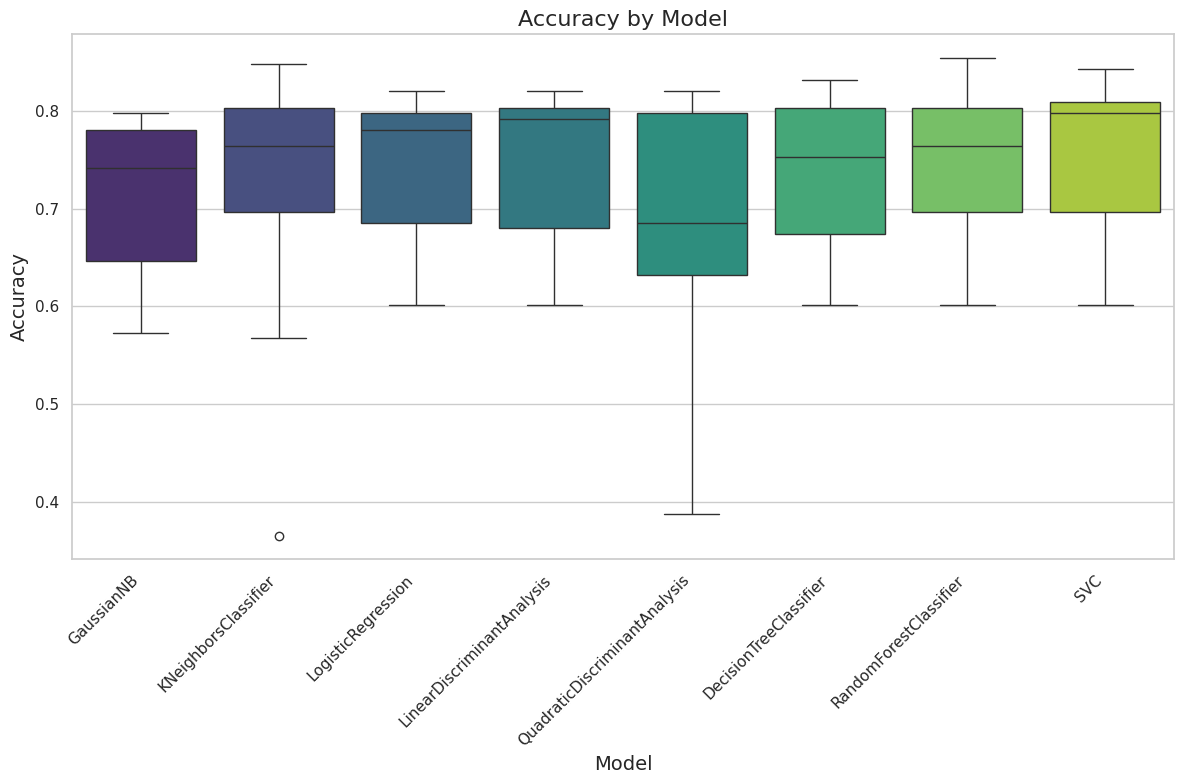

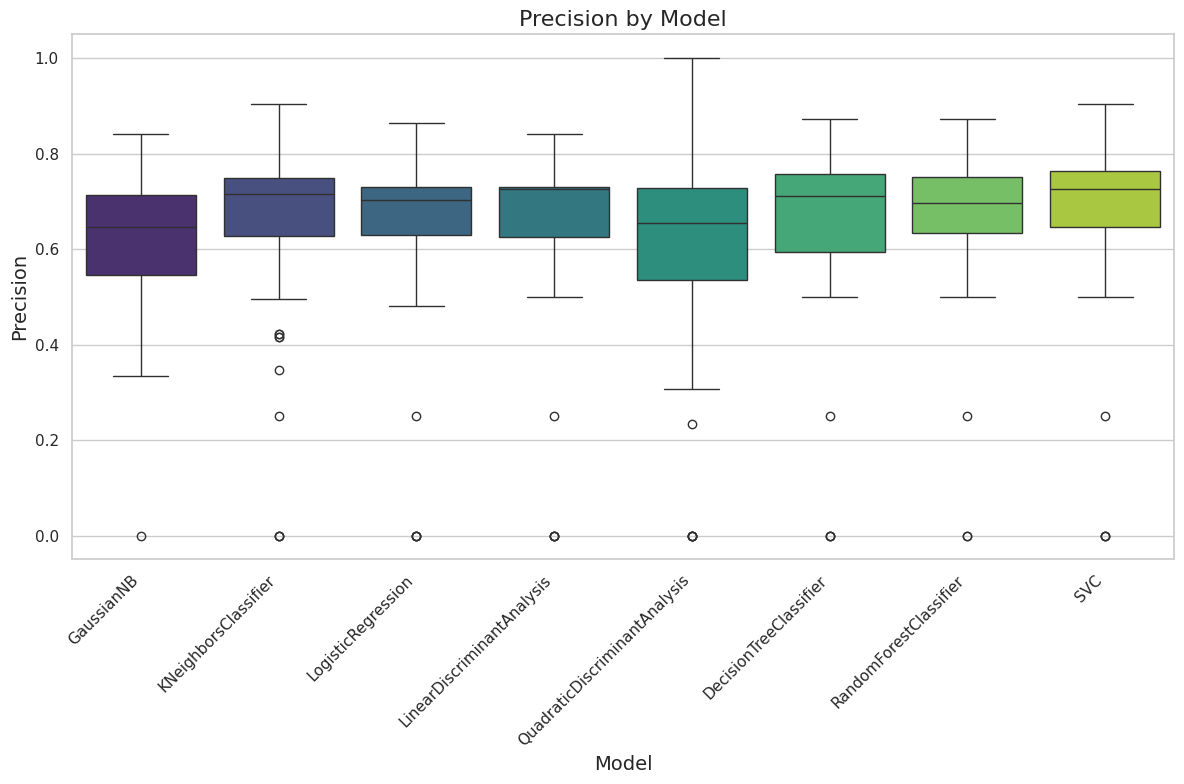

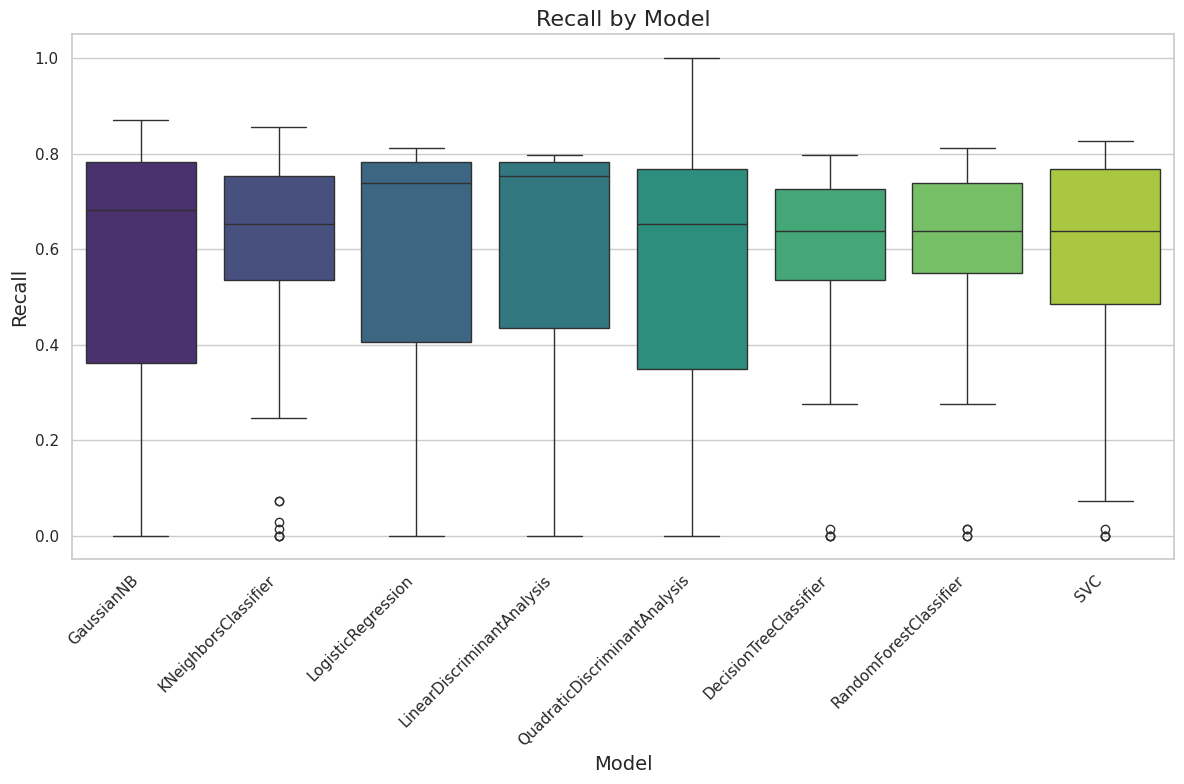

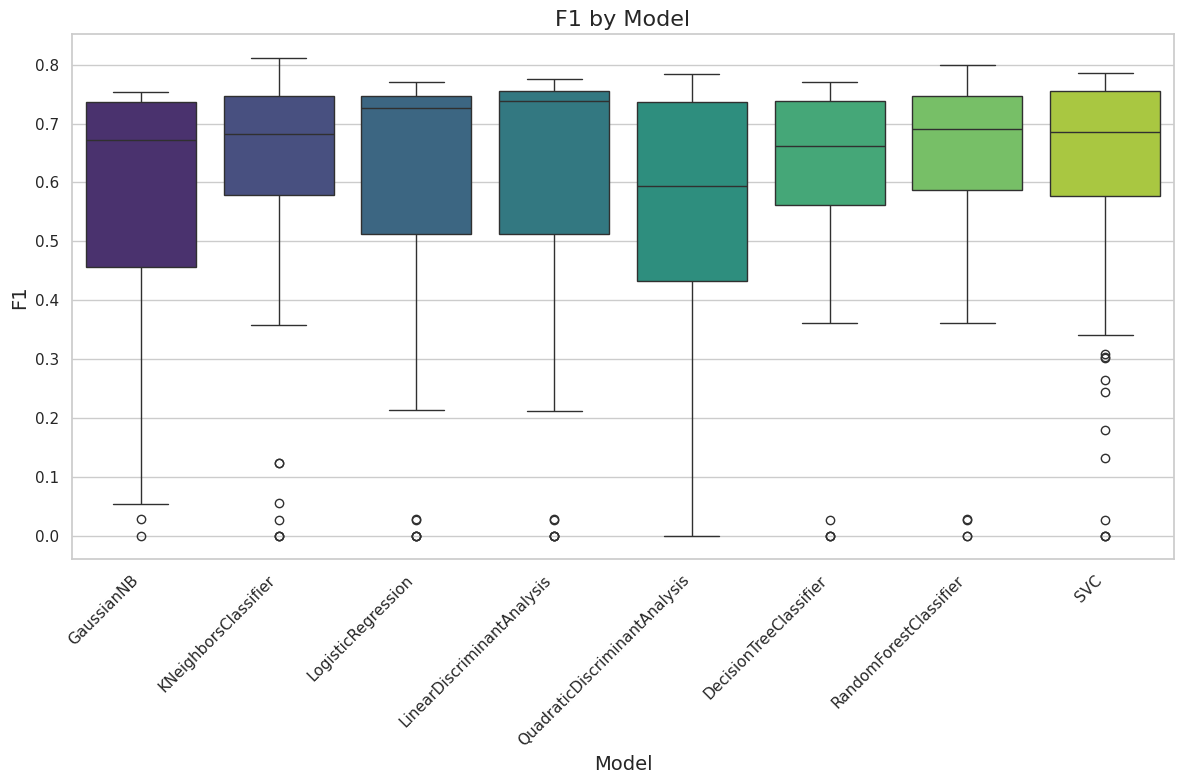

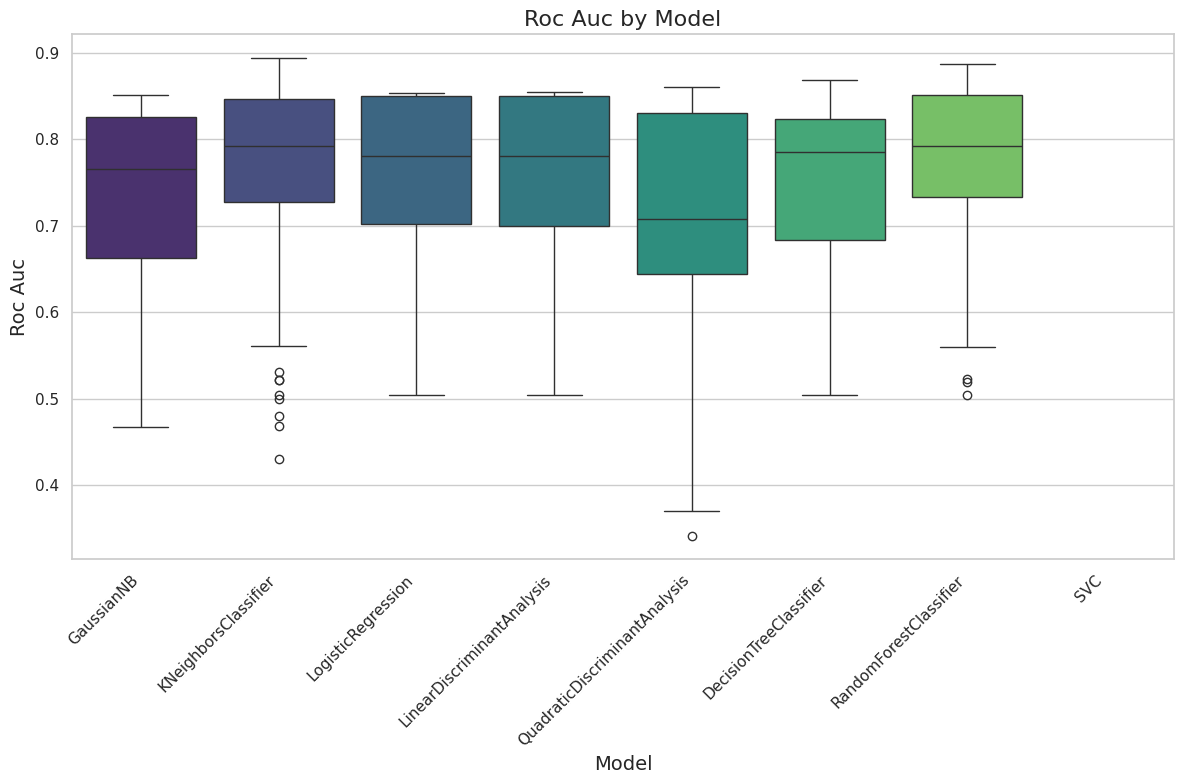

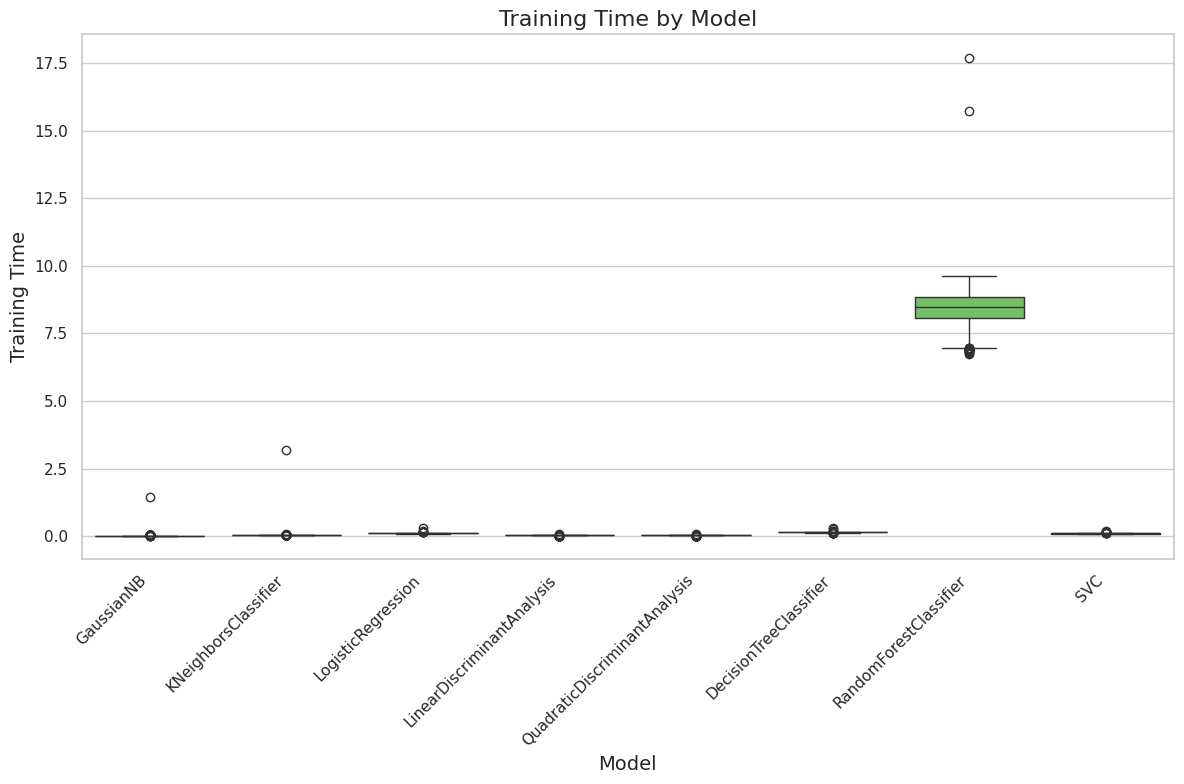

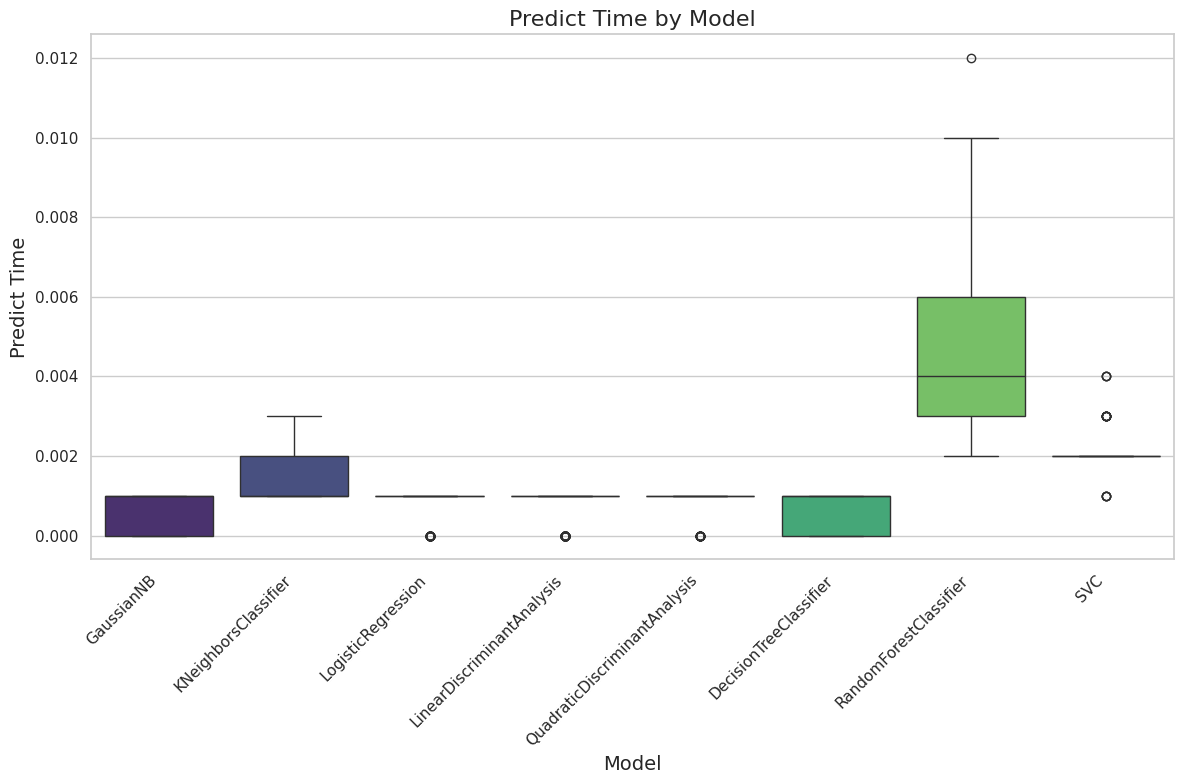

In [18]:
visualize_results(results)

## 7. Findings

Best models created for this tasks are Random Forest Classifier and K-Nearest Neighbours

As their f1-score, precision, recall, and accuracy are quite the same I decided to choose as a two final models:
* K-Nearest Neighbours with 9 number of neighbros and classifing on `EmbarkedQ`, `Sex`, `Pclass2`, `Age` columns - for f1
* RandomForestClassifier with `max_depth`: 20, `min_samples_leaf`: 2, `min_samples_split`: 2, `n_estimators`: 100 configuration and classifing on `Pclass2`, `Pclass3`, `Sex`, `Age`

In [114]:
X_train, y_train = train_clean.drop(["Survived"], axis=1), train_clean["Survived"]

In [115]:
best_model_f1 = KNeighborsClassifier(
    n_neighbors=9
)

In [116]:
best_model_f1.fit(X=X_train[["EmbarkedQ", "Sex", "Pclass2", "Age"]], y=y_train)

,n_neighbors,9
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [117]:
best_model_acc = RandomForestClassifier(
    max_depth=20,
    min_samples_leaf=2,
    min_samples_split=2,
    n_estimators=100,
)

In [118]:
best_model_acc.fit(X=X_train[["Pclass2", "Pclass3", "Sex", "Age"]], y=y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,20
,min_samples_split,2
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## 8. Make predictions

To make proper classification test set needs to be transformed:
* `Age` must be filled out with median value from trainig set
* `Embarked`, `Pclass` must be  codded as dummy variable
* `Sex` must be coded as 0 for female and 1 for male
* `Age` and `Fare` must be scaled with `sklearn.preprocessing.StandardScaler` from train dataset

**Results** on new and unseen data: 
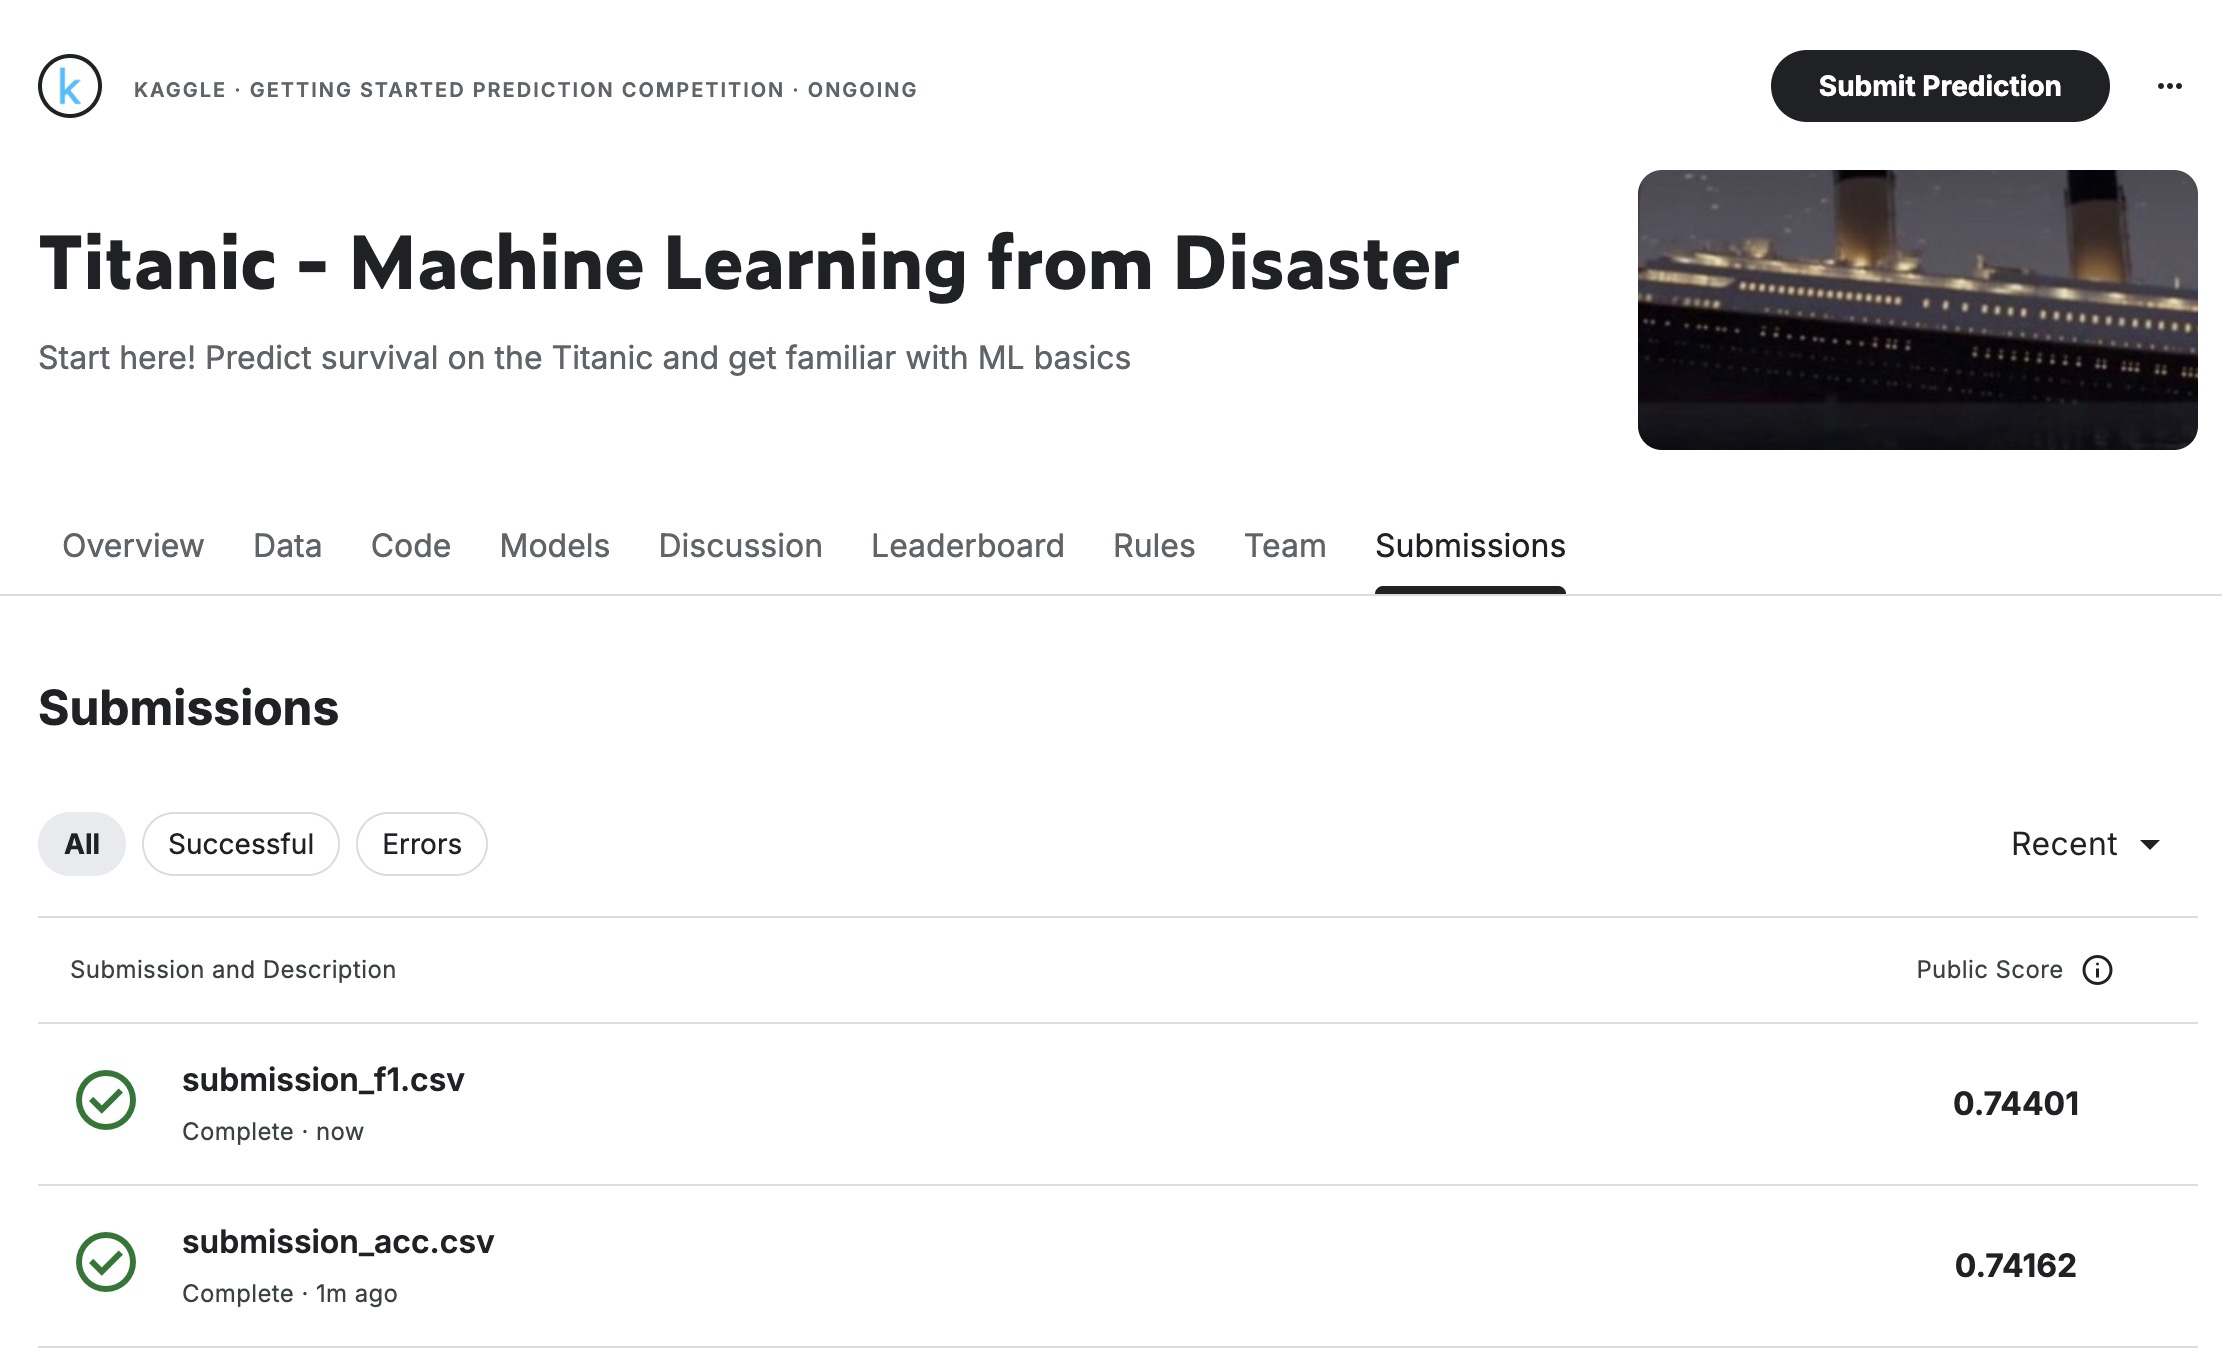

In [119]:
titatnic_test = pd.read_csv("data/test.csv")

In [120]:
titatnic_test.isna().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

### 8.1 Data preparation

In [121]:
test_clean = titatnic_test[
    ["Pclass", "Sex", "Age", "Fare", "Embarked", "SibSp", "Parch"]
]

In [122]:
GROUP_MEDIAN = pd.read_csv("data/train.csv").groupby(["Sex", "Pclass"])["Age"].median()

def fill_age(row):
    if pd.isnull(row["Age"]):
        return GROUP_MEDIAN.loc[row["Sex"], row["Pclass"]]
    else:
        return row["Age"]

test_clean["Age"] = test_clean.apply(fill_age, axis=1)

/tmp/ipykernel_9599/1020817331.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_clean["Age"] = test_clean.apply(fill_age, axis=1)


In [123]:
GROUP_MEDIAN = pd.read_csv("data/train.csv").groupby(["Sex", "Pclass"])["Fare"].median()

def fill_age(row):
    if pd.isnull(row["Fare"]):
        return GROUP_MEDIAN.loc[row["Sex"], row["Pclass"]]
    else:
        return row["Fare"]

test_clean["Fare"] = test_clean.apply(fill_age, axis=1)

/tmp/ipykernel_9599/3619910836.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_clean["Fare"] = test_clean.apply(fill_age, axis=1)


In [124]:
embarked = pd.get_dummies(
    data=test_clean["Embarked"],
    prefix="Embarked",
    prefix_sep="",
    drop_first=False
).astype(int)

test_clean[["EmbarkedC", "EmbarkedQ", "EmbarkedS"]] = embarked

/tmp/ipykernel_9599/1934814547.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_clean[["EmbarkedC", "EmbarkedQ", "EmbarkedS"]] = embarked
/tmp/ipykernel_9599/1934814547.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_clean[["EmbarkedC", "EmbarkedQ", "EmbarkedS"]] = embarked
/tmp/ipykernel_9599/1934814547.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

In [125]:
test_clean["Sex"] = test_clean["Sex"].map(
    lambda x: 1 if x == "male" else 0
)

/tmp/ipykernel_9599/3965721011.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_clean["Sex"] = test_clean["Sex"].map(


In [126]:
pclass = pd.get_dummies(
    data=test_clean["Pclass"],
    prefix="Pclass",
    prefix_sep="",
    drop_first=False
).astype(int)

test_clean[["Pclass1", "Pclass2", "Pclass3"]] = pclass

In [127]:
from sklearn.preprocessing import StandardScaler

scaler_age = StandardScaler()
scaler_fare = StandardScaler()

train = pd.read_csv("data/train.csv")

scaler_age.fit(train[["Age"]])
scaler_fare.fit(train[["Fare"]])

test_clean["Age"] = scaler_age.transform(test_clean[["Age"]])
test_clean["Fare"] = scaler_fare.transform(test_clean[["Fare"]])

In [128]:
test_clean.columns

Index(['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'SibSp', 'Parch',
       'EmbarkedC', 'EmbarkedQ', 'EmbarkedS', 'Pclass1', 'Pclass2', 'Pclass3'],
      dtype='object')

In [129]:
test_clean = test_clean[
    ['Sex', 'Age', 'Fare', 'EmbarkedC', 'EmbarkedQ', 'EmbarkedS', 'Pclass1', 'Pclass2', 'Pclass3']
]

In [130]:
test_clean.isna().sum()

Sex          0
Age          0
Fare         0
EmbarkedC    0
EmbarkedQ    0
EmbarkedS    0
Pclass1      0
Pclass2      0
Pclass3      0
dtype: int64

In [131]:
test_clean.head()

,Sex,Age,Fare,EmbarkedC,EmbarkedQ,EmbarkedS,Pclass1,Pclass2,Pclass3
0,1,0.330723,-0.490783,0,1,0,0,0,1
1,0,1.191823,-0.507479,0,0,1,0,0,1
2,1,2.225142,-0.453367,0,1,0,0,1,0
3,1,-0.185937,-0.474005,0,0,1,0,0,1
4,0,-0.530377,-0.401017,0,0,1,0,0,1


In [132]:
test_clean.to_csv("data/test_clean.csv", index=False)

### 8.2 Prediction

In [133]:
test_clean = pd.read_csv("data/test_clean.csv")

In [134]:
y_pred_f1 = best_model_f1.predict(
    test_clean[["EmbarkedQ", "Sex", "Pclass2", "Age"]]
)

In [136]:
y_pred_acc = best_model_acc.predict(
    test_clean[["Pclass2", "Pclass3", "Sex", "Age"]]
)

### 8.3 Prepare submission file

In [137]:
y_pred_f1 = pd.Series(y_pred_f1, name="Survived")
y_pred_acc = pd.Series(y_pred_acc, name="Survived")

In [146]:
(y_pred_f1 != y_pred_acc).sum()

np.int64(43)

In [147]:
titatnic_test_f1 = pd.concat(
    [titatnic_test, y_pred_f1],
    axis=1
)

titatnic_test_acc = pd.concat(
    [titatnic_test, y_pred_acc],
    axis=1
)

In [148]:
titatnic_test_f1.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1


In [149]:
titatnic_test_acc.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1


In [150]:
submission_f1 = titatnic_test_f1[["PassengerId", "Survived"]]
submission_acc = titatnic_test_acc[["PassengerId", "Survived"]]

In [151]:
submission_f1.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,1


In [152]:
submission_acc.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,1


In [153]:
submission_f1.to_csv("data/submission_f1.csv", index=False)
submission_acc.to_csv("data/submission_acc.csv", index=False)